In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

/home/milk/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-02-15 01:55:26.820766: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 01:55:26.820799: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 01:55:26.821884: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-15 01:55:26.827963: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instruc

In [2]:
# train, val, tset dataset load
train_data = 'copy/Fruits_Vegetables/train'
val_data = 'copy/Fruits_Vegetables/validation'
test_data = 'copy/Fruits_Vegetables/test'

In [3]:
# img size
img_width = 180
img_height =180 

In [4]:
# 고급 Keras 사전 처리 유틸리티 : tf.keras.utils.image_dataset_from_directory
# https://www.tensorflow.org/tutorials/load_data/images?hl=ko
# train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data,
    shuffle=True,
    image_size=(img_width, img_height),
    batch_size=32,
    validation_split=False
)

Found 4106 files belonging to 46 classes.


2024-02-15 01:55:28.712942: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1556 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:17:00.0, compute capability: 8.6
2024-02-15 01:55:28.713501: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 10112 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:b3:00.0, compute capability: 8.6


In [5]:
# 데이터셋 클래스 이름 확인
data_class_name = train_ds.class_names

In [6]:
data_class_name

['apple',
 'asparagus',
 'banana',
 'beans',
 'beansprouts',
 'beetroot',
 'bell pepper',
 'broccoli',
 'cabbage',
 'capsicum',
 'carrot',
 'cauliflower',
 'chicken',
 'chickenwing',
 'chilli pepper',
 'corn',
 'cucumber',
 'egg',
 'eggplant',
 'garlic',
 'ginger',
 'grapes',
 'jalepeno',
 'kiwi',
 'lemon',
 'lettuce',
 'mango',
 'onion',
 'orange',
 'paprika',
 'pear',
 'peas',
 'pineapple',
 'pomegranate',
 'pork',
 'potato',
 'pumpkin',
 'raddish',
 'salmon',
 'spinach',
 'sweetcorn',
 'sweetpotato',
 'tofu',
 'tomato',
 'turnip',
 'watermelon']

In [7]:
# # 클래스별로 샘플 수 계산
# class_counts = np.array([len(os.listdir(os.path.join(train_data, class_name))) for class_name in data_class_name])

# # 클래스별로 가중치 계산
# class_weights = len(data_class_name) / (len(class_counts) * class_counts)

# # 클래스 가중치를 딕셔너리로 변환
# class_weight_dict = dict(enumerate(class_weights))

In [8]:
# validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_data,                                                     
    image_size=(img_height,img_width),                                                  
    batch_size=32,                                                      
    shuffle=False,                                                    
    validation_split=False
)

Found 462 files belonging to 46 classes.


In [9]:
# test dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data,
    image_size=(img_height,img_width),
    shuffle=False,
    batch_size=32,
    validation_split=False
)

Found 459 files belonging to 46 classes.


2024-02-15 01:55:30.448238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 01:55:31.317843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 01:55:31.723892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


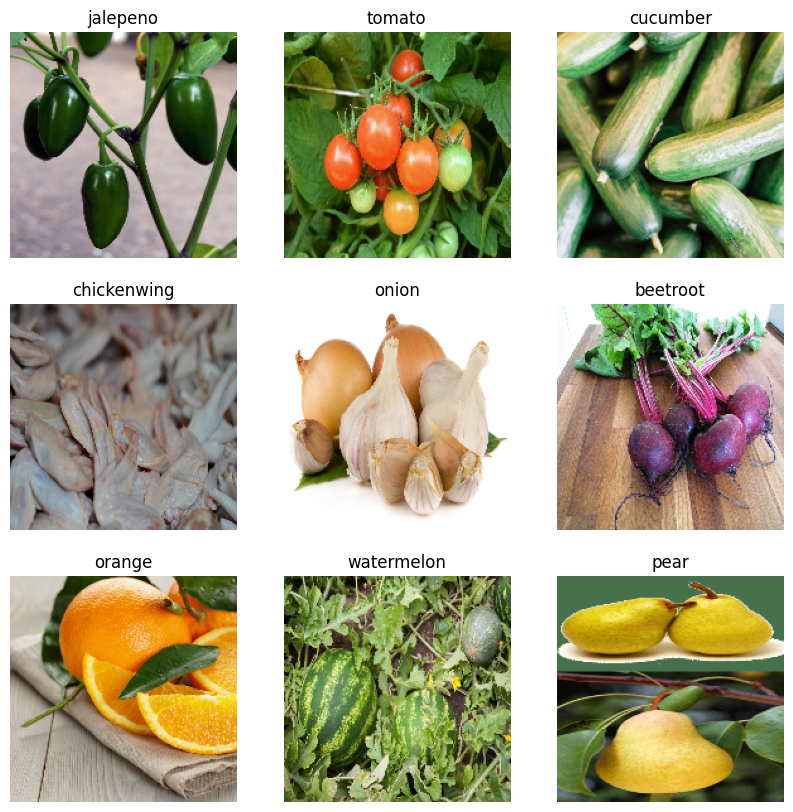

In [10]:
plt.figure(figsize=(10,10))
for image, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(data_class_name[labels[i]])
        plt.axis('off')

In [11]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [25]:
# RGB 채널 값 = [0, 255] 범위 -> 신경망에 이상적이지 않다. 일반적으로 입력 값을 작게 만든다
# tf.keras.layers.Rescaling : [0, 1] 범위로 데이터 표준화

model = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),  
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),                                
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(len(data_class_name), activation='softmax')
])

In [26]:
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']
)

In [27]:
epochs_size = 150
# history = model.fit(train_ds, class_weight=class_weight_dict, validation_data=val_ds, epochs=epochs_size)
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs_size)

Epoch 1/150


2024-02-15 09:29:58.455739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:29:59.197212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:29:59.469316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 15s - loss: 3.9432 - accuracy: 0.1442

2024-02-15 09:30:02.287004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:30:02.392579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 16s - loss: 3.7444 - accuracy: 0.1636

2024-02-15 09:30:03.026274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 18s - loss: 3.6575 - accuracy: 0.1750

2024-02-15 09:30:03.904590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/129 [=====>........................] - ETA: 18s - loss: 3.4875 - accuracy: 0.1832

2024-02-15 09:30:05.723497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 3.4371 - accuracy: 0.1915

2024-02-15 09:30:06.096457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 18s - loss: 3.2966 - accuracy: 0.2047

2024-02-15 09:30:08.765751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 17s - loss: 3.2503 - accuracy: 0.2069

2024-02-15 09:30:09.993747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 3.2074 - accuracy: 0.2142

2024-02-15 09:30:10.643108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 3.1885 - accuracy: 0.2169

2024-02-15 09:30:11.012373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 12s - loss: 3.0865 - accuracy: 0.2322

2024-02-15 09:30:13.733512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 2.9652 - accuracy: 0.2419

2024-02-15 09:30:17.132255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 2.9518 - accuracy: 0.2435

2024-02-15 09:30:17.593404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:30:17.603676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 2.8992 - accuracy: 0.2517

2024-02-15 09:30:18.694505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:30:18.782217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 2.8778 - accuracy: 0.2551

2024-02-15 09:30:19.693548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 2.8423 - accuracy: 0.2584

2024-02-15 09:30:21.488986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 2.8179 - accuracy: 0.2640

2024-02-15 09:30:22.949548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 2.8028 - accuracy: 0.2668

2024-02-15 09:30:23.495492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 2.7647 - accuracy: 0.2732

2024-02-15 09:30:26.234190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:30:26.719254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 31s 211ms/step - loss: 2.7655 - accuracy: 0.2733 - val_loss: 5.6559 - val_accuracy: 0.0303
Epoch 2/150


2024-02-15 09:30:28.172927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:30:28.880285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:07 - loss: 1.7364 - accuracy: 0.5000

2024-02-15 09:30:29.164356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 1.7343 - accuracy: 0.5048

2024-02-15 09:30:30.990323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:30:31.116430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 1.7257 - accuracy: 0.5055

2024-02-15 09:30:31.825790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 1.6921 - accuracy: 0.5141

2024-02-15 09:30:32.693344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 1.6771 - accuracy: 0.5167

2024-02-15 09:30:34.663398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 19s - loss: 1.7030 - accuracy: 0.5081

2024-02-15 09:30:35.118819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 20s - loss: 1.6772 - accuracy: 0.5188

2024-02-15 09:30:38.017448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 19s - loss: 1.6969 - accuracy: 0.5153

2024-02-15 09:30:39.205826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 18s - loss: 1.6969 - accuracy: 0.5143

2024-02-15 09:30:39.943573: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 17s - loss: 1.6838 - accuracy: 0.5190

2024-02-15 09:30:40.364431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 1.6771 - accuracy: 0.5245

2024-02-15 09:30:43.111192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 9s - loss: 1.6679 - accuracy: 0.5239

2024-02-15 09:30:46.520071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 1.6629 - accuracy: 0.5248

2024-02-15 09:30:47.066314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:30:47.081378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/129 [=====================>........] - ETA: 6s - loss: 1.6474 - accuracy: 0.5299

2024-02-15 09:30:48.244432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:30:48.315315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 6s - loss: 1.6357 - accuracy: 0.5316

2024-02-15 09:30:49.237313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 1.6248 - accuracy: 0.5341

2024-02-15 09:30:50.992061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 1.6129 - accuracy: 0.5386

2024-02-15 09:30:52.319080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 1.6070 - accuracy: 0.5411

2024-02-15 09:30:52.829854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 1.5943 - accuracy: 0.5444

2024-02-15 09:30:55.480859: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:30:55.967546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 218ms/step - loss: 1.5964 - accuracy: 0.5438 - val_loss: 5.3496 - val_accuracy: 0.0368
Epoch 3/150


2024-02-15 09:30:57.667234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:30:58.367901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:14 - loss: 1.0128 - accuracy: 0.7500

2024-02-15 09:30:58.634235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 1.0890 - accuracy: 0.7212

2024-02-15 09:31:00.411725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:31:00.529742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 1.0994 - accuracy: 0.7132

2024-02-15 09:31:01.234822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 1.0834 - accuracy: 0.7141

2024-02-15 09:31:02.189867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 1.0414 - accuracy: 0.7132

2024-02-15 09:31:04.056061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 1.0271 - accuracy: 0.7147

2024-02-15 09:31:04.463041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 1.0131 - accuracy: 0.7188

2024-02-15 09:31:07.114274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 1.0047 - accuracy: 0.7208

2024-02-15 09:31:08.298938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.9979 - accuracy: 0.7233

2024-02-15 09:31:08.922592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.9844 - accuracy: 0.7273

2024-02-15 09:31:09.303376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.9665 - accuracy: 0.7351

2024-02-15 09:31:11.926008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.9208 - accuracy: 0.7467

2024-02-15 09:31:15.271187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.9155 - accuracy: 0.7496

2024-02-15 09:31:15.834214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:31:15.849372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.8993 - accuracy: 0.7547

2024-02-15 09:31:17.020568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:31:17.098844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.8898 - accuracy: 0.7573

2024-02-15 09:31:18.025821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.8768 - accuracy: 0.7595

2024-02-15 09:31:19.810684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.8649 - accuracy: 0.7648

2024-02-15 09:31:21.181016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.8558 - accuracy: 0.7676

2024-02-15 09:31:21.704836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.8334 - accuracy: 0.7747

2024-02-15 09:31:24.222764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:31:24.673129: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 212ms/step - loss: 0.8335 - accuracy: 0.7745 - val_loss: 2.6492 - val_accuracy: 0.2489
Epoch 4/150


2024-02-15 09:31:26.386972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:31:27.195927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:48 - loss: 0.7302 - accuracy: 0.8125

2024-02-15 09:31:27.570146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.4583 - accuracy: 0.9062

2024-02-15 09:31:29.268458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:31:29.390271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.4780 - accuracy: 0.8934

2024-02-15 09:31:30.009928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 18s - loss: 0.4755 - accuracy: 0.8953

2024-02-15 09:31:30.833833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 18s - loss: 0.4677 - accuracy: 0.8929

2024-02-15 09:31:32.551094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.4545 - accuracy: 0.8972

2024-02-15 09:31:32.982017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.4398 - accuracy: 0.9000

2024-02-15 09:31:36.034235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.4409 - accuracy: 0.8986

2024-02-15 09:31:37.232250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.4410 - accuracy: 0.9004

2024-02-15 09:31:37.889003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.4368 - accuracy: 0.9026

2024-02-15 09:31:38.249484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.4291 - accuracy: 0.9048

2024-02-15 09:31:40.826952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.3935 - accuracy: 0.9158

2024-02-15 09:31:44.208750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.3943 - accuracy: 0.9159

2024-02-15 09:31:44.694493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:31:44.710526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.3839 - accuracy: 0.9182

2024-02-15 09:31:45.912630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:31:45.996437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.3775 - accuracy: 0.9211

2024-02-15 09:31:46.925151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.3658 - accuracy: 0.9239

2024-02-15 09:31:48.712627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.3577 - accuracy: 0.9250

2024-02-15 09:31:50.069611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.3573 - accuracy: 0.9249

2024-02-15 09:31:50.577175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.3461 - accuracy: 0.9265

2024-02-15 09:31:52.935733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:31:53.460881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 211ms/step - loss: 0.3458 - accuracy: 0.9267 - val_loss: 1.1791 - val_accuracy: 0.7056
Epoch 5/150


2024-02-15 09:31:55.074507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:31:55.843559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:30 - loss: 0.1504 - accuracy: 1.0000

2024-02-15 09:31:56.208615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.2030 - accuracy: 0.9688

2024-02-15 09:31:58.174370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:31:58.316450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 20s - loss: 0.2093 - accuracy: 0.9706

2024-02-15 09:31:59.046043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 21s - loss: 0.2033 - accuracy: 0.9688

2024-02-15 09:31:59.928493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.2073 - accuracy: 0.9632

2024-02-15 09:32:01.504943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.2036 - accuracy: 0.9637

2024-02-15 09:32:01.932362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.1981 - accuracy: 0.9617

2024-02-15 09:32:04.506064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.1934 - accuracy: 0.9625

2024-02-15 09:32:05.774834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.1901 - accuracy: 0.9642

2024-02-15 09:32:06.584330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.1893 - accuracy: 0.9638

2024-02-15 09:32:06.985563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.1989 - accuracy: 0.9620

2024-02-15 09:32:09.905863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.1840 - accuracy: 0.9643

2024-02-15 09:32:12.885437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.1835 - accuracy: 0.9644

2024-02-15 09:32:13.361548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:32:13.369271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/129 [=====================>........] - ETA: 6s - loss: 0.1792 - accuracy: 0.9661

2024-02-15 09:32:14.555938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:32:14.631788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.1763 - accuracy: 0.9669

2024-02-15 09:32:15.658994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.1696 - accuracy: 0.9682

2024-02-15 09:32:17.624624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.1662 - accuracy: 0.9693

2024-02-15 09:32:18.990343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.1642 - accuracy: 0.9698

2024-02-15 09:32:19.503767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.1605 - accuracy: 0.9714

2024-02-15 09:32:21.830740: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:32:22.323408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 212ms/step - loss: 0.1624 - accuracy: 0.9710 - val_loss: 0.5780 - val_accuracy: 0.8442
Epoch 6/150


2024-02-15 09:32:23.975605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:32:24.750156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:31 - loss: 0.1179 - accuracy: 0.9688

2024-02-15 09:32:25.038145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.1284 - accuracy: 0.9832

2024-02-15 09:32:26.929759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:32:27.050423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.1433 - accuracy: 0.9743

2024-02-15 09:32:27.722623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.1490 - accuracy: 0.9734

2024-02-15 09:32:28.567913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 18s - loss: 0.1343 - accuracy: 0.9788

2024-02-15 09:32:30.081122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.1295 - accuracy: 0.9788

2024-02-15 09:32:30.499175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 18s - loss: 0.1172 - accuracy: 0.9816

2024-02-15 09:32:33.073856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.1145 - accuracy: 0.9833

2024-02-15 09:32:34.421674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.1180 - accuracy: 0.9824

2024-02-15 09:32:35.186478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.1170 - accuracy: 0.9816

2024-02-15 09:32:35.607032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.1220 - accuracy: 0.9812

2024-02-15 09:32:38.470610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.1179 - accuracy: 0.9812

2024-02-15 09:32:41.435387: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.1176 - accuracy: 0.9813

2024-02-15 09:32:41.955422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:32:41.976763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.1159 - accuracy: 0.9817

2024-02-15 09:32:42.961280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:32:43.051998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.1138 - accuracy: 0.9823

2024-02-15 09:32:43.993044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.1101 - accuracy: 0.9829

2024-02-15 09:32:46.123488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.1103 - accuracy: 0.9832

2024-02-15 09:32:47.522252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.1090 - accuracy: 0.9834

2024-02-15 09:32:48.135011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.1111 - accuracy: 0.9839

2024-02-15 09:32:50.526045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:32:50.965651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 210ms/step - loss: 0.1115 - accuracy: 0.9837 - val_loss: 0.5358 - val_accuracy: 0.8723
Epoch 7/150


2024-02-15 09:32:52.460178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:32:53.134163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:17 - loss: 0.0365 - accuracy: 1.0000

2024-02-15 09:32:53.467792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 20s - loss: 0.0869 - accuracy: 0.9880

2024-02-15 09:32:55.457817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:32:55.583532: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 20s - loss: 0.0793 - accuracy: 0.9890

2024-02-15 09:32:56.437004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 21s - loss: 0.0897 - accuracy: 0.9891

2024-02-15 09:32:57.342317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0970 - accuracy: 0.9844

2024-02-15 09:32:58.927754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0960 - accuracy: 0.9849

2024-02-15 09:32:59.302157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0892 - accuracy: 0.9859

2024-02-15 09:33:01.893461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0983 - accuracy: 0.9847

2024-02-15 09:33:03.271876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 18s - loss: 0.0976 - accuracy: 0.9837

2024-02-15 09:33:04.076568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 17s - loss: 0.0984 - accuracy: 0.9835

2024-02-15 09:33:04.474548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0996 - accuracy: 0.9841

2024-02-15 09:33:07.232860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0936 - accuracy: 0.9849

2024-02-15 09:33:10.212540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0931 - accuracy: 0.9849

2024-02-15 09:33:10.693041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:33:10.708241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0887 - accuracy: 0.9860

2024-02-15 09:33:11.719539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:33:11.781155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0880 - accuracy: 0.9861

2024-02-15 09:33:12.762529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0878 - accuracy: 0.9861

2024-02-15 09:33:14.855402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0849 - accuracy: 0.9870

2024-02-15 09:33:16.275955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0868 - accuracy: 0.9866

2024-02-15 09:33:16.833285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0843 - accuracy: 0.9875

2024-02-15 09:33:19.244379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:33:19.681854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 213ms/step - loss: 0.0848 - accuracy: 0.9873 - val_loss: 0.5074 - val_accuracy: 0.8658
Epoch 8/150


2024-02-15 09:33:21.221702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:33:21.900171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:14 - loss: 0.0267 - accuracy: 1.0000

2024-02-15 09:33:22.228374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0778 - accuracy: 0.9880

2024-02-15 09:33:24.012322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:33:24.119156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0859 - accuracy: 0.9871

2024-02-15 09:33:24.932250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 21s - loss: 0.0838 - accuracy: 0.9875

2024-02-15 09:33:25.982962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0762 - accuracy: 0.9877

2024-02-15 09:33:27.831285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 19s - loss: 0.0773 - accuracy: 0.9869

2024-02-15 09:33:28.215900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0699 - accuracy: 0.9898

2024-02-15 09:33:30.790179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0812 - accuracy: 0.9882

2024-02-15 09:33:31.968750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0848 - accuracy: 0.9870

2024-02-15 09:33:32.636781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0882 - accuracy: 0.9865

2024-02-15 09:33:33.030975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0845 - accuracy: 0.9870

2024-02-15 09:33:35.840263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0787 - accuracy: 0.9871

2024-02-15 09:33:38.842928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0780 - accuracy: 0.9871

2024-02-15 09:33:39.325661: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:33:39.331667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/129 [=====================>........] - ETA: 6s - loss: 0.0745 - accuracy: 0.9878

2024-02-15 09:33:40.465475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:33:40.540710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0729 - accuracy: 0.9880

2024-02-15 09:33:41.448271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0721 - accuracy: 0.9873

2024-02-15 09:33:43.422622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0722 - accuracy: 0.9871

2024-02-15 09:33:44.788848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0724 - accuracy: 0.9872

2024-02-15 09:33:45.363747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0700 - accuracy: 0.9875

2024-02-15 09:33:47.623737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:33:48.060160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 209ms/step - loss: 0.0700 - accuracy: 0.9876 - val_loss: 0.5595 - val_accuracy: 0.8528
Epoch 9/150


2024-02-15 09:33:49.482469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:33:50.199988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:13 - loss: 0.0137 - accuracy: 1.0000

2024-02-15 09:33:50.490505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0575 - accuracy: 0.9880

2024-02-15 09:33:52.302552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:33:52.441995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0646 - accuracy: 0.9890

2024-02-15 09:33:53.180206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0650 - accuracy: 0.9891

2024-02-15 09:33:54.135599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0582 - accuracy: 0.9900

2024-02-15 09:33:55.790354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0626 - accuracy: 0.9879

2024-02-15 09:33:56.222873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0563 - accuracy: 0.9898

2024-02-15 09:33:58.957920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0595 - accuracy: 0.9889

2024-02-15 09:34:00.132042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0597 - accuracy: 0.9876

2024-02-15 09:34:00.855835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0615 - accuracy: 0.9865

2024-02-15 09:34:01.215239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0625 - accuracy: 0.9851

2024-02-15 09:34:03.841256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0624 - accuracy: 0.9857

2024-02-15 09:34:07.129420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0617 - accuracy: 0.9856

2024-02-15 09:34:07.657564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:34:07.676726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0617 - accuracy: 0.9860

2024-02-15 09:34:08.771589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:34:08.852169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0596 - accuracy: 0.9867

2024-02-15 09:34:09.865521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0600 - accuracy: 0.9867

2024-02-15 09:34:11.691374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0609 - accuracy: 0.9870

2024-02-15 09:34:12.981036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0605 - accuracy: 0.9872

2024-02-15 09:34:13.514755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0600 - accuracy: 0.9875

2024-02-15 09:34:16.059738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:34:16.506505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 212ms/step - loss: 0.0599 - accuracy: 0.9876 - val_loss: 0.5396 - val_accuracy: 0.8680
Epoch 10/150


2024-02-15 09:34:18.123751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:34:18.790716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:06 - loss: 0.0404 - accuracy: 1.0000

2024-02-15 09:34:19.062090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0618 - accuracy: 0.9904

2024-02-15 09:34:20.816823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:34:20.937590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0643 - accuracy: 0.9908

2024-02-15 09:34:21.585409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0703 - accuracy: 0.9891

2024-02-15 09:34:22.517747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0580 - accuracy: 0.9900

2024-02-15 09:34:24.195701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0547 - accuracy: 0.9909

2024-02-15 09:34:24.616365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0509 - accuracy: 0.9922

2024-02-15 09:34:27.314209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0564 - accuracy: 0.9903

2024-02-15 09:34:28.506909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0538 - accuracy: 0.9909

2024-02-15 09:34:29.157744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0545 - accuracy: 0.9902

2024-02-15 09:34:29.510252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 12s - loss: 0.0575 - accuracy: 0.9889

2024-02-15 09:34:32.086528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0547 - accuracy: 0.9893

2024-02-15 09:34:35.364757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0544 - accuracy: 0.9892

2024-02-15 09:34:35.912524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:34:35.927307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0526 - accuracy: 0.9897

2024-02-15 09:34:37.299229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:34:37.373806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0516 - accuracy: 0.9899

2024-02-15 09:34:38.353523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0516 - accuracy: 0.9899

2024-02-15 09:34:40.111979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0499 - accuracy: 0.9899

2024-02-15 09:34:41.442711: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0510 - accuracy: 0.9896

2024-02-15 09:34:42.007761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0503 - accuracy: 0.9895

2024-02-15 09:34:44.427359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:34:44.914047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 210ms/step - loss: 0.0504 - accuracy: 0.9895 - val_loss: 0.6358 - val_accuracy: 0.8571
Epoch 11/150


2024-02-15 09:34:46.646787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:34:47.516904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 4:01 - loss: 0.0266 - accuracy: 1.0000

2024-02-15 09:34:47.896644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0470 - accuracy: 0.9856

2024-02-15 09:34:49.594679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:34:49.700188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0472 - accuracy: 0.9853

2024-02-15 09:34:50.354657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 18s - loss: 0.0430 - accuracy: 0.9875

2024-02-15 09:34:51.223425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 18s - loss: 0.0518 - accuracy: 0.9866

2024-02-15 09:34:52.751527: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 16s - loss: 0.0480 - accuracy: 0.9879

2024-02-15 09:34:53.129890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 18s - loss: 0.0524 - accuracy: 0.9883

2024-02-15 09:34:56.034754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0545 - accuracy: 0.9882

2024-02-15 09:34:57.259502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0562 - accuracy: 0.9876

2024-02-15 09:34:57.903684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0558 - accuracy: 0.9877

2024-02-15 09:34:58.267961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0570 - accuracy: 0.9870

2024-02-15 09:35:01.125201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0585 - accuracy: 0.9871

2024-02-15 09:35:04.345766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0583 - accuracy: 0.9871

2024-02-15 09:35:04.877366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:35:04.906796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/129 [=====================>........] - ETA: 6s - loss: 0.0552 - accuracy: 0.9882

2024-02-15 09:35:05.957582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:35:06.028674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0549 - accuracy: 0.9883

2024-02-15 09:35:06.969165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0541 - accuracy: 0.9890

2024-02-15 09:35:08.780497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0529 - accuracy: 0.9890

2024-02-15 09:35:10.105704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0520 - accuracy: 0.9893

2024-02-15 09:35:10.619255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0533 - accuracy: 0.9888

2024-02-15 09:35:12.944644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:35:13.444423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 209ms/step - loss: 0.0533 - accuracy: 0.9888 - val_loss: 0.6284 - val_accuracy: 0.8420
Epoch 12/150


2024-02-15 09:35:15.201030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:35:15.941481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:32 - loss: 0.0109 - accuracy: 1.0000

2024-02-15 09:35:16.291916: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0381 - accuracy: 0.9928

2024-02-15 09:35:18.143674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:35:18.249230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0447 - accuracy: 0.9926

2024-02-15 09:35:18.928461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0432 - accuracy: 0.9922

2024-02-15 09:35:19.810126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/129 [=====>........................] - ETA: 18s - loss: 0.0535 - accuracy: 0.9881

2024-02-15 09:35:21.315651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/129 [======>.......................] - ETA: 16s - loss: 0.0509 - accuracy: 0.9893

2024-02-15 09:35:21.691766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 18s - loss: 0.0504 - accuracy: 0.9891

2024-02-15 09:35:24.420837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/129 [=========>....................] - ETA: 18s - loss: 0.0499 - accuracy: 0.9893

2024-02-15 09:35:25.774255: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0498 - accuracy: 0.9889

2024-02-15 09:35:26.622468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0512 - accuracy: 0.9890

2024-02-15 09:35:27.075156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0518 - accuracy: 0.9889

2024-02-15 09:35:29.739648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0542 - accuracy: 0.9871

2024-02-15 09:35:32.716560: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0548 - accuracy: 0.9871

2024-02-15 09:35:33.227097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:35:33.234762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0535 - accuracy: 0.9874

2024-02-15 09:35:34.504904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:35:34.581180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0546 - accuracy: 0.9867

2024-02-15 09:35:35.620584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0538 - accuracy: 0.9873

2024-02-15 09:35:37.617347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0525 - accuracy: 0.9875

2024-02-15 09:35:38.907804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0537 - accuracy: 0.9872

2024-02-15 09:35:39.471775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0520 - accuracy: 0.9878

2024-02-15 09:35:41.853030: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:35:42.336871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 212ms/step - loss: 0.0521 - accuracy: 0.9878 - val_loss: 0.5652 - val_accuracy: 0.8723
Epoch 13/150


2024-02-15 09:35:44.083953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:35:44.844827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:47 - loss: 0.0751 - accuracy: 0.9688

2024-02-15 09:35:45.244725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 16s - loss: 0.0388 - accuracy: 0.9904

2024-02-15 09:35:46.908735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:35:47.021263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0401 - accuracy: 0.9908

2024-02-15 09:35:47.783296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0414 - accuracy: 0.9906

2024-02-15 09:35:48.634593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 18s - loss: 0.0505 - accuracy: 0.9900

2024-02-15 09:35:50.217398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0466 - accuracy: 0.9909

2024-02-15 09:35:50.612138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 18s - loss: 0.0471 - accuracy: 0.9904

2024-02-15 09:35:53.277190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/129 [=========>....................] - ETA: 18s - loss: 0.0483 - accuracy: 0.9893

2024-02-15 09:35:54.617092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0529 - accuracy: 0.9883

2024-02-15 09:35:55.443964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0546 - accuracy: 0.9871

2024-02-15 09:35:55.838558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0556 - accuracy: 0.9865

2024-02-15 09:35:58.481855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0587 - accuracy: 0.9842

2024-02-15 09:36:01.469551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0579 - accuracy: 0.9846

2024-02-15 09:36:01.998248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:36:02.008943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0581 - accuracy: 0.9847

2024-02-15 09:36:02.997351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:36:03.068469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0578 - accuracy: 0.9852

2024-02-15 09:36:04.131866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0572 - accuracy: 0.9847

2024-02-15 09:36:06.321980: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0571 - accuracy: 0.9848

2024-02-15 09:36:07.751778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0577 - accuracy: 0.9845

2024-02-15 09:36:08.244995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0573 - accuracy: 0.9846

2024-02-15 09:36:10.509599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:36:10.968477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 209ms/step - loss: 0.0571 - accuracy: 0.9847 - val_loss: 0.7177 - val_accuracy: 0.8355
Epoch 14/150


2024-02-15 09:36:12.464685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:36:13.264418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:29 - loss: 0.0454 - accuracy: 1.0000

2024-02-15 09:36:13.585549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 20s - loss: 0.0703 - accuracy: 0.9880

2024-02-15 09:36:15.572098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:36:15.711485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 20s - loss: 0.0681 - accuracy: 0.9871

2024-02-15 09:36:16.521094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 21s - loss: 0.0654 - accuracy: 0.9859

2024-02-15 09:36:17.361983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0607 - accuracy: 0.9877

2024-02-15 09:36:19.067397: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0598 - accuracy: 0.9879

2024-02-15 09:36:19.460821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 20s - loss: 0.0533 - accuracy: 0.9896

2024-02-15 09:36:22.204156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 19s - loss: 0.0538 - accuracy: 0.9896

2024-02-15 09:36:23.521751: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 18s - loss: 0.0524 - accuracy: 0.9889

2024-02-15 09:36:24.366487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 17s - loss: 0.0531 - accuracy: 0.9884

2024-02-15 09:36:24.746221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0549 - accuracy: 0.9865

2024-02-15 09:36:27.355055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0519 - accuracy: 0.9868

2024-02-15 09:36:30.527669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0541 - accuracy: 0.9864

2024-02-15 09:36:31.033485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:36:31.052969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0513 - accuracy: 0.9874

2024-02-15 09:36:32.155642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:36:32.252861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0506 - accuracy: 0.9874

2024-02-15 09:36:33.294637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0492 - accuracy: 0.9878

2024-02-15 09:36:35.477283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0473 - accuracy: 0.9886

2024-02-15 09:36:36.938824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0467 - accuracy: 0.9888

2024-02-15 09:36:37.505575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0470 - accuracy: 0.9888

2024-02-15 09:36:39.833862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:36:40.272114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 216ms/step - loss: 0.0469 - accuracy: 0.9888 - val_loss: 0.5742 - val_accuracy: 0.8615
Epoch 15/150


2024-02-15 09:36:41.706398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:36:42.378060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:09 - loss: 0.0076 - accuracy: 1.0000

2024-02-15 09:36:42.686877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 20s - loss: 0.0496 - accuracy: 0.9832

2024-02-15 09:36:44.718997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:36:44.838617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 20s - loss: 0.0472 - accuracy: 0.9853

2024-02-15 09:36:45.557382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 21s - loss: 0.0416 - accuracy: 0.9875

2024-02-15 09:36:46.548575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0362 - accuracy: 0.9900

2024-02-15 09:36:48.249921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 19s - loss: 0.0387 - accuracy: 0.9899

2024-02-15 09:36:48.650161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0373 - accuracy: 0.9898

2024-02-15 09:36:51.316521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0455 - accuracy: 0.9868

2024-02-15 09:36:52.516295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 18s - loss: 0.0430 - accuracy: 0.9876

2024-02-15 09:36:53.323113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 17s - loss: 0.0450 - accuracy: 0.9871

2024-02-15 09:36:53.688663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0464 - accuracy: 0.9861

2024-02-15 09:36:56.635970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0436 - accuracy: 0.9875

2024-02-15 09:36:59.668846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0427 - accuracy: 0.9878

2024-02-15 09:37:00.146757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:37:00.157374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0404 - accuracy: 0.9887

2024-02-15 09:37:01.208018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:37:01.304853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0397 - accuracy: 0.9890

2024-02-15 09:37:02.299116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0401 - accuracy: 0.9893

2024-02-15 09:37:04.416278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0393 - accuracy: 0.9894

2024-02-15 09:37:05.771833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0388 - accuracy: 0.9896

2024-02-15 09:37:06.273448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0402 - accuracy: 0.9895

2024-02-15 09:37:08.600181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:37:09.108523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 214ms/step - loss: 0.0403 - accuracy: 0.9895 - val_loss: 0.6094 - val_accuracy: 0.8571
Epoch 16/150


2024-02-15 09:37:10.645112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:37:11.320970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:11 - loss: 0.0030 - accuracy: 1.0000

2024-02-15 09:37:11.618794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0299 - accuracy: 0.9928

2024-02-15 09:37:13.542224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:37:13.669690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0298 - accuracy: 0.9926

2024-02-15 09:37:14.451183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 21s - loss: 0.0354 - accuracy: 0.9906

2024-02-15 09:37:15.335788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0326 - accuracy: 0.9911

2024-02-15 09:37:17.171405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 19s - loss: 0.0313 - accuracy: 0.9909

2024-02-15 09:37:17.558301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0266 - accuracy: 0.9930

2024-02-15 09:37:20.172215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0351 - accuracy: 0.9910

2024-02-15 09:37:21.384227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0350 - accuracy: 0.9909

2024-02-15 09:37:22.087672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0332 - accuracy: 0.9914

2024-02-15 09:37:22.446485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0374 - accuracy: 0.9894

2024-02-15 09:37:25.470056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0354 - accuracy: 0.9893

2024-02-15 09:37:28.737372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0354 - accuracy: 0.9892

2024-02-15 09:37:29.235970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:37:29.249510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/129 [=====================>........] - ETA: 6s - loss: 0.0345 - accuracy: 0.9898

2024-02-15 09:37:30.310706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:37:30.381842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0348 - accuracy: 0.9899

2024-02-15 09:37:31.307951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0342 - accuracy: 0.9902

2024-02-15 09:37:33.258053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 3s - loss: 0.0329 - accuracy: 0.9907

2024-02-15 09:37:34.664341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0335 - accuracy: 0.9904

2024-02-15 09:37:35.267746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0355 - accuracy: 0.9902

2024-02-15 09:37:37.690330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:37:38.186218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 215ms/step - loss: 0.0355 - accuracy: 0.9903 - val_loss: 0.4274 - val_accuracy: 0.8918
Epoch 17/150


2024-02-15 09:37:39.670277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:37:40.368073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:13 - loss: 0.0029 - accuracy: 1.0000

2024-02-15 09:37:40.663013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 20s - loss: 0.0295 - accuracy: 0.9928

2024-02-15 09:37:42.714863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:37:42.838285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 20s - loss: 0.0316 - accuracy: 0.9908

2024-02-15 09:37:43.629982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 22s - loss: 0.0320 - accuracy: 0.9906

2024-02-15 09:37:44.569765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0289 - accuracy: 0.9911

2024-02-15 09:37:46.178289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 19s - loss: 0.0333 - accuracy: 0.9899

2024-02-15 09:37:46.595867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0290 - accuracy: 0.9906

2024-02-15 09:37:49.241159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0297 - accuracy: 0.9910

2024-02-15 09:37:50.470750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0281 - accuracy: 0.9915

2024-02-15 09:37:51.139227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0350 - accuracy: 0.9896

2024-02-15 09:37:51.538350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0321 - accuracy: 0.9904

2024-02-15 09:37:54.490481: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0316 - accuracy: 0.9901

2024-02-15 09:37:57.697608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0311 - accuracy: 0.9903

2024-02-15 09:37:58.192772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:37:58.200855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0295 - accuracy: 0.9907

2024-02-15 09:37:59.207506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:37:59.281741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0295 - accuracy: 0.9908

2024-02-15 09:38:00.252297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0292 - accuracy: 0.9913

2024-02-15 09:38:02.109838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0280 - accuracy: 0.9918

2024-02-15 09:38:03.484004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0274 - accuracy: 0.9920

2024-02-15 09:38:04.117618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0300 - accuracy: 0.9915

2024-02-15 09:38:06.667767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:38:07.205219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 215ms/step - loss: 0.0301 - accuracy: 0.9915 - val_loss: 0.5099 - val_accuracy: 0.8745
Epoch 18/150


2024-02-15 09:38:08.747237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:38:09.394197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:05 - loss: 0.0323 - accuracy: 0.9688

2024-02-15 09:38:09.689591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 16s - loss: 0.0239 - accuracy: 0.9880

2024-02-15 09:38:11.348757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:38:11.456455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0287 - accuracy: 0.9890

2024-02-15 09:38:12.135291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0305 - accuracy: 0.9891

2024-02-15 09:38:13.133957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0301 - accuracy: 0.9900

2024-02-15 09:38:14.918342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0274 - accuracy: 0.9909

2024-02-15 09:38:15.342871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0266 - accuracy: 0.9914

2024-02-15 09:38:17.935185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0264 - accuracy: 0.9917

2024-02-15 09:38:19.122184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0304 - accuracy: 0.9909

2024-02-15 09:38:19.759022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0290 - accuracy: 0.9914

2024-02-15 09:38:20.125281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0260 - accuracy: 0.9918

2024-02-15 09:38:23.009224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0305 - accuracy: 0.9904

2024-02-15 09:38:26.065588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0303 - accuracy: 0.9903

2024-02-15 09:38:26.574818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:38:26.579745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/129 [=====================>........] - ETA: 6s - loss: 0.0295 - accuracy: 0.9908

2024-02-15 09:38:27.560961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:38:27.630708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0299 - accuracy: 0.9908

2024-02-15 09:38:28.572399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0278 - accuracy: 0.9916

2024-02-15 09:38:30.418864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0280 - accuracy: 0.9915

2024-02-15 09:38:31.841423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0289 - accuracy: 0.9912

2024-02-15 09:38:32.418555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0279 - accuracy: 0.9915

2024-02-15 09:38:34.979627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:38:35.450327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 210ms/step - loss: 0.0278 - accuracy: 0.9915 - val_loss: 0.5283 - val_accuracy: 0.8658
Epoch 19/150


2024-02-15 09:38:37.174902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:38:37.863108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:16 - loss: 0.0068 - accuracy: 1.0000

2024-02-15 09:38:38.142892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0321 - accuracy: 0.9880

2024-02-15 09:38:39.909925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:38:40.030177: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0254 - accuracy: 0.9908

2024-02-15 09:38:40.640870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 18s - loss: 0.0222 - accuracy: 0.9922

2024-02-15 09:38:41.496544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 18s - loss: 0.0176 - accuracy: 0.9944

2024-02-15 09:38:43.121283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/129 [======>.......................] - ETA: 16s - loss: 0.0224 - accuracy: 0.9932

2024-02-15 09:38:43.583084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0247 - accuracy: 0.9920

2024-02-15 09:38:46.524281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0302 - accuracy: 0.9903

2024-02-15 09:38:47.720412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0304 - accuracy: 0.9902

2024-02-15 09:38:48.462306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0300 - accuracy: 0.9902

2024-02-15 09:38:48.835040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0326 - accuracy: 0.9889

2024-02-15 09:38:51.343501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0333 - accuracy: 0.9879

2024-02-15 09:38:54.584170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0331 - accuracy: 0.9878

2024-02-15 09:38:55.046202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:38:55.065108: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0329 - accuracy: 0.9884

2024-02-15 09:38:56.234161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:38:56.311268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0349 - accuracy: 0.9883

2024-02-15 09:38:57.271662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0352 - accuracy: 0.9887

2024-02-15 09:38:58.996533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0379 - accuracy: 0.9885

2024-02-15 09:39:00.393810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0379 - accuracy: 0.9882

2024-02-15 09:39:00.932656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0370 - accuracy: 0.9885

2024-02-15 09:39:03.648008: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:39:04.140895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 211ms/step - loss: 0.0370 - accuracy: 0.9886 - val_loss: 0.7807 - val_accuracy: 0.8182
Epoch 20/150


2024-02-15 09:39:05.660538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:39:06.359789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:17 - loss: 0.0106 - accuracy: 1.0000

2024-02-15 09:39:06.654677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 16s - loss: 0.0478 - accuracy: 0.9856

2024-02-15 09:39:08.339383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:39:08.449308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0532 - accuracy: 0.9835

2024-02-15 09:39:09.076145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0489 - accuracy: 0.9859

2024-02-15 09:39:10.037724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0473 - accuracy: 0.9866

2024-02-15 09:39:11.753880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0448 - accuracy: 0.9879

2024-02-15 09:39:12.153227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0395 - accuracy: 0.9896

2024-02-15 09:39:15.042315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0403 - accuracy: 0.9889

2024-02-15 09:39:16.345031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0396 - accuracy: 0.9889

2024-02-15 09:39:17.055362: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0410 - accuracy: 0.9884

2024-02-15 09:39:17.427154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0411 - accuracy: 0.9880

2024-02-15 09:39:20.133781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0406 - accuracy: 0.9882

2024-02-15 09:39:23.087552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0407 - accuracy: 0.9881

2024-02-15 09:39:23.632683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:39:23.654182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0386 - accuracy: 0.9890

2024-02-15 09:39:24.868472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:39:24.959422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0380 - accuracy: 0.9893

2024-02-15 09:39:26.058546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0364 - accuracy: 0.9899

2024-02-15 09:39:28.078444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0348 - accuracy: 0.9905

2024-02-15 09:39:29.364778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0344 - accuracy: 0.9907

2024-02-15 09:39:29.840805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0374 - accuracy: 0.9897

2024-02-15 09:39:32.151912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:39:32.726915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 212ms/step - loss: 0.0373 - accuracy: 0.9898 - val_loss: 0.6078 - val_accuracy: 0.8615
Epoch 21/150


2024-02-15 09:39:34.392685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:39:35.243737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:43 - loss: 0.0036 - accuracy: 1.0000

2024-02-15 09:39:35.571333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0246 - accuracy: 0.9928

2024-02-15 09:39:37.384021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:39:37.529922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0296 - accuracy: 0.9890

2024-02-15 09:39:38.236297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0315 - accuracy: 0.9875

2024-02-15 09:39:39.098706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0372 - accuracy: 0.9855

2024-02-15 09:39:40.717665: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0343 - accuracy: 0.9869

2024-02-15 09:39:41.120610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0316 - accuracy: 0.9883

2024-02-15 09:39:44.092780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0337 - accuracy: 0.9882

2024-02-15 09:39:45.244110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0338 - accuracy: 0.9883

2024-02-15 09:39:45.867794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0356 - accuracy: 0.9877

2024-02-15 09:39:46.242687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0371 - accuracy: 0.9880

2024-02-15 09:39:48.996556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0383 - accuracy: 0.9875

2024-02-15 09:39:52.201274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0377 - accuracy: 0.9878

2024-02-15 09:39:52.703614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:39:52.717767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0365 - accuracy: 0.9884

2024-02-15 09:39:53.804857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:39:53.892196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0362 - accuracy: 0.9886

2024-02-15 09:39:54.889777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0352 - accuracy: 0.9893

2024-02-15 09:39:56.786381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0349 - accuracy: 0.9894

2024-02-15 09:39:58.231820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0356 - accuracy: 0.9893

2024-02-15 09:39:58.831299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0368 - accuracy: 0.9893

2024-02-15 09:40:01.275925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:40:01.720485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 212ms/step - loss: 0.0367 - accuracy: 0.9893 - val_loss: 0.5127 - val_accuracy: 0.8723
Epoch 22/150


2024-02-15 09:40:03.324275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:40:04.027023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:18 - loss: 0.0018 - accuracy: 1.0000

2024-02-15 09:40:04.316467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0326 - accuracy: 0.9880

2024-02-15 09:40:06.159771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:40:06.290521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0339 - accuracy: 0.9890

2024-02-15 09:40:06.923983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0361 - accuracy: 0.9891

2024-02-15 09:40:07.784229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0370 - accuracy: 0.9888

2024-02-15 09:40:09.576135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/129 [======>.......................] - ETA: 17s - loss: 0.0379 - accuracy: 0.9883

2024-02-15 09:40:09.971047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0402 - accuracy: 0.9867

2024-02-15 09:40:12.894056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0385 - accuracy: 0.9875

2024-02-15 09:40:14.075187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0380 - accuracy: 0.9876

2024-02-15 09:40:14.720440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0382 - accuracy: 0.9871

2024-02-15 09:40:15.074213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0415 - accuracy: 0.9880

2024-02-15 09:40:17.731033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0396 - accuracy: 0.9882

2024-02-15 09:40:20.892976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0392 - accuracy: 0.9881

2024-02-15 09:40:21.455439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:40:21.475795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0391 - accuracy: 0.9884

2024-02-15 09:40:22.583901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:40:22.676139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0381 - accuracy: 0.9890

2024-02-15 09:40:23.644083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0379 - accuracy: 0.9890

2024-02-15 09:40:25.625124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0391 - accuracy: 0.9889

2024-02-15 09:40:26.987771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0389 - accuracy: 0.9888

2024-02-15 09:40:27.534423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0377 - accuracy: 0.9890

2024-02-15 09:40:29.917905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:40:30.434982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 213ms/step - loss: 0.0380 - accuracy: 0.9888 - val_loss: 0.6286 - val_accuracy: 0.8550
Epoch 23/150


2024-02-15 09:40:32.063096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:40:32.824433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:20 - loss: 0.0747 - accuracy: 0.9688

2024-02-15 09:40:33.124343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0555 - accuracy: 0.9856

2024-02-15 09:40:34.988582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:40:35.083781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0677 - accuracy: 0.9779

2024-02-15 09:40:35.767031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0722 - accuracy: 0.9781

2024-02-15 09:40:36.706934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0634 - accuracy: 0.9788

2024-02-15 09:40:38.372003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0598 - accuracy: 0.9808

2024-02-15 09:40:38.745063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0644 - accuracy: 0.9784

2024-02-15 09:40:41.493551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0690 - accuracy: 0.9778

2024-02-15 09:40:42.714060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0667 - accuracy: 0.9792

2024-02-15 09:40:43.439990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0663 - accuracy: 0.9798

2024-02-15 09:40:43.815002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0650 - accuracy: 0.9793

2024-02-15 09:40:46.556088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0686 - accuracy: 0.9787

2024-02-15 09:40:49.614996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0677 - accuracy: 0.9792

2024-02-15 09:40:50.144203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:40:50.154640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0673 - accuracy: 0.9797

2024-02-15 09:40:51.260290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:40:51.341423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0692 - accuracy: 0.9785

2024-02-15 09:40:52.297549: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0741 - accuracy: 0.9771

2024-02-15 09:40:54.203193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0808 - accuracy: 0.9755

2024-02-15 09:40:55.659558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0819 - accuracy: 0.9754

2024-02-15 09:40:56.222551: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0860 - accuracy: 0.9751

2024-02-15 09:40:58.624002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:40:59.147025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 211ms/step - loss: 0.0880 - accuracy: 0.9744 - val_loss: 1.0797 - val_accuracy: 0.7597
Epoch 24/150


2024-02-15 09:41:00.758245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:41:01.482472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:25 - loss: 0.4245 - accuracy: 0.9062

2024-02-15 09:41:01.773026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.2891 - accuracy: 0.9135

2024-02-15 09:41:03.786433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:41:03.897051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.2901 - accuracy: 0.9191

2024-02-15 09:41:04.586726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.3015 - accuracy: 0.9125

2024-02-15 09:41:05.470895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.2919 - accuracy: 0.9141

2024-02-15 09:41:07.256355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.2890 - accuracy: 0.9143

2024-02-15 09:41:07.663617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.2937 - accuracy: 0.9143

2024-02-15 09:41:10.224592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.2900 - accuracy: 0.9146

2024-02-15 09:41:11.408457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.3037 - accuracy: 0.9102

2024-02-15 09:41:12.170395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.2956 - accuracy: 0.9124

2024-02-15 09:41:12.570835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.2967 - accuracy: 0.9125

2024-02-15 09:41:15.367299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.2939 - accuracy: 0.9136

2024-02-15 09:41:18.507448: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.2926 - accuracy: 0.9131

2024-02-15 09:41:19.012750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:41:19.018716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.2900 - accuracy: 0.9142

2024-02-15 09:41:20.051175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:41:20.135985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.2882 - accuracy: 0.9141

2024-02-15 09:41:21.161167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.2846 - accuracy: 0.9170

2024-02-15 09:41:23.025710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.2763 - accuracy: 0.9191

2024-02-15 09:41:24.484606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.2729 - accuracy: 0.9199

2024-02-15 09:41:25.087236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.2742 - accuracy: 0.9189

2024-02-15 09:41:27.562315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:41:27.963256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 212ms/step - loss: 0.2746 - accuracy: 0.9187 - val_loss: 1.0018 - val_accuracy: 0.7922
Epoch 25/150


2024-02-15 09:41:29.442026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:41:30.170349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:14 - loss: 0.1680 - accuracy: 0.9688

2024-02-15 09:41:30.468733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.2106 - accuracy: 0.9399

2024-02-15 09:41:32.246524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:41:32.382653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.1965 - accuracy: 0.9393

2024-02-15 09:41:33.023731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.1925 - accuracy: 0.9391

2024-02-15 09:41:33.933195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.1695 - accuracy: 0.9487

2024-02-15 09:41:35.634257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.1696 - accuracy: 0.9476

2024-02-15 09:41:36.018611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.1626 - accuracy: 0.9523

2024-02-15 09:41:38.770545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.1635 - accuracy: 0.9528

2024-02-15 09:41:40.018939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.1675 - accuracy: 0.9512

2024-02-15 09:41:40.697727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.1661 - accuracy: 0.9510

2024-02-15 09:41:41.120240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.1560 - accuracy: 0.9538

2024-02-15 09:41:43.889598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.1453 - accuracy: 0.9581

2024-02-15 09:41:47.038327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.1444 - accuracy: 0.9583

2024-02-15 09:41:47.486865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:41:47.499767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.1391 - accuracy: 0.9608

2024-02-15 09:41:48.523467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:41:48.593998: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.1382 - accuracy: 0.9609

2024-02-15 09:41:49.605170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.1354 - accuracy: 0.9621

2024-02-15 09:41:51.551075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.1340 - accuracy: 0.9628

2024-02-15 09:41:52.933023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.1340 - accuracy: 0.9629

2024-02-15 09:41:53.404788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.1305 - accuracy: 0.9644

2024-02-15 09:41:55.750085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:41:56.229411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 209ms/step - loss: 0.1303 - accuracy: 0.9644 - val_loss: 0.6602 - val_accuracy: 0.8636
Epoch 26/150


2024-02-15 09:41:57.843349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:41:58.558683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:19 - loss: 0.0281 - accuracy: 1.0000

2024-02-15 09:41:58.836865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0485 - accuracy: 0.9880

2024-02-15 09:42:00.652718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:42:00.754600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0553 - accuracy: 0.9853

2024-02-15 09:42:01.500801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0591 - accuracy: 0.9844

2024-02-15 09:42:02.392336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0559 - accuracy: 0.9855

2024-02-15 09:42:04.025281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0585 - accuracy: 0.9839

2024-02-15 09:42:04.479442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0651 - accuracy: 0.9816

2024-02-15 09:42:07.202825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0658 - accuracy: 0.9826

2024-02-15 09:42:08.447756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0648 - accuracy: 0.9831

2024-02-15 09:42:09.061825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0624 - accuracy: 0.9841

2024-02-15 09:42:09.425983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0669 - accuracy: 0.9822

2024-02-15 09:42:12.250908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0613 - accuracy: 0.9846

2024-02-15 09:42:15.197257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0604 - accuracy: 0.9849

2024-02-15 09:42:15.706033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:42:15.723417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0580 - accuracy: 0.9857

2024-02-15 09:42:16.850592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:42:16.926886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0574 - accuracy: 0.9861

2024-02-15 09:42:17.970369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0573 - accuracy: 0.9861

2024-02-15 09:42:19.968271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0565 - accuracy: 0.9864

2024-02-15 09:42:21.320850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0579 - accuracy: 0.9861

2024-02-15 09:42:21.816706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0579 - accuracy: 0.9858

2024-02-15 09:42:24.185112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:42:24.783421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 210ms/step - loss: 0.0579 - accuracy: 0.9859 - val_loss: 0.6554 - val_accuracy: 0.8701
Epoch 27/150


2024-02-15 09:42:26.318518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:42:27.034904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:21 - loss: 0.0203 - accuracy: 1.0000

2024-02-15 09:42:27.324407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0267 - accuracy: 0.9904

2024-02-15 09:42:29.303514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:42:29.434932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0300 - accuracy: 0.9908

2024-02-15 09:42:30.103234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 21s - loss: 0.0296 - accuracy: 0.9906

2024-02-15 09:42:31.075797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0372 - accuracy: 0.9888

2024-02-15 09:42:32.693784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0358 - accuracy: 0.9889

2024-02-15 09:42:33.126341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0335 - accuracy: 0.9898

2024-02-15 09:42:35.947553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/129 [=========>....................] - ETA: 19s - loss: 0.0338 - accuracy: 0.9901

2024-02-15 09:42:37.119946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 18s - loss: 0.0348 - accuracy: 0.9896

2024-02-15 09:42:37.845121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0346 - accuracy: 0.9890

2024-02-15 09:42:38.213960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0385 - accuracy: 0.9885

2024-02-15 09:42:40.925424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0350 - accuracy: 0.9890

2024-02-15 09:42:43.991626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0359 - accuracy: 0.9885

2024-02-15 09:42:44.524215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:42:44.528542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/129 [=====================>........] - ETA: 6s - loss: 0.0350 - accuracy: 0.9891

2024-02-15 09:42:45.686238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:42:45.747910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0343 - accuracy: 0.9896

2024-02-15 09:42:46.698382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0342 - accuracy: 0.9902

2024-02-15 09:42:48.530434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0381 - accuracy: 0.9896

2024-02-15 09:42:49.984356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0385 - accuracy: 0.9896

2024-02-15 09:42:50.568283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0382 - accuracy: 0.9897

2024-02-15 09:42:52.972713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:42:53.390918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 211ms/step - loss: 0.0382 - accuracy: 0.9898 - val_loss: 0.7932 - val_accuracy: 0.8463
Epoch 28/150


2024-02-15 09:42:54.930384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:42:55.710535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:25 - loss: 0.0063 - accuracy: 1.0000

2024-02-15 09:42:56.018974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0280 - accuracy: 0.9904

2024-02-15 09:42:57.810430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:42:57.915076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0327 - accuracy: 0.9890

2024-02-15 09:42:58.593850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0301 - accuracy: 0.9891

2024-02-15 09:42:59.529317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0311 - accuracy: 0.9888

2024-02-15 09:43:01.176749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0327 - accuracy: 0.9889

2024-02-15 09:43:01.563098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0380 - accuracy: 0.9875

2024-02-15 09:43:04.361629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/129 [=========>....................] - ETA: 18s - loss: 0.0415 - accuracy: 0.9865

2024-02-15 09:43:05.576691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0397 - accuracy: 0.9876

2024-02-15 09:43:06.299159: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0405 - accuracy: 0.9871

2024-02-15 09:43:06.715999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0419 - accuracy: 0.9870

2024-02-15 09:43:09.531222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0386 - accuracy: 0.9875

2024-02-15 09:43:12.724523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0380 - accuracy: 0.9878

2024-02-15 09:43:13.232384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:43:13.251570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0359 - accuracy: 0.9887

2024-02-15 09:43:14.279546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:43:14.370438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0369 - accuracy: 0.9890

2024-02-15 09:43:15.342118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0359 - accuracy: 0.9893

2024-02-15 09:43:17.303291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0368 - accuracy: 0.9889

2024-02-15 09:43:18.678896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0363 - accuracy: 0.9890

2024-02-15 09:43:19.171846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0353 - accuracy: 0.9893

2024-02-15 09:43:21.536975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:43:22.032323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 211ms/step - loss: 0.0353 - accuracy: 0.9893 - val_loss: 0.5628 - val_accuracy: 0.8636
Epoch 29/150


2024-02-15 09:43:23.614536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:43:24.336428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:22 - loss: 0.0016 - accuracy: 1.0000

2024-02-15 09:43:24.640419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0182 - accuracy: 0.9928

2024-02-15 09:43:26.395329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:43:26.546722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0175 - accuracy: 0.9926

2024-02-15 09:43:27.185378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0158 - accuracy: 0.9937

2024-02-15 09:43:28.034431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0204 - accuracy: 0.9922

2024-02-15 09:43:29.721610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0293 - accuracy: 0.9899

2024-02-15 09:43:30.109003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 18s - loss: 0.0296 - accuracy: 0.9898

2024-02-15 09:43:32.855731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0280 - accuracy: 0.9903

2024-02-15 09:43:34.047055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0264 - accuracy: 0.9909

2024-02-15 09:43:34.747658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0330 - accuracy: 0.9896

2024-02-15 09:43:35.131389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0285 - accuracy: 0.9909

2024-02-15 09:43:37.811550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0321 - accuracy: 0.9886

2024-02-15 09:43:41.081865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0315 - accuracy: 0.9889

2024-02-15 09:43:41.567689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:43:41.574389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/129 [=====================>........] - ETA: 6s - loss: 0.0294 - accuracy: 0.9898

2024-02-15 09:43:42.814507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:43:42.873079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0303 - accuracy: 0.9899

2024-02-15 09:43:43.814718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0287 - accuracy: 0.9905

2024-02-15 09:43:45.701482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0277 - accuracy: 0.9908

2024-02-15 09:43:47.014188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0284 - accuracy: 0.9907

2024-02-15 09:43:47.531822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0280 - accuracy: 0.9905

2024-02-15 09:43:49.921946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:43:50.356968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 209ms/step - loss: 0.0295 - accuracy: 0.9900 - val_loss: 0.6409 - val_accuracy: 0.8528
Epoch 30/150


2024-02-15 09:43:51.950476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:43:52.677365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:23 - loss: 0.0077 - accuracy: 1.0000

2024-02-15 09:43:53.019712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0355 - accuracy: 0.9856

2024-02-15 09:43:54.888426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:43:54.989173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0390 - accuracy: 0.9853

2024-02-15 09:43:55.655535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0560 - accuracy: 0.9828

2024-02-15 09:43:56.528423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0525 - accuracy: 0.9844

2024-02-15 09:43:58.187456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0487 - accuracy: 0.9859

2024-02-15 09:43:58.550690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0480 - accuracy: 0.9852

2024-02-15 09:44:01.270867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0469 - accuracy: 0.9854

2024-02-15 09:44:02.502857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0479 - accuracy: 0.9850

2024-02-15 09:44:03.184743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0464 - accuracy: 0.9853

2024-02-15 09:44:03.553620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0440 - accuracy: 0.9861

2024-02-15 09:44:06.385245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0406 - accuracy: 0.9864

2024-02-15 09:44:09.416773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0398 - accuracy: 0.9867

2024-02-15 09:44:09.862234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:44:09.881121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0374 - accuracy: 0.9877

2024-02-15 09:44:11.145798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:44:11.224416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0370 - accuracy: 0.9877

2024-02-15 09:44:12.133065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0376 - accuracy: 0.9878

2024-02-15 09:44:14.099862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0380 - accuracy: 0.9879

2024-02-15 09:44:15.503591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0384 - accuracy: 0.9880

2024-02-15 09:44:16.031295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0374 - accuracy: 0.9888

2024-02-15 09:44:18.396321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:44:18.896563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 211ms/step - loss: 0.0375 - accuracy: 0.9888 - val_loss: 0.6470 - val_accuracy: 0.8528
Epoch 31/150


2024-02-15 09:44:20.612622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:44:21.326542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:22 - loss: 0.0020 - accuracy: 1.0000

2024-02-15 09:44:21.649610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0189 - accuracy: 0.9952

2024-02-15 09:44:23.545701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:44:23.685494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0206 - accuracy: 0.9963

2024-02-15 09:44:24.317578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0248 - accuracy: 0.9937

2024-02-15 09:44:25.271349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0263 - accuracy: 0.9933

2024-02-15 09:44:26.855475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0277 - accuracy: 0.9919

2024-02-15 09:44:27.235984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 18s - loss: 0.0265 - accuracy: 0.9914

2024-02-15 09:44:29.835614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0253 - accuracy: 0.9917

2024-02-15 09:44:31.020878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0279 - accuracy: 0.9909

2024-02-15 09:44:31.842297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0268 - accuracy: 0.9914

2024-02-15 09:44:32.231327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0301 - accuracy: 0.9894

2024-02-15 09:44:34.978400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0299 - accuracy: 0.9897

2024-02-15 09:44:38.056310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0301 - accuracy: 0.9896

2024-02-15 09:44:38.652381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:44:38.668421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0294 - accuracy: 0.9900

2024-02-15 09:44:39.817238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:44:39.900696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0283 - accuracy: 0.9905

2024-02-15 09:44:41.049732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0300 - accuracy: 0.9899

2024-02-15 09:44:42.953127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0310 - accuracy: 0.9899

2024-02-15 09:44:44.379937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0308 - accuracy: 0.9899

2024-02-15 09:44:44.954580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0316 - accuracy: 0.9897

2024-02-15 09:44:47.515330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:44:47.985198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 214ms/step - loss: 0.0316 - accuracy: 0.9898 - val_loss: 0.7560 - val_accuracy: 0.8506
Epoch 32/150


2024-02-15 09:44:49.637726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:44:50.348694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:35 - loss: 0.0068 - accuracy: 1.0000

2024-02-15 09:44:50.686978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0305 - accuracy: 0.9952

2024-02-15 09:44:52.559653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:44:52.690208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0251 - accuracy: 0.9963

2024-02-15 09:44:53.471200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 21s - loss: 0.0374 - accuracy: 0.9922

2024-02-15 09:44:54.434716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0355 - accuracy: 0.9911

2024-02-15 09:44:56.066626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0339 - accuracy: 0.9919

2024-02-15 09:44:56.511288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0387 - accuracy: 0.9898

2024-02-15 09:44:59.297989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0383 - accuracy: 0.9889

2024-02-15 09:45:00.540419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 18s - loss: 0.0371 - accuracy: 0.9889

2024-02-15 09:45:01.253737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 17s - loss: 0.0374 - accuracy: 0.9890

2024-02-15 09:45:01.678327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0350 - accuracy: 0.9894

2024-02-15 09:45:04.441379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0352 - accuracy: 0.9886

2024-02-15 09:45:07.574587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0345 - accuracy: 0.9889

2024-02-15 09:45:08.103563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:45:08.122767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 7s - loss: 0.0328 - accuracy: 0.9894

2024-02-15 09:45:09.319570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:45:09.404490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0313 - accuracy: 0.9899

2024-02-15 09:45:10.349113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0320 - accuracy: 0.9902

2024-02-15 09:45:12.259961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0310 - accuracy: 0.9905

2024-02-15 09:45:13.615996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0306 - accuracy: 0.9907

2024-02-15 09:45:14.148507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0312 - accuracy: 0.9902

2024-02-15 09:45:16.642243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:45:17.062631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 214ms/step - loss: 0.0312 - accuracy: 0.9903 - val_loss: 0.7257 - val_accuracy: 0.8636
Epoch 33/150


2024-02-15 09:45:18.642458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:45:19.342450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:20 - loss: 0.0017 - accuracy: 1.0000

2024-02-15 09:45:19.658600: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0154 - accuracy: 0.9952

2024-02-15 09:45:21.569291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:45:21.695599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 20s - loss: 0.0128 - accuracy: 0.9963

2024-02-15 09:45:22.502722: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 21s - loss: 0.0213 - accuracy: 0.9937

2024-02-15 09:45:23.393672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0299 - accuracy: 0.9888

2024-02-15 09:45:25.056467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0294 - accuracy: 0.9879

2024-02-15 09:45:25.446010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0258 - accuracy: 0.9896

2024-02-15 09:45:28.135516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0282 - accuracy: 0.9896

2024-02-15 09:45:29.414138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0278 - accuracy: 0.9896

2024-02-15 09:45:30.075063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0289 - accuracy: 0.9890

2024-02-15 09:45:30.466476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0283 - accuracy: 0.9894

2024-02-15 09:45:33.124327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0292 - accuracy: 0.9890

2024-02-15 09:45:36.318937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0286 - accuracy: 0.9892

2024-02-15 09:45:36.816185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:45:36.830999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0275 - accuracy: 0.9897

2024-02-15 09:45:38.053308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:45:38.136618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0262 - accuracy: 0.9902

2024-02-15 09:45:39.066804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0259 - accuracy: 0.9905

2024-02-15 09:45:40.920419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0266 - accuracy: 0.9905

2024-02-15 09:45:42.429002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0262 - accuracy: 0.9907

2024-02-15 09:45:42.912322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0252 - accuracy: 0.9910

2024-02-15 09:45:45.252656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:45:45.691328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 212ms/step - loss: 0.0254 - accuracy: 0.9907 - val_loss: 0.6411 - val_accuracy: 0.8745
Epoch 34/150


2024-02-15 09:45:47.385205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:45:48.086181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:20 - loss: 0.0028 - accuracy: 1.0000

2024-02-15 09:45:48.410750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0101 - accuracy: 0.9952

2024-02-15 09:45:50.250794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:45:50.372514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0215 - accuracy: 0.9908

2024-02-15 09:45:51.083322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0209 - accuracy: 0.9906

2024-02-15 09:45:51.934504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/129 [=====>........................] - ETA: 18s - loss: 0.0234 - accuracy: 0.9892

2024-02-15 09:45:53.608274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0220 - accuracy: 0.9899

2024-02-15 09:45:53.975519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0180 - accuracy: 0.9922

2024-02-15 09:45:56.719983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0200 - accuracy: 0.9910

2024-02-15 09:45:57.948594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0208 - accuracy: 0.9909

2024-02-15 09:45:58.612820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0217 - accuracy: 0.9902

2024-02-15 09:45:59.018928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0226 - accuracy: 0.9899

2024-02-15 09:46:01.932849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0210 - accuracy: 0.9904

2024-02-15 09:46:04.990420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0206 - accuracy: 0.9907

2024-02-15 09:46:05.504522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:46:05.511764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0201 - accuracy: 0.9910

2024-02-15 09:46:06.692658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:46:06.768491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0206 - accuracy: 0.9908

2024-02-15 09:46:07.761160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0193 - accuracy: 0.9916

2024-02-15 09:46:09.778970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0204 - accuracy: 0.9913

2024-02-15 09:46:11.162191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0214 - accuracy: 0.9909

2024-02-15 09:46:11.695687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0208 - accuracy: 0.9915

2024-02-15 09:46:14.089194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:46:14.585738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 213ms/step - loss: 0.0217 - accuracy: 0.9912 - val_loss: 0.6758 - val_accuracy: 0.8680
Epoch 35/150


2024-02-15 09:46:16.228198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:46:17.003458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:30 - loss: 0.0028 - accuracy: 1.0000

2024-02-15 09:46:17.315580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0177 - accuracy: 0.9904

2024-02-15 09:46:19.193516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:46:19.314545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0172 - accuracy: 0.9926

2024-02-15 09:46:19.932285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0164 - accuracy: 0.9937

2024-02-15 09:46:20.806170: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0238 - accuracy: 0.9900

2024-02-15 09:46:22.527091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0223 - accuracy: 0.9909

2024-02-15 09:46:22.922761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0218 - accuracy: 0.9922

2024-02-15 09:46:25.775970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0259 - accuracy: 0.9910

2024-02-15 09:46:26.977166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0281 - accuracy: 0.9909

2024-02-15 09:46:27.598039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0288 - accuracy: 0.9908

2024-02-15 09:46:27.979137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0287 - accuracy: 0.9894

2024-02-15 09:46:30.701169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0258 - accuracy: 0.9893

2024-02-15 09:46:33.857091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0253 - accuracy: 0.9896

2024-02-15 09:46:34.348085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:46:34.367846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0245 - accuracy: 0.9900

2024-02-15 09:46:35.460880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:46:35.520461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0246 - accuracy: 0.9902

2024-02-15 09:46:36.624133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0249 - accuracy: 0.9905

2024-02-15 09:46:38.591319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0241 - accuracy: 0.9908

2024-02-15 09:46:39.949547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0247 - accuracy: 0.9904

2024-02-15 09:46:40.433515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0244 - accuracy: 0.9907

2024-02-15 09:46:42.905078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:46:43.307098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 211ms/step - loss: 0.0243 - accuracy: 0.9907 - val_loss: 0.6555 - val_accuracy: 0.8766
Epoch 36/150


2024-02-15 09:46:44.931580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:46:45.630599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:16 - loss: 0.0136 - accuracy: 1.0000

2024-02-15 09:46:45.898589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0069 - accuracy: 0.9976

2024-02-15 09:46:47.769491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:46:47.891183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0105 - accuracy: 0.9963

2024-02-15 09:46:48.644353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 21s - loss: 0.0158 - accuracy: 0.9922

2024-02-15 09:46:49.637887: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/129 [=====>........................] - ETA: 19s - loss: 0.0246 - accuracy: 0.9903

2024-02-15 09:46:51.290326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0231 - accuracy: 0.9909

2024-02-15 09:46:51.660166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0211 - accuracy: 0.9914

2024-02-15 09:46:54.332459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0207 - accuracy: 0.9917

2024-02-15 09:46:55.625221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0222 - accuracy: 0.9909

2024-02-15 09:46:56.359692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0218 - accuracy: 0.9908

2024-02-15 09:46:56.735176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0275 - accuracy: 0.9894

2024-02-15 09:46:59.441091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0245 - accuracy: 0.9901

2024-02-15 09:47:02.523491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0242 - accuracy: 0.9903

2024-02-15 09:47:03.063267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:47:03.071580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/129 [=====================>........] - ETA: 6s - loss: 0.0225 - accuracy: 0.9911

2024-02-15 09:47:04.116953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:47:04.175613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0224 - accuracy: 0.9912

2024-02-15 09:47:05.097815: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0221 - accuracy: 0.9913

2024-02-15 09:47:07.013410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0220 - accuracy: 0.9915

2024-02-15 09:47:08.428473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0215 - accuracy: 0.9917

2024-02-15 09:47:09.015099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0211 - accuracy: 0.9917

2024-02-15 09:47:11.454294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:47:11.872197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 211ms/step - loss: 0.0211 - accuracy: 0.9917 - val_loss: 0.6617 - val_accuracy: 0.8680
Epoch 37/150


2024-02-15 09:47:13.514250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:47:14.344956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:34 - loss: 0.0022 - accuracy: 1.0000

2024-02-15 09:47:14.629219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0284 - accuracy: 0.9856

2024-02-15 09:47:16.442533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:47:16.549354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0223 - accuracy: 0.9890

2024-02-15 09:47:17.305322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0192 - accuracy: 0.9906

2024-02-15 09:47:18.176795: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0170 - accuracy: 0.9922

2024-02-15 09:47:19.898146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0210 - accuracy: 0.9899

2024-02-15 09:47:20.279672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 18s - loss: 0.0201 - accuracy: 0.9898

2024-02-15 09:47:22.865950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0225 - accuracy: 0.9896

2024-02-15 09:47:23.999444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0213 - accuracy: 0.9902

2024-02-15 09:47:24.814550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0223 - accuracy: 0.9902

2024-02-15 09:47:25.257829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0220 - accuracy: 0.9904

2024-02-15 09:47:28.015054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0229 - accuracy: 0.9897

2024-02-15 09:47:31.144575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0224 - accuracy: 0.9899

2024-02-15 09:47:31.635733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:47:31.659356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/129 [=====================>........] - ETA: 6s - loss: 0.0215 - accuracy: 0.9905

2024-02-15 09:47:32.945849: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:47:33.019363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0221 - accuracy: 0.9905

2024-02-15 09:47:33.964684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0205 - accuracy: 0.9913

2024-02-15 09:47:35.917995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0210 - accuracy: 0.9910

2024-02-15 09:47:37.266345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0207 - accuracy: 0.9912

2024-02-15 09:47:37.823798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0204 - accuracy: 0.9912

2024-02-15 09:47:40.312036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:47:40.900687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 213ms/step - loss: 0.0204 - accuracy: 0.9912 - val_loss: 0.6236 - val_accuracy: 0.8680
Epoch 38/150


2024-02-15 09:47:42.514089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:47:43.284224: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:28 - loss: 0.0645 - accuracy: 0.9688

2024-02-15 09:47:43.598905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0154 - accuracy: 0.9928

2024-02-15 09:47:45.292603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:47:45.423016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0126 - accuracy: 0.9945

2024-02-15 09:47:46.253123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0133 - accuracy: 0.9937

2024-02-15 09:47:47.117390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0187 - accuracy: 0.9900

2024-02-15 09:47:48.813231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0190 - accuracy: 0.9889

2024-02-15 09:47:49.242742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0185 - accuracy: 0.9896

2024-02-15 09:47:52.034149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0202 - accuracy: 0.9889

2024-02-15 09:47:53.263087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0195 - accuracy: 0.9889

2024-02-15 09:47:53.999406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0184 - accuracy: 0.9896

2024-02-15 09:47:54.365176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0182 - accuracy: 0.9899

2024-02-15 09:47:57.104249: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0192 - accuracy: 0.9897

2024-02-15 09:48:00.330169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0191 - accuracy: 0.9896

2024-02-15 09:48:00.764235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:48:00.778012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0180 - accuracy: 0.9904

2024-02-15 09:48:01.802153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:48:01.884897: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0180 - accuracy: 0.9905

2024-02-15 09:48:02.890552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0191 - accuracy: 0.9907

2024-02-15 09:48:04.748110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0191 - accuracy: 0.9905

2024-02-15 09:48:06.059636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0191 - accuracy: 0.9904

2024-02-15 09:48:06.539172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0196 - accuracy: 0.9902

2024-02-15 09:48:08.943154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:48:09.342863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 210ms/step - loss: 0.0196 - accuracy: 0.9903 - val_loss: 0.7117 - val_accuracy: 0.8571
Epoch 39/150


2024-02-15 09:48:11.026948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:48:11.830635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:33 - loss: 0.0066 - accuracy: 1.0000

2024-02-15 09:48:12.106331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0238 - accuracy: 0.9880

2024-02-15 09:48:13.951984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:48:14.066460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0251 - accuracy: 0.9871

2024-02-15 09:48:14.781814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0223 - accuracy: 0.9891

2024-02-15 09:48:15.732606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0203 - accuracy: 0.9900

2024-02-15 09:48:17.336117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0199 - accuracy: 0.9899

2024-02-15 09:48:17.713693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0183 - accuracy: 0.9898

2024-02-15 09:48:20.486569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0190 - accuracy: 0.9896

2024-02-15 09:48:21.776445: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0179 - accuracy: 0.9902

2024-02-15 09:48:22.437427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0199 - accuracy: 0.9890

2024-02-15 09:48:22.798561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0187 - accuracy: 0.9899

2024-02-15 09:48:25.362510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0201 - accuracy: 0.9893

2024-02-15 09:48:28.467377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0197 - accuracy: 0.9896

2024-02-15 09:48:29.103205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:48:29.134588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0189 - accuracy: 0.9900

2024-02-15 09:48:30.282046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:48:30.379902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0194 - accuracy: 0.9902

2024-02-15 09:48:31.347473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0197 - accuracy: 0.9905

2024-02-15 09:48:33.265779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0191 - accuracy: 0.9907

2024-02-15 09:48:34.630613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0188 - accuracy: 0.9909

2024-02-15 09:48:35.179734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0191 - accuracy: 0.9907

2024-02-15 09:48:37.675827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:48:38.085732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 210ms/step - loss: 0.0191 - accuracy: 0.9907 - val_loss: 0.5762 - val_accuracy: 0.8680
Epoch 40/150


2024-02-15 09:48:39.578058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:48:40.318313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:27 - loss: 5.9119e-04 - accuracy: 1.0000

2024-02-15 09:48:40.634876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0180 - accuracy: 0.9880

2024-02-15 09:48:42.351632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:48:42.472690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0187 - accuracy: 0.9871

2024-02-15 09:48:43.333442: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0163 - accuracy: 0.9891

2024-02-15 09:48:44.192005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0144 - accuracy: 0.9900

2024-02-15 09:48:45.916083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0140 - accuracy: 0.9899

2024-02-15 09:48:46.297096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0205 - accuracy: 0.9891

2024-02-15 09:48:48.920412: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0193 - accuracy: 0.9896

2024-02-15 09:48:50.130208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0187 - accuracy: 0.9896

2024-02-15 09:48:50.870979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0184 - accuracy: 0.9896

2024-02-15 09:48:51.274446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0197 - accuracy: 0.9889

2024-02-15 09:48:54.133298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0203 - accuracy: 0.9886

2024-02-15 09:48:57.374885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0198 - accuracy: 0.9889

2024-02-15 09:48:57.895103: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:48:57.919150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/129 [=====================>........] - ETA: 6s - loss: 0.0183 - accuracy: 0.9898

2024-02-15 09:48:59.136020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:48:59.203360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0176 - accuracy: 0.9902

2024-02-15 09:49:00.146203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0181 - accuracy: 0.9907

2024-02-15 09:49:02.046193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0181 - accuracy: 0.9908

2024-02-15 09:49:03.361819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0178 - accuracy: 0.9909

2024-02-15 09:49:03.895666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0197 - accuracy: 0.9910

2024-02-15 09:49:06.384234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:49:06.879557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 213ms/step - loss: 0.0196 - accuracy: 0.9910 - val_loss: 0.6575 - val_accuracy: 0.8658
Epoch 41/150


2024-02-15 09:49:08.483597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:49:09.133325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:16 - loss: 0.0036 - accuracy: 1.0000

2024-02-15 09:49:09.450328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0103 - accuracy: 0.9928

2024-02-15 09:49:11.194382: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:49:11.315848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0110 - accuracy: 0.9926

2024-02-15 09:49:11.981493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0096 - accuracy: 0.9937

2024-02-15 09:49:12.961186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0129 - accuracy: 0.9922

2024-02-15 09:49:14.546005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0161 - accuracy: 0.9909

2024-02-15 09:49:14.947207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0148 - accuracy: 0.9912

2024-02-15 09:49:17.576910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0164 - accuracy: 0.9910

2024-02-15 09:49:18.812257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0163 - accuracy: 0.9909

2024-02-15 09:49:19.550476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0185 - accuracy: 0.9902

2024-02-15 09:49:19.965512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0166 - accuracy: 0.9904

2024-02-15 09:49:22.697910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0197 - accuracy: 0.9897

2024-02-15 09:49:25.945693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0193 - accuracy: 0.9899

2024-02-15 09:49:26.531953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:49:26.540727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0180 - accuracy: 0.9907

2024-02-15 09:49:27.700553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:49:27.764597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0185 - accuracy: 0.9908

2024-02-15 09:49:28.774530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0182 - accuracy: 0.9913

2024-02-15 09:49:30.707814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0176 - accuracy: 0.9916

2024-02-15 09:49:32.204313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0173 - accuracy: 0.9917

2024-02-15 09:49:32.696688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0187 - accuracy: 0.9915

2024-02-15 09:49:35.114873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:49:35.520531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 211ms/step - loss: 0.0187 - accuracy: 0.9915 - val_loss: 0.5377 - val_accuracy: 0.8810
Epoch 42/150


2024-02-15 09:49:37.106724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:49:37.791524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:26 - loss: 0.0128 - accuracy: 1.0000

2024-02-15 09:49:38.106770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0156 - accuracy: 0.9928

2024-02-15 09:49:39.905919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:49:40.018797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0122 - accuracy: 0.9945

2024-02-15 09:49:40.637401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0156 - accuracy: 0.9922

2024-02-15 09:49:41.552034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 18s - loss: 0.0193 - accuracy: 0.9888

2024-02-15 09:49:43.146002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0208 - accuracy: 0.9879

2024-02-15 09:49:43.541926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0170 - accuracy: 0.9906

2024-02-15 09:49:46.360731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0156 - accuracy: 0.9917

2024-02-15 09:49:47.621345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0147 - accuracy: 0.9922

2024-02-15 09:49:48.369525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0154 - accuracy: 0.9914

2024-02-15 09:49:48.709162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0185 - accuracy: 0.9909

2024-02-15 09:49:51.295197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0182 - accuracy: 0.9908

2024-02-15 09:49:54.308094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0178 - accuracy: 0.9910

2024-02-15 09:49:54.812631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:49:54.838227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0168 - accuracy: 0.9917

2024-02-15 09:49:56.005622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:49:56.102814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0160 - accuracy: 0.9921

2024-02-15 09:49:57.041013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0180 - accuracy: 0.9919

2024-02-15 09:49:58.916110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0183 - accuracy: 0.9918

2024-02-15 09:50:00.220136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0180 - accuracy: 0.9920

2024-02-15 09:50:00.727369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0175 - accuracy: 0.9922

2024-02-15 09:50:03.124286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:50:03.564431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 207ms/step - loss: 0.0175 - accuracy: 0.9922 - val_loss: 0.5939 - val_accuracy: 0.8723
Epoch 43/150


2024-02-15 09:50:05.161678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:50:05.839718: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:09 - loss: 0.0016 - accuracy: 1.0000

2024-02-15 09:50:06.109947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0119 - accuracy: 0.9928

2024-02-15 09:50:08.025354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:50:08.149017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0110 - accuracy: 0.9926

2024-02-15 09:50:08.800072: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0122 - accuracy: 0.9922

2024-02-15 09:50:09.656461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0164 - accuracy: 0.9900

2024-02-15 09:50:11.352571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0149 - accuracy: 0.9909

2024-02-15 09:50:11.743158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0146 - accuracy: 0.9914

2024-02-15 09:50:14.426799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0161 - accuracy: 0.9903

2024-02-15 09:50:15.636293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0152 - accuracy: 0.9909

2024-02-15 09:50:16.406966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0153 - accuracy: 0.9908

2024-02-15 09:50:16.808179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0164 - accuracy: 0.9899

2024-02-15 09:50:19.356231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0174 - accuracy: 0.9893

2024-02-15 09:50:22.521191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0171 - accuracy: 0.9896

2024-02-15 09:50:23.085970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:50:23.100390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/129 [=====================>........] - ETA: 6s - loss: 0.0164 - accuracy: 0.9898

2024-02-15 09:50:24.276124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:50:24.350406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0163 - accuracy: 0.9899

2024-02-15 09:50:25.338323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0177 - accuracy: 0.9902

2024-02-15 09:50:27.301377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0176 - accuracy: 0.9905

2024-02-15 09:50:28.664361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0173 - accuracy: 0.9907

2024-02-15 09:50:29.240650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0174 - accuracy: 0.9907

2024-02-15 09:50:31.628935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:50:32.120330: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 212ms/step - loss: 0.0174 - accuracy: 0.9907 - val_loss: 0.5886 - val_accuracy: 0.8766
Epoch 44/150


2024-02-15 09:50:33.776511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:50:34.457851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:09 - loss: 5.5756e-04 - accuracy: 1.0000

2024-02-15 09:50:34.736636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0112 - accuracy: 0.9928

2024-02-15 09:50:36.639094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:50:36.766680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0193 - accuracy: 0.9890

2024-02-15 09:50:37.504479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0211 - accuracy: 0.9875

2024-02-15 09:50:38.337075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0183 - accuracy: 0.9888

2024-02-15 09:50:39.994036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0175 - accuracy: 0.9889

2024-02-15 09:50:40.384242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0146 - accuracy: 0.9914

2024-02-15 09:50:43.043486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0187 - accuracy: 0.9903

2024-02-15 09:50:44.264941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0194 - accuracy: 0.9896

2024-02-15 09:50:45.093345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0192 - accuracy: 0.9896

2024-02-15 09:50:45.533509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0195 - accuracy: 0.9894

2024-02-15 09:50:48.206427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0183 - accuracy: 0.9893

2024-02-15 09:50:51.526753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0179 - accuracy: 0.9896

2024-02-15 09:50:51.978007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:50:51.985350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/129 [=====================>........] - ETA: 6s - loss: 0.0175 - accuracy: 0.9901

2024-02-15 09:50:53.025556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:50:53.091823: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0168 - accuracy: 0.9905

2024-02-15 09:50:54.151715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0170 - accuracy: 0.9910

2024-02-15 09:50:56.084932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0163 - accuracy: 0.9915

2024-02-15 09:50:57.477469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0159 - accuracy: 0.9917

2024-02-15 09:50:58.097945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0177 - accuracy: 0.9910

2024-02-15 09:51:00.478749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:51:00.971962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 213ms/step - loss: 0.0176 - accuracy: 0.9910 - val_loss: 0.6264 - val_accuracy: 0.8701
Epoch 45/150


2024-02-15 09:51:02.520405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:51:03.207764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:13 - loss: 0.0113 - accuracy: 1.0000

2024-02-15 09:51:03.498221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0130 - accuracy: 0.9904

2024-02-15 09:51:05.440764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:51:05.539366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0177 - accuracy: 0.9890

2024-02-15 09:51:06.257681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0152 - accuracy: 0.9906

2024-02-15 09:51:07.123036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0137 - accuracy: 0.9911

2024-02-15 09:51:08.648958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0208 - accuracy: 0.9889

2024-02-15 09:51:09.032765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0208 - accuracy: 0.9906

2024-02-15 09:51:11.757505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/129 [=========>....................] - ETA: 18s - loss: 0.0228 - accuracy: 0.9901

2024-02-15 09:51:12.896715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0227 - accuracy: 0.9902

2024-02-15 09:51:13.702364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0233 - accuracy: 0.9896

2024-02-15 09:51:14.156656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0213 - accuracy: 0.9899

2024-02-15 09:51:16.819727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0222 - accuracy: 0.9897

2024-02-15 09:51:20.053741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0220 - accuracy: 0.9896

2024-02-15 09:51:20.503049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:51:20.517917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0204 - accuracy: 0.9904

2024-02-15 09:51:21.508346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:51:21.595234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0195 - accuracy: 0.9908

2024-02-15 09:51:22.574001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0187 - accuracy: 0.9910

2024-02-15 09:51:24.530557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0195 - accuracy: 0.9910

2024-02-15 09:51:25.868960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0196 - accuracy: 0.9909

2024-02-15 09:51:26.379781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0190 - accuracy: 0.9915

2024-02-15 09:51:28.756139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:51:29.319879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 210ms/step - loss: 0.0190 - accuracy: 0.9915 - val_loss: 0.6140 - val_accuracy: 0.8680
Epoch 46/150


2024-02-15 09:51:30.956962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:51:31.682244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:27 - loss: 0.0104 - accuracy: 1.0000

2024-02-15 09:51:32.030218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0150 - accuracy: 0.9928

2024-02-15 09:51:33.999134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:51:34.126590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0168 - accuracy: 0.9926

2024-02-15 09:51:34.836085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 22s - loss: 0.0202 - accuracy: 0.9906

2024-02-15 09:51:35.917432: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 21s - loss: 0.0198 - accuracy: 0.9900

2024-02-15 09:51:37.635906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 19s - loss: 0.0182 - accuracy: 0.9909

2024-02-15 09:51:38.040431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 20s - loss: 0.0162 - accuracy: 0.9922

2024-02-15 09:51:40.740794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/129 [=========>....................] - ETA: 19s - loss: 0.0207 - accuracy: 0.9908

2024-02-15 09:51:41.866910: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 18s - loss: 0.0198 - accuracy: 0.9909

2024-02-15 09:51:42.674976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 17s - loss: 0.0232 - accuracy: 0.9890

2024-02-15 09:51:43.125146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0244 - accuracy: 0.9889

2024-02-15 09:51:45.817713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0235 - accuracy: 0.9897

2024-02-15 09:51:48.910929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0230 - accuracy: 0.9899

2024-02-15 09:51:49.431047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:51:49.441526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0232 - accuracy: 0.9900

2024-02-15 09:51:50.495018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:51:50.576885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0234 - accuracy: 0.9902

2024-02-15 09:51:51.513948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0217 - accuracy: 0.9910

2024-02-15 09:51:53.412650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0228 - accuracy: 0.9907

2024-02-15 09:51:54.819813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0234 - accuracy: 0.9907

2024-02-15 09:51:55.404863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0227 - accuracy: 0.9907

2024-02-15 09:51:57.750589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:51:58.186967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 213ms/step - loss: 0.0227 - accuracy: 0.9907 - val_loss: 0.5354 - val_accuracy: 0.8939
Epoch 47/150


2024-02-15 09:51:59.826151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:52:00.445209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:06 - loss: 0.0199 - accuracy: 1.0000

2024-02-15 09:52:00.740131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0152 - accuracy: 0.9904

2024-02-15 09:52:02.671577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:52:02.775316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0134 - accuracy: 0.9926

2024-02-15 09:52:03.482419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0141 - accuracy: 0.9922

2024-02-15 09:52:04.376149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/129 [=====>........................] - ETA: 19s - loss: 0.0194 - accuracy: 0.9914

2024-02-15 09:52:06.135272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0182 - accuracy: 0.9919

2024-02-15 09:52:06.506001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0216 - accuracy: 0.9906

2024-02-15 09:52:09.358974: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0196 - accuracy: 0.9917

2024-02-15 09:52:10.526205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 18s - loss: 0.0186 - accuracy: 0.9922

2024-02-15 09:52:11.258493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0188 - accuracy: 0.9926

2024-02-15 09:52:11.640062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0191 - accuracy: 0.9923

2024-02-15 09:52:14.411961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0194 - accuracy: 0.9915

2024-02-15 09:52:17.494963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0204 - accuracy: 0.9914

2024-02-15 09:52:18.050770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:52:18.080644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0211 - accuracy: 0.9910

2024-02-15 09:52:19.305183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:52:19.389168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0234 - accuracy: 0.9908

2024-02-15 09:52:20.310311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0281 - accuracy: 0.9899

2024-02-15 09:52:22.360674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 3s - loss: 0.0326 - accuracy: 0.9888

2024-02-15 09:52:23.791011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0363 - accuracy: 0.9880

2024-02-15 09:52:24.400410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0370 - accuracy: 0.9878

2024-02-15 09:52:26.703983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:52:27.165757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 215ms/step - loss: 0.0378 - accuracy: 0.9876 - val_loss: 1.7287 - val_accuracy: 0.6320
Epoch 48/150


2024-02-15 09:52:28.801628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:52:29.507043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:14 - loss: 0.0250 - accuracy: 1.0000

2024-02-15 09:52:29.816179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.1728 - accuracy: 0.9447

2024-02-15 09:52:31.761635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:52:31.857901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.1802 - accuracy: 0.9393

2024-02-15 09:52:32.522133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.1764 - accuracy: 0.9375

2024-02-15 09:52:33.369321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/129 [=====>........................] - ETA: 19s - loss: 0.2038 - accuracy: 0.9353

2024-02-15 09:52:35.058763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.2251 - accuracy: 0.9315

2024-02-15 09:52:35.430334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.2327 - accuracy: 0.9289

2024-02-15 09:52:38.070809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.2440 - accuracy: 0.9264

2024-02-15 09:52:39.241659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.2386 - accuracy: 0.9297

2024-02-15 09:52:40.048101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.2412 - accuracy: 0.9252

2024-02-15 09:52:40.489333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.2520 - accuracy: 0.9226

2024-02-15 09:52:43.207368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.2626 - accuracy: 0.9187

2024-02-15 09:52:46.319744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.2622 - accuracy: 0.9192

2024-02-15 09:52:46.913536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:52:46.933737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.2612 - accuracy: 0.9199

2024-02-15 09:52:48.071504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:52:48.163683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.2567 - accuracy: 0.9214

2024-02-15 09:52:49.207190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.2640 - accuracy: 0.9196

2024-02-15 09:52:50.984132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.2622 - accuracy: 0.9186

2024-02-15 09:52:52.300229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.2612 - accuracy: 0.9193

2024-02-15 09:52:52.943025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.2604 - accuracy: 0.9180

2024-02-15 09:52:55.323694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:52:55.782764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 211ms/step - loss: 0.2609 - accuracy: 0.9179 - val_loss: 1.2894 - val_accuracy: 0.7879
Epoch 49/150


2024-02-15 09:52:57.443856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:52:58.163430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:24 - loss: 0.1659 - accuracy: 0.9375

2024-02-15 09:52:58.479832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.1964 - accuracy: 0.9351

2024-02-15 09:53:00.337881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:53:00.448982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.2125 - accuracy: 0.9338

2024-02-15 09:53:01.077985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.2048 - accuracy: 0.9328

2024-02-15 09:53:01.970113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 18s - loss: 0.1949 - accuracy: 0.9375

2024-02-15 09:53:03.543798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.1961 - accuracy: 0.9375

2024-02-15 09:53:03.951801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 18s - loss: 0.1785 - accuracy: 0.9430

2024-02-15 09:53:06.676495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.1778 - accuracy: 0.9438

2024-02-15 09:53:07.834342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.1742 - accuracy: 0.9466

2024-02-15 09:53:08.614307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.1725 - accuracy: 0.9461

2024-02-15 09:53:09.068433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.1746 - accuracy: 0.9462

2024-02-15 09:53:11.744958: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.1678 - accuracy: 0.9474

2024-02-15 09:53:14.884810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.1676 - accuracy: 0.9476

2024-02-15 09:53:15.392501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:53:15.411724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.1621 - accuracy: 0.9495

2024-02-15 09:53:16.538907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:53:16.619907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.1594 - accuracy: 0.9504

2024-02-15 09:53:17.664477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.1538 - accuracy: 0.9525

2024-02-15 09:53:19.652908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.1530 - accuracy: 0.9529

2024-02-15 09:53:20.987511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.1511 - accuracy: 0.9535

2024-02-15 09:53:21.542123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.1477 - accuracy: 0.9546

2024-02-15 09:53:23.897729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:53:24.334353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 210ms/step - loss: 0.1473 - accuracy: 0.9547 - val_loss: 1.0639 - val_accuracy: 0.7987
Epoch 50/150


2024-02-15 09:53:25.894677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:53:26.577353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:08 - loss: 0.0262 - accuracy: 1.0000

2024-02-15 09:53:26.840968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0971 - accuracy: 0.9663

2024-02-15 09:53:28.739774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:53:28.889399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0893 - accuracy: 0.9669

2024-02-15 09:53:29.534724: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0903 - accuracy: 0.9641

2024-02-15 09:53:30.363565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0862 - accuracy: 0.9688

2024-02-15 09:53:32.167538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0832 - accuracy: 0.9698

2024-02-15 09:53:32.571553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0793 - accuracy: 0.9719

2024-02-15 09:53:35.319014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0763 - accuracy: 0.9743

2024-02-15 09:53:36.482077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0801 - accuracy: 0.9740

2024-02-15 09:53:37.144067: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0777 - accuracy: 0.9743

2024-02-15 09:53:37.542938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0761 - accuracy: 0.9750

2024-02-15 09:53:40.215116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0710 - accuracy: 0.9776

2024-02-15 09:53:43.157350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0713 - accuracy: 0.9777

2024-02-15 09:53:43.690970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:53:43.708215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0676 - accuracy: 0.9791

2024-02-15 09:53:44.993328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:53:45.070356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0667 - accuracy: 0.9798

2024-02-15 09:53:46.021144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0640 - accuracy: 0.9809

2024-02-15 09:53:48.001817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0625 - accuracy: 0.9818

2024-02-15 09:53:49.275065: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0625 - accuracy: 0.9818

2024-02-15 09:53:49.734472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0620 - accuracy: 0.9819

2024-02-15 09:53:52.058631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:53:52.450044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 208ms/step - loss: 0.0620 - accuracy: 0.9820 - val_loss: 0.6247 - val_accuracy: 0.8593
Epoch 51/150


2024-02-15 09:53:54.018105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:53:54.738799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:14 - loss: 0.0229 - accuracy: 1.0000

2024-02-15 09:53:55.040586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0413 - accuracy: 0.9880

2024-02-15 09:53:56.919212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:53:57.048309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0393 - accuracy: 0.9890

2024-02-15 09:53:57.831239: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0391 - accuracy: 0.9875

2024-02-15 09:53:58.668462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0362 - accuracy: 0.9877

2024-02-15 09:54:00.349495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0334 - accuracy: 0.9889

2024-02-15 09:54:00.799267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0356 - accuracy: 0.9875

2024-02-15 09:54:03.475440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0347 - accuracy: 0.9882

2024-02-15 09:54:04.619895: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0337 - accuracy: 0.9883

2024-02-15 09:54:05.282976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0352 - accuracy: 0.9884

2024-02-15 09:54:05.715446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0368 - accuracy: 0.9880

2024-02-15 09:54:08.533785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0345 - accuracy: 0.9886

2024-02-15 09:54:11.775696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0343 - accuracy: 0.9885

2024-02-15 09:54:12.235141: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:54:12.252135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0331 - accuracy: 0.9890

2024-02-15 09:54:13.462323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:54:13.572931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0336 - accuracy: 0.9890

2024-02-15 09:54:14.577306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0343 - accuracy: 0.9890

2024-02-15 09:54:16.518578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0334 - accuracy: 0.9897

2024-02-15 09:54:17.968985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0333 - accuracy: 0.9899

2024-02-15 09:54:18.512870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0347 - accuracy: 0.9895

2024-02-15 09:54:21.037417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:54:21.424814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 214ms/step - loss: 0.0347 - accuracy: 0.9895 - val_loss: 0.6800 - val_accuracy: 0.8528
Epoch 52/150


2024-02-15 09:54:22.922057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:54:23.654151: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:29 - loss: 0.0024 - accuracy: 1.0000

2024-02-15 09:54:24.019930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0231 - accuracy: 0.9952

2024-02-15 09:54:25.870153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:54:25.981993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0290 - accuracy: 0.9908

2024-02-15 09:54:26.574148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0264 - accuracy: 0.9922

2024-02-15 09:54:27.414713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0206 - accuracy: 0.9944

2024-02-15 09:54:29.293956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0293 - accuracy: 0.9909

2024-02-15 09:54:29.701783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0270 - accuracy: 0.9912

2024-02-15 09:54:32.460069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0259 - accuracy: 0.9917

2024-02-15 09:54:33.655617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0260 - accuracy: 0.9915

2024-02-15 09:54:34.470409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0272 - accuracy: 0.9902

2024-02-15 09:54:34.914267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0319 - accuracy: 0.9889

2024-02-15 09:54:37.538907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0324 - accuracy: 0.9879

2024-02-15 09:54:40.698292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0319 - accuracy: 0.9881

2024-02-15 09:54:41.196050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:54:41.215861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0299 - accuracy: 0.9890

2024-02-15 09:54:42.448817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:54:42.534016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0301 - accuracy: 0.9893

2024-02-15 09:54:43.540654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0313 - accuracy: 0.9890

2024-02-15 09:54:45.387482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0300 - accuracy: 0.9897

2024-02-15 09:54:46.871490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0296 - accuracy: 0.9899

2024-02-15 09:54:47.412809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0301 - accuracy: 0.9897

2024-02-15 09:54:49.913423: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:54:50.337189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 214ms/step - loss: 0.0307 - accuracy: 0.9895 - val_loss: 0.6941 - val_accuracy: 0.8550
Epoch 53/150


2024-02-15 09:54:51.924092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:54:52.674489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:19 - loss: 0.0032 - accuracy: 1.0000

2024-02-15 09:54:52.974902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0405 - accuracy: 0.9832

2024-02-15 09:54:54.773786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:54:54.886022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0352 - accuracy: 0.9853

2024-02-15 09:54:55.535357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0353 - accuracy: 0.9859

2024-02-15 09:54:56.490190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0348 - accuracy: 0.9866

2024-02-15 09:54:58.064509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0355 - accuracy: 0.9849

2024-02-15 09:54:58.430048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0301 - accuracy: 0.9883

2024-02-15 09:55:01.193206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0316 - accuracy: 0.9868

2024-02-15 09:55:02.373947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0336 - accuracy: 0.9870

2024-02-15 09:55:03.084624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0334 - accuracy: 0.9871

2024-02-15 09:55:03.466136: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0313 - accuracy: 0.9880

2024-02-15 09:55:06.211694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0323 - accuracy: 0.9886

2024-02-15 09:55:09.368930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0317 - accuracy: 0.9889

2024-02-15 09:55:09.866556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:55:09.880502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0304 - accuracy: 0.9894

2024-02-15 09:55:10.874230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:55:10.961991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0292 - accuracy: 0.9899

2024-02-15 09:55:11.992924: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0285 - accuracy: 0.9905

2024-02-15 09:55:13.848632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0284 - accuracy: 0.9907

2024-02-15 09:55:15.293087: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0277 - accuracy: 0.9909

2024-02-15 09:55:15.801027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0277 - accuracy: 0.9910

2024-02-15 09:55:18.273615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:55:18.771297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 209ms/step - loss: 0.0276 - accuracy: 0.9910 - val_loss: 0.7008 - val_accuracy: 0.8615
Epoch 54/150


2024-02-15 09:55:20.287996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:55:20.991952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:09 - loss: 0.0019 - accuracy: 1.0000

2024-02-15 09:55:21.266839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0104 - accuracy: 0.9952

2024-02-15 09:55:23.257886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:55:23.372325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0230 - accuracy: 0.9926

2024-02-15 09:55:23.972173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0217 - accuracy: 0.9922

2024-02-15 09:55:24.787058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0267 - accuracy: 0.9900

2024-02-15 09:55:26.650233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0271 - accuracy: 0.9899

2024-02-15 09:55:27.090364: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 20s - loss: 0.0225 - accuracy: 0.9920

2024-02-15 09:55:29.841014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0277 - accuracy: 0.9903

2024-02-15 09:55:31.103261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 18s - loss: 0.0278 - accuracy: 0.9896

2024-02-15 09:55:31.785401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 17s - loss: 0.0281 - accuracy: 0.9890

2024-02-15 09:55:32.208469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0262 - accuracy: 0.9889

2024-02-15 09:55:34.936146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0245 - accuracy: 0.9893

2024-02-15 09:55:38.115192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0240 - accuracy: 0.9896

2024-02-15 09:55:38.628554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:55:38.633881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0227 - accuracy: 0.9904

2024-02-15 09:55:39.685406: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:55:39.778047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0236 - accuracy: 0.9902

2024-02-15 09:55:40.841015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0235 - accuracy: 0.9905

2024-02-15 09:55:42.853298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 3s - loss: 0.0226 - accuracy: 0.9910

2024-02-15 09:55:44.333519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0221 - accuracy: 0.9912

2024-02-15 09:55:45.010580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0231 - accuracy: 0.9907

2024-02-15 09:55:47.579205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:55:48.062449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 218ms/step - loss: 0.0231 - accuracy: 0.9907 - val_loss: 0.6099 - val_accuracy: 0.8658
Epoch 55/150


2024-02-15 09:55:49.664774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:55:50.367473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:14 - loss: 8.6795e-04 - accuracy: 1.0000

2024-02-15 09:55:50.650025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0140 - accuracy: 0.9928

2024-02-15 09:55:52.592086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:55:52.714539: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0153 - accuracy: 0.9926

2024-02-15 09:55:53.420963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0136 - accuracy: 0.9937

2024-02-15 09:55:54.269460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0159 - accuracy: 0.9922

2024-02-15 09:55:55.945796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0162 - accuracy: 0.9919

2024-02-15 09:55:56.372234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0151 - accuracy: 0.9928

2024-02-15 09:55:59.019413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0169 - accuracy: 0.9924

2024-02-15 09:56:00.280220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0178 - accuracy: 0.9922

2024-02-15 09:56:00.999304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0188 - accuracy: 0.9914

2024-02-15 09:56:01.398360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0244 - accuracy: 0.9894

2024-02-15 09:56:04.212401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0240 - accuracy: 0.9897

2024-02-15 09:56:07.364554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0239 - accuracy: 0.9896

2024-02-15 09:56:07.952338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:56:07.959099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0223 - accuracy: 0.9904

2024-02-15 09:56:09.016114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:56:09.088290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0214 - accuracy: 0.9908

2024-02-15 09:56:10.064133: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0198 - accuracy: 0.9916

2024-02-15 09:56:12.040389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0199 - accuracy: 0.9915

2024-02-15 09:56:13.397385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0195 - accuracy: 0.9917

2024-02-15 09:56:13.963207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0206 - accuracy: 0.9915

2024-02-15 09:56:16.341488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:56:16.785569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 213ms/step - loss: 0.0208 - accuracy: 0.9912 - val_loss: 0.6008 - val_accuracy: 0.8766
Epoch 56/150


2024-02-15 09:56:18.457597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:56:19.165134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:16 - loss: 0.0021 - accuracy: 1.0000

2024-02-15 09:56:19.470621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0247 - accuracy: 0.9904

2024-02-15 09:56:21.312334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:56:21.410559: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0261 - accuracy: 0.9890

2024-02-15 09:56:22.234503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0242 - accuracy: 0.9891

2024-02-15 09:56:23.151458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0198 - accuracy: 0.9911

2024-02-15 09:56:24.700590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0191 - accuracy: 0.9909

2024-02-15 09:56:25.134967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0164 - accuracy: 0.9922

2024-02-15 09:56:27.735885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0226 - accuracy: 0.9903

2024-02-15 09:56:28.949262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0214 - accuracy: 0.9909

2024-02-15 09:56:29.702892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0215 - accuracy: 0.9908

2024-02-15 09:56:30.046062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0213 - accuracy: 0.9904

2024-02-15 09:56:32.800218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0200 - accuracy: 0.9904

2024-02-15 09:56:35.849689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0200 - accuracy: 0.9903

2024-02-15 09:56:36.379816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:56:36.409013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0192 - accuracy: 0.9907

2024-02-15 09:56:37.603907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:56:37.673092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0184 - accuracy: 0.9912

2024-02-15 09:56:38.640512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0192 - accuracy: 0.9910

2024-02-15 09:56:40.602242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0186 - accuracy: 0.9913

2024-02-15 09:56:41.988292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0183 - accuracy: 0.9915

2024-02-15 09:56:42.449508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0174 - accuracy: 0.9919

2024-02-15 09:56:44.997942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:56:45.442427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 210ms/step - loss: 0.0174 - accuracy: 0.9920 - val_loss: 0.5830 - val_accuracy: 0.8896
Epoch 57/150


2024-02-15 09:56:46.999903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:56:47.805198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:39 - loss: 5.3615e-04 - accuracy: 1.0000

2024-02-15 09:56:48.122639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0089 - accuracy: 0.9952

2024-02-15 09:56:49.946822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:56:50.066989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0162 - accuracy: 0.9926

2024-02-15 09:56:50.760163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0140 - accuracy: 0.9937

2024-02-15 09:56:51.735366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0141 - accuracy: 0.9933

2024-02-15 09:56:53.368441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0160 - accuracy: 0.9929

2024-02-15 09:56:53.754770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0138 - accuracy: 0.9937

2024-02-15 09:56:56.684478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0125 - accuracy: 0.9944

2024-02-15 09:56:57.882079: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 18s - loss: 0.0130 - accuracy: 0.9941

2024-02-15 09:56:58.655471: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 17s - loss: 0.0144 - accuracy: 0.9939

2024-02-15 09:56:59.099689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0166 - accuracy: 0.9923

2024-02-15 09:57:01.912742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0185 - accuracy: 0.9912

2024-02-15 09:57:05.060022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0181 - accuracy: 0.9914

2024-02-15 09:57:05.568890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:57:05.583155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 7s - loss: 0.0169 - accuracy: 0.9920

2024-02-15 09:57:06.864770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:57:06.952669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 6s - loss: 0.0177 - accuracy: 0.9921

2024-02-15 09:57:07.949680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0183 - accuracy: 0.9922

2024-02-15 09:57:09.791845: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 3s - loss: 0.0175 - accuracy: 0.9926

2024-02-15 09:57:11.245990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0171 - accuracy: 0.9928

2024-02-15 09:57:11.785430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0181 - accuracy: 0.9924

2024-02-15 09:57:14.359920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:57:14.885811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 217ms/step - loss: 0.0181 - accuracy: 0.9925 - val_loss: 0.6010 - val_accuracy: 0.8723
Epoch 58/150


2024-02-15 09:57:16.386618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:57:17.147049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:25 - loss: 0.0041 - accuracy: 1.0000

2024-02-15 09:57:17.461050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0148 - accuracy: 0.9928

2024-02-15 09:57:19.277042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:57:19.389866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0193 - accuracy: 0.9890

2024-02-15 09:57:20.048466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0189 - accuracy: 0.9891

2024-02-15 09:57:20.908708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0163 - accuracy: 0.9911

2024-02-15 09:57:22.654266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0181 - accuracy: 0.9899

2024-02-15 09:57:23.035286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0171 - accuracy: 0.9904

2024-02-15 09:57:25.862482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0198 - accuracy: 0.9896

2024-02-15 09:57:27.084272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0191 - accuracy: 0.9902

2024-02-15 09:57:27.743113: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0206 - accuracy: 0.9896

2024-02-15 09:57:28.139802: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0182 - accuracy: 0.9904

2024-02-15 09:57:30.949341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0189 - accuracy: 0.9901

2024-02-15 09:57:34.053452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0185 - accuracy: 0.9903

2024-02-15 09:57:34.542641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:57:34.554704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0172 - accuracy: 0.9910

2024-02-15 09:57:35.724928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:57:35.814413: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0169 - accuracy: 0.9912

2024-02-15 09:57:36.825057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0175 - accuracy: 0.9910

2024-02-15 09:57:38.778878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0167 - accuracy: 0.9915

2024-02-15 09:57:40.116639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0163 - accuracy: 0.9917

2024-02-15 09:57:40.688827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0175 - accuracy: 0.9912

2024-02-15 09:57:43.061648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:57:43.509261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 212ms/step - loss: 0.0176 - accuracy: 0.9912 - val_loss: 0.6356 - val_accuracy: 0.8658
Epoch 59/150


2024-02-15 09:57:45.186982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:57:45.856326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:11 - loss: 4.6124e-04 - accuracy: 1.0000

2024-02-15 09:57:46.148909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0111 - accuracy: 0.9928

2024-02-15 09:57:48.000841: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:57:48.108885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0178 - accuracy: 0.9908

2024-02-15 09:57:48.764737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0158 - accuracy: 0.9922

2024-02-15 09:57:49.667567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0148 - accuracy: 0.9922

2024-02-15 09:57:51.465929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0151 - accuracy: 0.9919

2024-02-15 09:57:51.920825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0151 - accuracy: 0.9922

2024-02-15 09:57:54.621517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/129 [=========>....................] - ETA: 19s - loss: 0.0144 - accuracy: 0.9929

2024-02-15 09:57:55.815697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0152 - accuracy: 0.9928

2024-02-15 09:57:56.513285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0166 - accuracy: 0.9920

2024-02-15 09:57:56.855315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0197 - accuracy: 0.9904

2024-02-15 09:57:59.492019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0205 - accuracy: 0.9893

2024-02-15 09:58:02.590749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0201 - accuracy: 0.9896

2024-02-15 09:58:03.114139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:58:03.121311: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0193 - accuracy: 0.9900

2024-02-15 09:58:04.179803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:58:04.255936: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0191 - accuracy: 0.9902

2024-02-15 09:58:05.263120: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0190 - accuracy: 0.9907

2024-02-15 09:58:07.347327: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0188 - accuracy: 0.9910

2024-02-15 09:58:08.660235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0184 - accuracy: 0.9912

2024-02-15 09:58:09.188444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0199 - accuracy: 0.9910

2024-02-15 09:58:11.708324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:58:12.107929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 210ms/step - loss: 0.0206 - accuracy: 0.9905 - val_loss: 0.7624 - val_accuracy: 0.8398
Epoch 60/150


2024-02-15 09:58:13.553615: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:58:14.282292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:19 - loss: 0.0011 - accuracy: 1.0000

2024-02-15 09:58:14.600664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0335 - accuracy: 0.9904

2024-02-15 09:58:16.312420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:58:16.441983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0326 - accuracy: 0.9908

2024-02-15 09:58:17.189771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0307 - accuracy: 0.9906

2024-02-15 09:58:18.175306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0322 - accuracy: 0.9888

2024-02-15 09:58:19.734971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0342 - accuracy: 0.9889

2024-02-15 09:58:20.125049: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0357 - accuracy: 0.9883

2024-02-15 09:58:22.884374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0384 - accuracy: 0.9868

2024-02-15 09:58:24.131125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0436 - accuracy: 0.9837

2024-02-15 09:58:24.826381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0420 - accuracy: 0.9841

2024-02-15 09:58:25.215673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0408 - accuracy: 0.9841

2024-02-15 09:58:27.819820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0398 - accuracy: 0.9842

2024-02-15 09:58:30.896526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0410 - accuracy: 0.9838

2024-02-15 09:58:31.355535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:58:31.364430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0392 - accuracy: 0.9844

2024-02-15 09:58:32.492188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:58:32.577158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0412 - accuracy: 0.9839

2024-02-15 09:58:33.614006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0387 - accuracy: 0.9850

2024-02-15 09:58:35.386827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0399 - accuracy: 0.9846

2024-02-15 09:58:36.858651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0392 - accuracy: 0.9850

2024-02-15 09:58:37.513536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0389 - accuracy: 0.9854

2024-02-15 09:58:39.765256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:58:40.204316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 209ms/step - loss: 0.0389 - accuracy: 0.9854 - val_loss: 1.2389 - val_accuracy: 0.7879
Epoch 61/150


2024-02-15 09:58:41.897006: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:58:42.626679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:21 - loss: 0.0283 - accuracy: 1.0000

2024-02-15 09:58:42.902032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0220 - accuracy: 0.9928

2024-02-15 09:58:44.804530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:58:44.944596: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0290 - accuracy: 0.9890

2024-02-15 09:58:45.658216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0300 - accuracy: 0.9875

2024-02-15 09:58:46.515188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0289 - accuracy: 0.9888

2024-02-15 09:58:48.421281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 19s - loss: 0.0276 - accuracy: 0.9889

2024-02-15 09:58:48.808438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0233 - accuracy: 0.9906

2024-02-15 09:58:51.507961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0215 - accuracy: 0.9917

2024-02-15 09:58:52.711679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 18s - loss: 0.0203 - accuracy: 0.9922

2024-02-15 09:58:53.438492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0202 - accuracy: 0.9920

2024-02-15 09:58:53.808992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0236 - accuracy: 0.9909

2024-02-15 09:58:56.545451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0311 - accuracy: 0.9890

2024-02-15 09:58:59.589185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0305 - accuracy: 0.9892

2024-02-15 09:59:00.086816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:59:00.104335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0304 - accuracy: 0.9894

2024-02-15 09:59:01.174398: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:59:01.261117: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0309 - accuracy: 0.9890

2024-02-15 09:59:02.221963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0305 - accuracy: 0.9893

2024-02-15 09:59:04.096787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0297 - accuracy: 0.9899

2024-02-15 09:59:05.514121: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0297 - accuracy: 0.9899

2024-02-15 09:59:06.068041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0330 - accuracy: 0.9888

2024-02-15 09:59:08.593729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:59:09.072675: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 212ms/step - loss: 0.0334 - accuracy: 0.9886 - val_loss: 1.5230 - val_accuracy: 0.7229
Epoch 62/150


2024-02-15 09:59:10.740283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:59:11.490192: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:33 - loss: 0.0051 - accuracy: 1.0000

2024-02-15 09:59:11.812009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0262 - accuracy: 0.9880

2024-02-15 09:59:13.566808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:59:13.686202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0300 - accuracy: 0.9853

2024-02-15 09:59:14.402801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0314 - accuracy: 0.9844

2024-02-15 09:59:15.378181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0400 - accuracy: 0.9810

2024-02-15 09:59:17.027033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0398 - accuracy: 0.9819

2024-02-15 09:59:17.443624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0335 - accuracy: 0.9859

2024-02-15 09:59:20.206213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0348 - accuracy: 0.9861

2024-02-15 09:59:21.397788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0355 - accuracy: 0.9857

2024-02-15 09:59:22.174657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0365 - accuracy: 0.9853

2024-02-15 09:59:22.622604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0324 - accuracy: 0.9875

2024-02-15 09:59:25.369080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0329 - accuracy: 0.9868

2024-02-15 09:59:28.518790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0323 - accuracy: 0.9871

2024-02-15 09:59:29.023764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:59:29.034035: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0334 - accuracy: 0.9870

2024-02-15 09:59:30.197950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:59:30.278305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0320 - accuracy: 0.9877

2024-02-15 09:59:31.399945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0319 - accuracy: 0.9881

2024-02-15 09:59:33.212282: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0332 - accuracy: 0.9879

2024-02-15 09:59:34.743107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0326 - accuracy: 0.9882

2024-02-15 09:59:35.274296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0342 - accuracy: 0.9878

2024-02-15 09:59:37.471403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:59:37.882289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 212ms/step - loss: 0.0341 - accuracy: 0.9878 - val_loss: 1.0163 - val_accuracy: 0.8160
Epoch 63/150


2024-02-15 09:59:39.597116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:59:40.425866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:44 - loss: 0.0092 - accuracy: 1.0000

2024-02-15 09:59:40.724475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0232 - accuracy: 0.9904

2024-02-15 09:59:42.546147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:59:42.654039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0275 - accuracy: 0.9890

2024-02-15 09:59:43.406180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0241 - accuracy: 0.9906

2024-02-15 09:59:44.325601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0302 - accuracy: 0.9888

2024-02-15 09:59:45.883589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0305 - accuracy: 0.9879

2024-02-15 09:59:46.267982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0280 - accuracy: 0.9883

2024-02-15 09:59:49.054213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0298 - accuracy: 0.9875

2024-02-15 09:59:50.299741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0333 - accuracy: 0.9863

2024-02-15 09:59:51.104290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0334 - accuracy: 0.9859

2024-02-15 09:59:51.493588: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0307 - accuracy: 0.9870

2024-02-15 09:59:54.125629: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0274 - accuracy: 0.9882

2024-02-15 09:59:57.471188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0275 - accuracy: 0.9881

2024-02-15 09:59:58.059612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:59:58.085913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0259 - accuracy: 0.9890

2024-02-15 09:59:59.115329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 09:59:59.185848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0248 - accuracy: 0.9896

2024-02-15 10:00:00.296769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0252 - accuracy: 0.9899

2024-02-15 10:00:02.337984: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 3s - loss: 0.0247 - accuracy: 0.9901

2024-02-15 10:00:03.769501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0247 - accuracy: 0.9901

2024-02-15 10:00:04.327735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0248 - accuracy: 0.9900

2024-02-15 10:00:06.743698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:00:07.179263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 216ms/step - loss: 0.0248 - accuracy: 0.9900 - val_loss: 0.7607 - val_accuracy: 0.8593
Epoch 64/150


2024-02-15 10:00:08.909241: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:00:09.635492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:21 - loss: 0.0148 - accuracy: 1.0000

2024-02-15 10:00:09.909550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 16s - loss: 0.0184 - accuracy: 0.9928

2024-02-15 10:00:11.572274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:00:11.703655: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0297 - accuracy: 0.9871

2024-02-15 10:00:12.432862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 18s - loss: 0.0260 - accuracy: 0.9891

2024-02-15 10:00:13.254925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 18s - loss: 0.0237 - accuracy: 0.9888

2024-02-15 10:00:14.854454: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0238 - accuracy: 0.9889

2024-02-15 10:00:15.248418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 18s - loss: 0.0202 - accuracy: 0.9906

2024-02-15 10:00:18.011535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 17s - loss: 0.0267 - accuracy: 0.9882

2024-02-15 10:00:19.191914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 16s - loss: 0.0261 - accuracy: 0.9883

2024-02-15 10:00:19.802907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0258 - accuracy: 0.9884

2024-02-15 10:00:20.204626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 12s - loss: 0.0246 - accuracy: 0.9894

2024-02-15 10:00:22.864349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0237 - accuracy: 0.9897

2024-02-15 10:00:26.031752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0232 - accuracy: 0.9899

2024-02-15 10:00:26.487554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:00:26.491076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/129 [=====================>........] - ETA: 6s - loss: 0.0229 - accuracy: 0.9901

2024-02-15 10:00:27.499625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:00:27.569843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0223 - accuracy: 0.9902

2024-02-15 10:00:28.545773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0234 - accuracy: 0.9902

2024-02-15 10:00:30.681666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0221 - accuracy: 0.9908

2024-02-15 10:00:31.996003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0221 - accuracy: 0.9907

2024-02-15 10:00:32.517643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0217 - accuracy: 0.9907

2024-02-15 10:00:35.090863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:00:35.496498: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 207ms/step - loss: 0.0217 - accuracy: 0.9907 - val_loss: 0.7086 - val_accuracy: 0.8636
Epoch 65/150


2024-02-15 10:00:37.005925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:00:37.825581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:29 - loss: 2.4564e-04 - accuracy: 1.0000

2024-02-15 10:00:38.134211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0174 - accuracy: 0.9928

2024-02-15 10:00:39.993350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:00:40.104202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0167 - accuracy: 0.9926

2024-02-15 10:00:40.800856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0160 - accuracy: 0.9922

2024-02-15 10:00:41.835515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0192 - accuracy: 0.9900

2024-02-15 10:00:43.469165: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0191 - accuracy: 0.9899

2024-02-15 10:00:43.842437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 20s - loss: 0.0161 - accuracy: 0.9912

2024-02-15 10:00:46.665837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0169 - accuracy: 0.9910

2024-02-15 10:00:47.941777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 18s - loss: 0.0174 - accuracy: 0.9909

2024-02-15 10:00:48.628728: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0181 - accuracy: 0.9902

2024-02-15 10:00:49.020490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0185 - accuracy: 0.9904

2024-02-15 10:00:51.709625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0226 - accuracy: 0.9897

2024-02-15 10:00:54.801243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0226 - accuracy: 0.9896

2024-02-15 10:00:55.340000: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:00:55.354730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0213 - accuracy: 0.9900

2024-02-15 10:00:56.403512: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:00:56.473597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0203 - accuracy: 0.9905

2024-02-15 10:00:57.434652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0198 - accuracy: 0.9910

2024-02-15 10:00:59.447494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0191 - accuracy: 0.9913

2024-02-15 10:01:00.803531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0191 - accuracy: 0.9912

2024-02-15 10:01:01.310250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0202 - accuracy: 0.9910

2024-02-15 10:01:03.856312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:01:04.381911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 212ms/step - loss: 0.0201 - accuracy: 0.9910 - val_loss: 0.6972 - val_accuracy: 0.8680
Epoch 66/150


2024-02-15 10:01:05.868961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:01:06.578746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:19 - loss: 0.0120 - accuracy: 1.0000

2024-02-15 10:01:06.884228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0101 - accuracy: 0.9952

2024-02-15 10:01:08.830872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:01:08.949077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0123 - accuracy: 0.9926

2024-02-15 10:01:09.612985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0154 - accuracy: 0.9906

2024-02-15 10:01:10.451981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0152 - accuracy: 0.9900

2024-02-15 10:01:12.138479: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0139 - accuracy: 0.9909

2024-02-15 10:01:12.587950: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0154 - accuracy: 0.9914

2024-02-15 10:01:15.391759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0139 - accuracy: 0.9924

2024-02-15 10:01:16.545663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0142 - accuracy: 0.9922

2024-02-15 10:01:17.275373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0176 - accuracy: 0.9914

2024-02-15 10:01:17.652077: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0190 - accuracy: 0.9899

2024-02-15 10:01:20.366047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0187 - accuracy: 0.9901

2024-02-15 10:01:23.434707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0183 - accuracy: 0.9903

2024-02-15 10:01:23.901513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:01:23.925653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0178 - accuracy: 0.9907

2024-02-15 10:01:25.125790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:01:25.224370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0182 - accuracy: 0.9908

2024-02-15 10:01:26.167892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0181 - accuracy: 0.9907

2024-02-15 10:01:28.073390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0179 - accuracy: 0.9910

2024-02-15 10:01:29.497379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0176 - accuracy: 0.9912

2024-02-15 10:01:29.973056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0179 - accuracy: 0.9912

2024-02-15 10:01:32.510684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:01:32.925630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 211ms/step - loss: 0.0178 - accuracy: 0.9912 - val_loss: 0.6952 - val_accuracy: 0.8658
Epoch 67/150


2024-02-15 10:01:34.421658: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:01:35.087125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:11 - loss: 0.0012 - accuracy: 1.0000

2024-02-15 10:01:35.410709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0103 - accuracy: 0.9928

2024-02-15 10:01:37.278307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:01:37.400430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0136 - accuracy: 0.9926

2024-02-15 10:01:38.101945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0170 - accuracy: 0.9891

2024-02-15 10:01:38.942623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0167 - accuracy: 0.9888

2024-02-15 10:01:40.705608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0158 - accuracy: 0.9899

2024-02-15 10:01:41.101818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0163 - accuracy: 0.9906

2024-02-15 10:01:43.839218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0154 - accuracy: 0.9910

2024-02-15 10:01:45.033092: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0146 - accuracy: 0.9915

2024-02-15 10:01:45.811545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0156 - accuracy: 0.9914

2024-02-15 10:01:46.255242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0174 - accuracy: 0.9909

2024-02-15 10:01:48.927959: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0162 - accuracy: 0.9915

2024-02-15 10:01:52.020009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0169 - accuracy: 0.9914

2024-02-15 10:01:52.521254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:01:52.535531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0161 - accuracy: 0.9917

2024-02-15 10:01:53.694810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:01:53.786833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0157 - accuracy: 0.9918

2024-02-15 10:01:54.817520: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0153 - accuracy: 0.9922

2024-02-15 10:01:56.675162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0156 - accuracy: 0.9921

2024-02-15 10:01:58.060511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0154 - accuracy: 0.9923

2024-02-15 10:01:58.603640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0148 - accuracy: 0.9924

2024-02-15 10:02:01.056328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:02:01.525300: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 212ms/step - loss: 0.0148 - accuracy: 0.9925 - val_loss: 0.7449 - val_accuracy: 0.8528
Epoch 68/150


2024-02-15 10:02:03.129105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:02:03.867149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:33 - loss: 4.7378e-04 - accuracy: 1.0000

2024-02-15 10:02:04.226731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0123 - accuracy: 0.9928

2024-02-15 10:02:05.954312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:02:06.083954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0128 - accuracy: 0.9926

2024-02-15 10:02:06.858631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0141 - accuracy: 0.9922

2024-02-15 10:02:07.784727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0161 - accuracy: 0.9911

2024-02-15 10:02:09.396365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0182 - accuracy: 0.9909

2024-02-15 10:02:09.765938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0191 - accuracy: 0.9914

2024-02-15 10:02:12.532580: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/129 [=========>....................] - ETA: 18s - loss: 0.0187 - accuracy: 0.9915

2024-02-15 10:02:13.695267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0199 - accuracy: 0.9909

2024-02-15 10:02:14.388501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0202 - accuracy: 0.9902

2024-02-15 10:02:14.772874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0181 - accuracy: 0.9909

2024-02-15 10:02:17.723496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0180 - accuracy: 0.9908

2024-02-15 10:02:20.874868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0176 - accuracy: 0.9910

2024-02-15 10:02:21.357847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:02:21.371466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/129 [=====================>........] - ETA: 6s - loss: 0.0177 - accuracy: 0.9911

2024-02-15 10:02:22.348896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:02:22.420217: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0170 - accuracy: 0.9915

2024-02-15 10:02:23.460340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0181 - accuracy: 0.9916

2024-02-15 10:02:25.376579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0192 - accuracy: 0.9915

2024-02-15 10:02:26.772228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0187 - accuracy: 0.9917

2024-02-15 10:02:27.300317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0179 - accuracy: 0.9922

2024-02-15 10:02:29.889027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:02:30.277851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 211ms/step - loss: 0.0179 - accuracy: 0.9922 - val_loss: 0.6546 - val_accuracy: 0.8723
Epoch 69/150


2024-02-15 10:02:31.729597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:02:32.478340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:21 - loss: 0.0013 - accuracy: 1.0000

2024-02-15 10:02:32.809203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0173 - accuracy: 0.9928

2024-02-15 10:02:34.668010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:02:34.778923: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0161 - accuracy: 0.9926

2024-02-15 10:02:35.387073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0138 - accuracy: 0.9937

2024-02-15 10:02:36.331343: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/129 [=====>........................] - ETA: 19s - loss: 0.0166 - accuracy: 0.9903

2024-02-15 10:02:38.028783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0156 - accuracy: 0.9909

2024-02-15 10:02:38.410462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0135 - accuracy: 0.9922

2024-02-15 10:02:41.178089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0154 - accuracy: 0.9910

2024-02-15 10:02:42.338385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0148 - accuracy: 0.9915

2024-02-15 10:02:43.059254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0164 - accuracy: 0.9902

2024-02-15 10:02:43.425040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0191 - accuracy: 0.9889

2024-02-15 10:02:46.422857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0192 - accuracy: 0.9890

2024-02-15 10:02:49.314643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0188 - accuracy: 0.9892

2024-02-15 10:02:49.862414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:02:49.880745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0175 - accuracy: 0.9900

2024-02-15 10:02:50.997752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:02:51.072301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0184 - accuracy: 0.9902

2024-02-15 10:02:52.000986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0176 - accuracy: 0.9907

2024-02-15 10:02:53.882105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0175 - accuracy: 0.9908

2024-02-15 10:02:55.227276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0173 - accuracy: 0.9909

2024-02-15 10:02:55.741408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0163 - accuracy: 0.9912

2024-02-15 10:02:58.261270: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:02:58.702182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 210ms/step - loss: 0.0170 - accuracy: 0.9910 - val_loss: 0.7190 - val_accuracy: 0.8636
Epoch 70/150


2024-02-15 10:03:00.193589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:03:00.886480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:11 - loss: 0.0214 - accuracy: 1.0000

2024-02-15 10:03:01.170461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0106 - accuracy: 0.9952

2024-02-15 10:03:03.053510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:03:03.189654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0083 - accuracy: 0.9963

2024-02-15 10:03:03.828295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0155 - accuracy: 0.9922

2024-02-15 10:03:04.685756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/129 [=====>........................] - ETA: 18s - loss: 0.0153 - accuracy: 0.9914

2024-02-15 10:03:06.376585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0168 - accuracy: 0.9909

2024-02-15 10:03:06.778925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0153 - accuracy: 0.9922

2024-02-15 10:03:09.463215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0175 - accuracy: 0.9910

2024-02-15 10:03:10.692444: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0179 - accuracy: 0.9902

2024-02-15 10:03:11.393285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0177 - accuracy: 0.9902

2024-02-15 10:03:11.728972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0183 - accuracy: 0.9899

2024-02-15 10:03:14.495771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0191 - accuracy: 0.9901

2024-02-15 10:03:17.578018: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0191 - accuracy: 0.9899

2024-02-15 10:03:18.069825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:03:18.086390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0177 - accuracy: 0.9907

2024-02-15 10:03:19.288963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:03:19.377527: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0176 - accuracy: 0.9908

2024-02-15 10:03:20.406296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0172 - accuracy: 0.9913

2024-02-15 10:03:22.232945: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0165 - accuracy: 0.9915

2024-02-15 10:03:23.640467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0182 - accuracy: 0.9912

2024-02-15 10:03:24.217820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0182 - accuracy: 0.9910

2024-02-15 10:03:26.526800: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:03:26.959597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 210ms/step - loss: 0.0182 - accuracy: 0.9910 - val_loss: 0.6547 - val_accuracy: 0.8701
Epoch 71/150


2024-02-15 10:03:28.571265: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:03:29.249490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:08 - loss: 0.0029 - accuracy: 1.0000

2024-02-15 10:03:29.533543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0203 - accuracy: 0.9880

2024-02-15 10:03:31.414694: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:03:31.550204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0167 - accuracy: 0.9908

2024-02-15 10:03:32.300002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0166 - accuracy: 0.9922

2024-02-15 10:03:33.142853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0205 - accuracy: 0.9900

2024-02-15 10:03:34.719081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0197 - accuracy: 0.9899

2024-02-15 10:03:35.172678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0251 - accuracy: 0.9875

2024-02-15 10:03:37.782187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/129 [=========>....................] - ETA: 18s - loss: 0.0254 - accuracy: 0.9872

2024-02-15 10:03:38.973529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0243 - accuracy: 0.9883

2024-02-15 10:03:39.610281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0230 - accuracy: 0.9890

2024-02-15 10:03:40.090492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0219 - accuracy: 0.9894

2024-02-15 10:03:42.838267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0257 - accuracy: 0.9871

2024-02-15 10:03:46.003207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0252 - accuracy: 0.9874

2024-02-15 10:03:46.507591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:03:46.531779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0235 - accuracy: 0.9884

2024-02-15 10:03:47.753276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:03:47.832480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0223 - accuracy: 0.9890

2024-02-15 10:03:48.885323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0237 - accuracy: 0.9893

2024-02-15 10:03:50.688078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0228 - accuracy: 0.9896

2024-02-15 10:03:52.090186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0223 - accuracy: 0.9899

2024-02-15 10:03:52.692608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0217 - accuracy: 0.9902

2024-02-15 10:03:55.123176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:03:55.564517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 211ms/step - loss: 0.0217 - accuracy: 0.9903 - val_loss: 0.7076 - val_accuracy: 0.8571
Epoch 72/150


2024-02-15 10:03:57.206392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:03:58.017154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:38 - loss: 5.8800e-04 - accuracy: 1.0000

2024-02-15 10:03:58.300188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 16s - loss: 0.0091 - accuracy: 0.9952

2024-02-15 10:03:59.941474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:04:00.075202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0101 - accuracy: 0.9945

2024-02-15 10:04:00.801816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0095 - accuracy: 0.9953

2024-02-15 10:04:01.811926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 18s - loss: 0.0189 - accuracy: 0.9911

2024-02-15 10:04:03.370851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0200 - accuracy: 0.9909

2024-02-15 10:04:03.726733: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0187 - accuracy: 0.9920

2024-02-15 10:04:06.528619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0202 - accuracy: 0.9910

2024-02-15 10:04:07.887296: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0214 - accuracy: 0.9902

2024-02-15 10:04:08.541507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0205 - accuracy: 0.9908

2024-02-15 10:04:08.952525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0256 - accuracy: 0.9889

2024-02-15 10:04:11.873080: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0230 - accuracy: 0.9904

2024-02-15 10:04:14.874533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0230 - accuracy: 0.9903

2024-02-15 10:04:15.475735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:04:15.489570: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/129 [=====================>........] - ETA: 6s - loss: 0.0231 - accuracy: 0.9905

2024-02-15 10:04:16.596338: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:04:16.663097: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0223 - accuracy: 0.9908

2024-02-15 10:04:17.625503: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0218 - accuracy: 0.9910

2024-02-15 10:04:19.683472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0223 - accuracy: 0.9908

2024-02-15 10:04:20.976804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0220 - accuracy: 0.9909

2024-02-15 10:04:21.583045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0222 - accuracy: 0.9910

2024-02-15 10:04:23.937953: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:04:24.376034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 211ms/step - loss: 0.0222 - accuracy: 0.9910 - val_loss: 0.7755 - val_accuracy: 0.8485
Epoch 73/150


2024-02-15 10:04:25.891791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:04:26.769747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:38 - loss: 5.7627e-04 - accuracy: 1.0000

2024-02-15 10:04:27.069811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0143 - accuracy: 0.9928

2024-02-15 10:04:28.927286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:04:29.041708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0151 - accuracy: 0.9908

2024-02-15 10:04:29.718164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0155 - accuracy: 0.9906

2024-02-15 10:04:30.601752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0217 - accuracy: 0.9888

2024-02-15 10:04:32.352179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0219 - accuracy: 0.9889

2024-02-15 10:04:32.751508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0177 - accuracy: 0.9912

2024-02-15 10:04:35.439844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0196 - accuracy: 0.9903

2024-02-15 10:04:36.697459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0187 - accuracy: 0.9909

2024-02-15 10:04:37.351329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0196 - accuracy: 0.9908

2024-02-15 10:04:37.705353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0201 - accuracy: 0.9899

2024-02-15 10:04:40.566942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0205 - accuracy: 0.9901

2024-02-15 10:04:43.695944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0201 - accuracy: 0.9903

2024-02-15 10:04:44.220971: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:04:44.244555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0208 - accuracy: 0.9907

2024-02-15 10:04:45.368710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:04:45.430861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0214 - accuracy: 0.9905

2024-02-15 10:04:46.377903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0242 - accuracy: 0.9905

2024-02-15 10:04:48.434375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0239 - accuracy: 0.9908

2024-02-15 10:04:49.787231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0246 - accuracy: 0.9904

2024-02-15 10:04:50.297059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0244 - accuracy: 0.9900

2024-02-15 10:04:52.848062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:04:53.358835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 213ms/step - loss: 0.0243 - accuracy: 0.9900 - val_loss: 0.7620 - val_accuracy: 0.8398
Epoch 74/150


2024-02-15 10:04:54.874734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:04:55.589670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:27 - loss: 0.0503 - accuracy: 0.9688

2024-02-15 10:04:55.953762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0273 - accuracy: 0.9856

2024-02-15 10:04:57.835304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:04:57.952768: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0286 - accuracy: 0.9853

2024-02-15 10:04:58.560881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0247 - accuracy: 0.9875

2024-02-15 10:04:59.416847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 18s - loss: 0.0311 - accuracy: 0.9866

2024-02-15 10:05:01.029371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0362 - accuracy: 0.9849

2024-02-15 10:05:01.470029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0363 - accuracy: 0.9859

2024-02-15 10:05:04.245425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0367 - accuracy: 0.9854

2024-02-15 10:05:05.430410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0379 - accuracy: 0.9850

2024-02-15 10:05:06.149261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0379 - accuracy: 0.9847

2024-02-15 10:05:06.593825: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0429 - accuracy: 0.9822

2024-02-15 10:05:09.336557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0448 - accuracy: 0.9801

2024-02-15 10:05:12.728992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0454 - accuracy: 0.9802

2024-02-15 10:05:13.262061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:05:13.276555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0439 - accuracy: 0.9811

2024-02-15 10:05:14.393548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:05:14.486609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0452 - accuracy: 0.9811

2024-02-15 10:05:15.525070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0441 - accuracy: 0.9818

2024-02-15 10:05:17.368909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0448 - accuracy: 0.9818

2024-02-15 10:05:18.708756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0455 - accuracy: 0.9818

2024-02-15 10:05:19.244213: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0458 - accuracy: 0.9817

2024-02-15 10:05:21.744128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:05:22.168938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 212ms/step - loss: 0.0457 - accuracy: 0.9817 - val_loss: 1.3659 - val_accuracy: 0.7619
Epoch 75/150


2024-02-15 10:05:23.659166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:05:24.378732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:14 - loss: 0.0046 - accuracy: 1.0000

2024-02-15 10:05:24.681360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0527 - accuracy: 0.9808

2024-02-15 10:05:26.500994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:05:26.613081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0467 - accuracy: 0.9816

2024-02-15 10:05:27.262736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0488 - accuracy: 0.9828

2024-02-15 10:05:28.164590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0608 - accuracy: 0.9777

2024-02-15 10:05:29.908511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0610 - accuracy: 0.9768

2024-02-15 10:05:30.385772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0579 - accuracy: 0.9789

2024-02-15 10:05:32.979752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0560 - accuracy: 0.9792

2024-02-15 10:05:34.217470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0615 - accuracy: 0.9779

2024-02-15 10:05:34.957837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0616 - accuracy: 0.9779

2024-02-15 10:05:35.354496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0630 - accuracy: 0.9764

2024-02-15 10:05:37.986890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0621 - accuracy: 0.9772

2024-02-15 10:05:41.165668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0631 - accuracy: 0.9767

2024-02-15 10:05:41.670348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:05:41.688583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0651 - accuracy: 0.9767

2024-02-15 10:05:42.772467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:05:42.859427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0627 - accuracy: 0.9779

2024-02-15 10:05:43.939789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0628 - accuracy: 0.9777

2024-02-15 10:05:45.797926: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0637 - accuracy: 0.9781

2024-02-15 10:05:47.101441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0642 - accuracy: 0.9784

2024-02-15 10:05:47.685730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0645 - accuracy: 0.9783

2024-02-15 10:05:50.072763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:05:50.503885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 209ms/step - loss: 0.0644 - accuracy: 0.9783 - val_loss: 1.4706 - val_accuracy: 0.7987
Epoch 76/150


2024-02-15 10:05:51.992578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:05:52.719216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:23 - loss: 0.0242 - accuracy: 1.0000

2024-02-15 10:05:53.049428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0644 - accuracy: 0.9808

2024-02-15 10:05:54.911522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:05:55.023227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0714 - accuracy: 0.9779

2024-02-15 10:05:55.639690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0736 - accuracy: 0.9781

2024-02-15 10:05:56.542847: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0676 - accuracy: 0.9799

2024-02-15 10:05:58.378012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/129 [======>.......................] - ETA: 17s - loss: 0.0685 - accuracy: 0.9785

2024-02-15 10:05:58.796614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0629 - accuracy: 0.9797

2024-02-15 10:06:01.446171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/129 [=========>....................] - ETA: 19s - loss: 0.0606 - accuracy: 0.9801

2024-02-15 10:06:02.776491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 18s - loss: 0.0652 - accuracy: 0.9792

2024-02-15 10:06:03.534531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0624 - accuracy: 0.9804

2024-02-15 10:06:03.888203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0534 - accuracy: 0.9837

2024-02-15 10:06:06.446816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0556 - accuracy: 0.9835

2024-02-15 10:06:09.669778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0549 - accuracy: 0.9838

2024-02-15 10:06:10.111276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:06:10.125649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0526 - accuracy: 0.9844

2024-02-15 10:06:11.400553: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:06:11.504431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0538 - accuracy: 0.9839

2024-02-15 10:06:12.468877: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0533 - accuracy: 0.9838

2024-02-15 10:06:14.348256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0524 - accuracy: 0.9841

2024-02-15 10:06:15.869485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0537 - accuracy: 0.9840

2024-02-15 10:06:16.446348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0538 - accuracy: 0.9834

2024-02-15 10:06:18.894966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:06:19.363594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 213ms/step - loss: 0.0539 - accuracy: 0.9834 - val_loss: 0.9150 - val_accuracy: 0.8377
Epoch 77/150


2024-02-15 10:06:20.918451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:06:21.733669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:42 - loss: 0.0226 - accuracy: 1.0000

2024-02-15 10:06:22.064323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0470 - accuracy: 0.9784

2024-02-15 10:06:23.755462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:06:23.891168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0623 - accuracy: 0.9761

2024-02-15 10:06:24.538016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0570 - accuracy: 0.9781

2024-02-15 10:06:25.481586: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0493 - accuracy: 0.9833

2024-02-15 10:06:27.301499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0467 - accuracy: 0.9849

2024-02-15 10:06:27.707052: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0500 - accuracy: 0.9824

2024-02-15 10:06:30.412271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0494 - accuracy: 0.9812

2024-02-15 10:06:31.726826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0523 - accuracy: 0.9798

2024-02-15 10:06:32.405678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0506 - accuracy: 0.9804

2024-02-15 10:06:32.792292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0495 - accuracy: 0.9803

2024-02-15 10:06:35.736730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0477 - accuracy: 0.9812

2024-02-15 10:06:38.790773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0468 - accuracy: 0.9817

2024-02-15 10:06:39.263614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:06:39.279209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0458 - accuracy: 0.9824

2024-02-15 10:06:40.515453: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:06:40.595347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0441 - accuracy: 0.9833

2024-02-15 10:06:41.672128: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0420 - accuracy: 0.9844

2024-02-15 10:06:43.489565: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0423 - accuracy: 0.9840

2024-02-15 10:06:44.849346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0420 - accuracy: 0.9840

2024-02-15 10:06:45.415435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0412 - accuracy: 0.9841

2024-02-15 10:06:47.779874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:06:48.240975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 213ms/step - loss: 0.0415 - accuracy: 0.9839 - val_loss: 0.9006 - val_accuracy: 0.8312
Epoch 78/150


2024-02-15 10:06:49.917814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:06:50.609881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:17 - loss: 0.0618 - accuracy: 0.9688

2024-02-15 10:06:50.929567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0336 - accuracy: 0.9832

2024-02-15 10:06:52.671155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:06:52.796359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0345 - accuracy: 0.9853

2024-02-15 10:06:53.527834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0345 - accuracy: 0.9844

2024-02-15 10:06:54.497099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0337 - accuracy: 0.9855

2024-02-15 10:06:56.231991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0349 - accuracy: 0.9859

2024-02-15 10:06:56.612366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0346 - accuracy: 0.9856

2024-02-15 10:06:59.267644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0387 - accuracy: 0.9840

2024-02-15 10:07:00.681981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0389 - accuracy: 0.9837

2024-02-15 10:07:01.339652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0411 - accuracy: 0.9828

2024-02-15 10:07:01.744492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0376 - accuracy: 0.9846

2024-02-15 10:07:04.693657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0349 - accuracy: 0.9857

2024-02-15 10:07:07.759015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0345 - accuracy: 0.9860

2024-02-15 10:07:08.309469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:07:08.330894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/129 [=====================>........] - ETA: 6s - loss: 0.0336 - accuracy: 0.9865

2024-02-15 10:07:09.475628: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:07:09.541943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0342 - accuracy: 0.9864

2024-02-15 10:07:10.462200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0340 - accuracy: 0.9864

2024-02-15 10:07:12.178587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0333 - accuracy: 0.9868

2024-02-15 10:07:13.546016: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0330 - accuracy: 0.9869

2024-02-15 10:07:14.164076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0312 - accuracy: 0.9878

2024-02-15 10:07:16.561033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:07:16.983116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 211ms/step - loss: 0.0312 - accuracy: 0.9878 - val_loss: 0.7670 - val_accuracy: 0.8398
Epoch 79/150


2024-02-15 10:07:18.542991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:07:19.310803: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:40 - loss: 0.0046 - accuracy: 1.0000

2024-02-15 10:07:19.689957: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0248 - accuracy: 0.9880

2024-02-15 10:07:21.478023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:07:21.619653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0290 - accuracy: 0.9853

2024-02-15 10:07:22.277251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0280 - accuracy: 0.9859

2024-02-15 10:07:23.219254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/129 [=====>........................] - ETA: 19s - loss: 0.0264 - accuracy: 0.9860

2024-02-15 10:07:24.919477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0272 - accuracy: 0.9859

2024-02-15 10:07:25.310308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0252 - accuracy: 0.9875

2024-02-15 10:07:28.020068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0239 - accuracy: 0.9882

2024-02-15 10:07:29.208150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0255 - accuracy: 0.9876

2024-02-15 10:07:29.877394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0274 - accuracy: 0.9871

2024-02-15 10:07:30.222450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0273 - accuracy: 0.9880

2024-02-15 10:07:33.207051: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0259 - accuracy: 0.9886

2024-02-15 10:07:36.214713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0256 - accuracy: 0.9889

2024-02-15 10:07:36.770817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:07:36.786672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0241 - accuracy: 0.9897

2024-02-15 10:07:38.122281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:07:38.203086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0231 - accuracy: 0.9902

2024-02-15 10:07:39.174301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0241 - accuracy: 0.9902

2024-02-15 10:07:40.962719: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0243 - accuracy: 0.9901

2024-02-15 10:07:42.417505: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0238 - accuracy: 0.9904

2024-02-15 10:07:42.995180: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0259 - accuracy: 0.9905

2024-02-15 10:07:45.319516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:07:45.769278: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 213ms/step - loss: 0.0261 - accuracy: 0.9905 - val_loss: 0.7352 - val_accuracy: 0.8636
Epoch 80/150


2024-02-15 10:07:47.473253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:07:48.149082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:07 - loss: 0.0025 - accuracy: 1.0000

2024-02-15 10:07:48.431907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0085 - accuracy: 0.9976

2024-02-15 10:07:50.191405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:07:50.301937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0140 - accuracy: 0.9945

2024-02-15 10:07:50.966315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0123 - accuracy: 0.9953

2024-02-15 10:07:51.855796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0140 - accuracy: 0.9944

2024-02-15 10:07:53.530640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0243 - accuracy: 0.9899

2024-02-15 10:07:53.907112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 18s - loss: 0.0221 - accuracy: 0.9906

2024-02-15 10:07:56.579759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0202 - accuracy: 0.9917

2024-02-15 10:07:57.819610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0203 - accuracy: 0.9915

2024-02-15 10:07:58.474495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0202 - accuracy: 0.9914

2024-02-15 10:07:58.860681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0213 - accuracy: 0.9904

2024-02-15 10:08:01.695304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0216 - accuracy: 0.9904

2024-02-15 10:08:04.737099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0212 - accuracy: 0.9907

2024-02-15 10:08:05.193867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:08:05.206798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0215 - accuracy: 0.9907

2024-02-15 10:08:06.366389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:08:06.453522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0219 - accuracy: 0.9905

2024-02-15 10:08:07.405156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0233 - accuracy: 0.9902

2024-02-15 10:08:09.162893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0236 - accuracy: 0.9902

2024-02-15 10:08:10.539558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0233 - accuracy: 0.9904

2024-02-15 10:08:11.109441: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0227 - accuracy: 0.9907

2024-02-15 10:08:13.474858: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:08:13.851237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 207ms/step - loss: 0.0227 - accuracy: 0.9907 - val_loss: 0.7569 - val_accuracy: 0.8658
Epoch 81/150


2024-02-15 10:08:15.452228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:08:16.258904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:43 - loss: 8.2503e-04 - accuracy: 1.0000

2024-02-15 10:08:16.613014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0095 - accuracy: 0.9952

2024-02-15 10:08:18.401299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:08:18.504688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0153 - accuracy: 0.9926

2024-02-15 10:08:19.211202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0165 - accuracy: 0.9906

2024-02-15 10:08:20.296730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0209 - accuracy: 0.9888

2024-02-15 10:08:22.124057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0203 - accuracy: 0.9889

2024-02-15 10:08:22.510689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 20s - loss: 0.0197 - accuracy: 0.9891

2024-02-15 10:08:25.310313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 19s - loss: 0.0226 - accuracy: 0.9896

2024-02-15 10:08:26.545297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 18s - loss: 0.0223 - accuracy: 0.9896

2024-02-15 10:08:27.163987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 17s - loss: 0.0217 - accuracy: 0.9896

2024-02-15 10:08:27.563211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0206 - accuracy: 0.9904

2024-02-15 10:08:30.435105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0202 - accuracy: 0.9904

2024-02-15 10:08:33.566599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0198 - accuracy: 0.9907

2024-02-15 10:08:34.061012: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:08:34.072329: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 7s - loss: 0.0192 - accuracy: 0.9910

2024-02-15 10:08:35.292663: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:08:35.369748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 6s - loss: 0.0183 - accuracy: 0.9915

2024-02-15 10:08:36.483459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0184 - accuracy: 0.9916

2024-02-15 10:08:38.315163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 3s - loss: 0.0196 - accuracy: 0.9912

2024-02-15 10:08:39.783235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0194 - accuracy: 0.9912

2024-02-15 10:08:40.368696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0186 - accuracy: 0.9915

2024-02-15 10:08:42.772474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:08:43.315347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 30s 217ms/step - loss: 0.0186 - accuracy: 0.9915 - val_loss: 0.8278 - val_accuracy: 0.8463
Epoch 82/150


2024-02-15 10:08:44.953743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:08:45.601599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:06 - loss: 0.0667 - accuracy: 0.9688

2024-02-15 10:08:45.880357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0199 - accuracy: 0.9904

2024-02-15 10:08:47.704732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:08:47.842174: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0225 - accuracy: 0.9890

2024-02-15 10:08:48.634014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 21s - loss: 0.0232 - accuracy: 0.9875

2024-02-15 10:08:49.664298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0317 - accuracy: 0.9844

2024-02-15 10:08:51.304344: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0289 - accuracy: 0.9859

2024-02-15 10:08:51.674333: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0263 - accuracy: 0.9872

2024-02-15 10:08:54.348638: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0264 - accuracy: 0.9875

2024-02-15 10:08:55.594935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0254 - accuracy: 0.9883

2024-02-15 10:08:56.262575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0257 - accuracy: 0.9884

2024-02-15 10:08:56.655396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0237 - accuracy: 0.9889

2024-02-15 10:08:59.458106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0229 - accuracy: 0.9890

2024-02-15 10:09:02.493297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0224 - accuracy: 0.9892

2024-02-15 10:09:03.098994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:09:03.117295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0226 - accuracy: 0.9890

2024-02-15 10:09:04.239297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:09:04.297214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0216 - accuracy: 0.9896

2024-02-15 10:09:05.298776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0215 - accuracy: 0.9899

2024-02-15 10:09:07.140028: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0217 - accuracy: 0.9897

2024-02-15 10:09:08.598472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0214 - accuracy: 0.9899

2024-02-15 10:09:09.181716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0204 - accuracy: 0.9905

2024-02-15 10:09:11.577090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:09:12.018517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 212ms/step - loss: 0.0204 - accuracy: 0.9905 - val_loss: 0.6892 - val_accuracy: 0.8701
Epoch 83/150


2024-02-15 10:09:13.687905: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:09:14.491107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:41 - loss: 0.0174 - accuracy: 1.0000

2024-02-15 10:09:14.820078: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0328 - accuracy: 0.9856

2024-02-15 10:09:16.621048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:09:16.735851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0273 - accuracy: 0.9871

2024-02-15 10:09:17.398417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0253 - accuracy: 0.9875

2024-02-15 10:09:18.409601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0217 - accuracy: 0.9888

2024-02-15 10:09:20.021150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0197 - accuracy: 0.9899

2024-02-15 10:09:20.411869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0165 - accuracy: 0.9922

2024-02-15 10:09:23.151223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0237 - accuracy: 0.9896

2024-02-15 10:09:24.292355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0223 - accuracy: 0.9902

2024-02-15 10:09:24.973140: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0230 - accuracy: 0.9896

2024-02-15 10:09:25.366431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0228 - accuracy: 0.9899

2024-02-15 10:09:28.432286: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0224 - accuracy: 0.9901

2024-02-15 10:09:31.389969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0220 - accuracy: 0.9903

2024-02-15 10:09:31.879499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:09:31.902057: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0208 - accuracy: 0.9907

2024-02-15 10:09:33.053701: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:09:33.132379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0198 - accuracy: 0.9912

2024-02-15 10:09:34.195884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0203 - accuracy: 0.9916

2024-02-15 10:09:36.043399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0199 - accuracy: 0.9915

2024-02-15 10:09:37.407349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0202 - accuracy: 0.9915

2024-02-15 10:09:37.952142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0201 - accuracy: 0.9915

2024-02-15 10:09:40.282949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:09:40.814182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 212ms/step - loss: 0.0206 - accuracy: 0.9912 - val_loss: 0.8160 - val_accuracy: 0.8420
Epoch 84/150


2024-02-15 10:09:42.401873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:09:43.129741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:16 - loss: 3.1106e-04 - accuracy: 1.0000

2024-02-15 10:09:43.455424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0119 - accuracy: 0.9952

2024-02-15 10:09:45.131204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:09:45.264345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0193 - accuracy: 0.9926

2024-02-15 10:09:45.991386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0168 - accuracy: 0.9937

2024-02-15 10:09:46.980973: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0170 - accuracy: 0.9955

2024-02-15 10:09:48.690617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0161 - accuracy: 0.9960

2024-02-15 10:09:49.102557: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0183 - accuracy: 0.9944

2024-02-15 10:09:51.820137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0241 - accuracy: 0.9931

2024-02-15 10:09:53.208115: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0236 - accuracy: 0.9928

2024-02-15 10:09:53.812546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0232 - accuracy: 0.9926

2024-02-15 10:09:54.178956: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0305 - accuracy: 0.9894

2024-02-15 10:09:57.024379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0258 - accuracy: 0.9908

2024-02-15 10:10:00.306575: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0253 - accuracy: 0.9910

2024-02-15 10:10:00.842747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:10:00.855204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0267 - accuracy: 0.9900

2024-02-15 10:10:01.879536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:10:01.940840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0267 - accuracy: 0.9902

2024-02-15 10:10:02.901963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0250 - accuracy: 0.9907

2024-02-15 10:10:04.824238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0247 - accuracy: 0.9910

2024-02-15 10:10:06.380976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0244 - accuracy: 0.9912

2024-02-15 10:10:06.930700: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0252 - accuracy: 0.9910

2024-02-15 10:10:09.226489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:10:09.658427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 213ms/step - loss: 0.0251 - accuracy: 0.9910 - val_loss: 1.0021 - val_accuracy: 0.8247
Epoch 85/150


2024-02-15 10:10:11.337497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:10:12.097310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:33 - loss: 0.0015 - accuracy: 1.0000

2024-02-15 10:10:12.383173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0234 - accuracy: 0.9904

2024-02-15 10:10:14.146290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:10:14.262431: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0210 - accuracy: 0.9908

2024-02-15 10:10:14.954244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0227 - accuracy: 0.9891

2024-02-15 10:10:15.875430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0211 - accuracy: 0.9888

2024-02-15 10:10:17.455828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0206 - accuracy: 0.9889

2024-02-15 10:10:17.848952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0163 - accuracy: 0.9914

2024-02-15 10:10:20.640763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0180 - accuracy: 0.9910

2024-02-15 10:10:21.813997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 49/129 [==========>...................] - ETA: 16s - loss: 0.0198 - accuracy: 0.9904

2024-02-15 10:10:22.444299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0191 - accuracy: 0.9908

2024-02-15 10:10:22.795678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0191 - accuracy: 0.9899

2024-02-15 10:10:25.724371: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0171 - accuracy: 0.9904

2024-02-15 10:10:28.789546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0168 - accuracy: 0.9907

2024-02-15 10:10:29.292508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:10:29.309688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0166 - accuracy: 0.9910

2024-02-15 10:10:30.537354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:10:30.621994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0178 - accuracy: 0.9908

2024-02-15 10:10:31.600434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0180 - accuracy: 0.9907

2024-02-15 10:10:33.442089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0175 - accuracy: 0.9910

2024-02-15 10:10:34.903245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0171 - accuracy: 0.9912

2024-02-15 10:10:35.509023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0188 - accuracy: 0.9910

2024-02-15 10:10:37.820203: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:10:38.416107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 211ms/step - loss: 0.0188 - accuracy: 0.9910 - val_loss: 0.7170 - val_accuracy: 0.8615
Epoch 86/150


2024-02-15 10:10:40.047260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:10:40.788466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:29 - loss: 6.1403e-04 - accuracy: 1.0000

2024-02-15 10:10:41.106917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0240 - accuracy: 0.9808

2024-02-15 10:10:42.883826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:10:42.979842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0208 - accuracy: 0.9835

2024-02-15 10:10:43.708750: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0197 - accuracy: 0.9859

2024-02-15 10:10:44.647201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/129 [=====>........................] - ETA: 19s - loss: 0.0222 - accuracy: 0.9860

2024-02-15 10:10:46.341738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0210 - accuracy: 0.9869

2024-02-15 10:10:46.716983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0182 - accuracy: 0.9888

2024-02-15 10:10:49.474456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0204 - accuracy: 0.9882

2024-02-15 10:10:50.722292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0212 - accuracy: 0.9883

2024-02-15 10:10:51.365083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0217 - accuracy: 0.9884

2024-02-15 10:10:51.738680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0220 - accuracy: 0.9880

2024-02-15 10:10:54.525430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0230 - accuracy: 0.9879

2024-02-15 10:10:57.574708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0234 - accuracy: 0.9878

2024-02-15 10:10:58.170538: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:10:58.186684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0231 - accuracy: 0.9884

2024-02-15 10:10:59.336415: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:10:59.406488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0223 - accuracy: 0.9890

2024-02-15 10:11:00.353301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0261 - accuracy: 0.9890

2024-02-15 10:11:02.158185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0251 - accuracy: 0.9894

2024-02-15 10:11:03.654365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0252 - accuracy: 0.9893

2024-02-15 10:11:04.138954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0271 - accuracy: 0.9888

2024-02-15 10:11:06.362380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:11:06.808743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 210ms/step - loss: 0.0271 - accuracy: 0.9888 - val_loss: 0.8511 - val_accuracy: 0.8463
Epoch 87/150


2024-02-15 10:11:08.555967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:11:09.324070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:30 - loss: 0.0937 - accuracy: 0.9688

2024-02-15 10:11:09.607388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 16s - loss: 0.0198 - accuracy: 0.9904

2024-02-15 10:11:11.278259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:11:11.385056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0246 - accuracy: 0.9871

2024-02-15 10:11:12.056363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 18s - loss: 0.0217 - accuracy: 0.9891

2024-02-15 10:11:12.943173: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 18s - loss: 0.0255 - accuracy: 0.9888

2024-02-15 10:11:14.517070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 16s - loss: 0.0238 - accuracy: 0.9899

2024-02-15 10:11:14.883355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 18s - loss: 0.0215 - accuracy: 0.9898

2024-02-15 10:11:17.643589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 17s - loss: 0.0221 - accuracy: 0.9903

2024-02-15 10:11:18.825142: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 16s - loss: 0.0239 - accuracy: 0.9902

2024-02-15 10:11:19.473375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0229 - accuracy: 0.9908

2024-02-15 10:11:19.892874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 12s - loss: 0.0242 - accuracy: 0.9904

2024-02-15 10:11:22.638741: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0231 - accuracy: 0.9908

2024-02-15 10:11:25.653094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0231 - accuracy: 0.9907

2024-02-15 10:11:26.139093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:11:26.157061: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0236 - accuracy: 0.9904

2024-02-15 10:11:27.264313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:11:27.363482: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0229 - accuracy: 0.9905

2024-02-15 10:11:28.428789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0235 - accuracy: 0.9907

2024-02-15 10:11:30.278022: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0237 - accuracy: 0.9904

2024-02-15 10:11:31.614813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0236 - accuracy: 0.9904

2024-02-15 10:11:32.121383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0230 - accuracy: 0.9907

2024-02-15 10:11:34.655630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:11:35.084684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 207ms/step - loss: 0.0230 - accuracy: 0.9907 - val_loss: 0.8387 - val_accuracy: 0.8398
Epoch 88/150


2024-02-15 10:11:36.623146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:11:37.381622: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:26 - loss: 0.0043 - accuracy: 1.0000

2024-02-15 10:11:37.712731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0176 - accuracy: 0.9976

2024-02-15 10:11:39.483673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:11:39.604184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0238 - accuracy: 0.9945

2024-02-15 10:11:40.271204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0252 - accuracy: 0.9937

2024-02-15 10:11:41.115056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 18s - loss: 0.0197 - accuracy: 0.9944

2024-02-15 10:11:42.775186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0179 - accuracy: 0.9950

2024-02-15 10:11:43.166763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 18s - loss: 0.0175 - accuracy: 0.9945

2024-02-15 10:11:45.895045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 17s - loss: 0.0198 - accuracy: 0.9931

2024-02-15 10:11:47.024054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0192 - accuracy: 0.9928

2024-02-15 10:11:47.659292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0208 - accuracy: 0.9920

2024-02-15 10:11:48.146221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0215 - accuracy: 0.9909

2024-02-15 10:11:50.851862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0195 - accuracy: 0.9904

2024-02-15 10:11:54.043495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0191 - accuracy: 0.9907

2024-02-15 10:11:54.609907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:11:54.621411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0194 - accuracy: 0.9907

2024-02-15 10:11:55.702879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:11:55.784335: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0186 - accuracy: 0.9912

2024-02-15 10:11:56.771326: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0192 - accuracy: 0.9913

2024-02-15 10:11:58.754211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0194 - accuracy: 0.9913

2024-02-15 10:12:00.056321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0191 - accuracy: 0.9915

2024-02-15 10:12:00.551555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0181 - accuracy: 0.9919

2024-02-15 10:12:02.763835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:12:03.212755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 208ms/step - loss: 0.0188 - accuracy: 0.9915 - val_loss: 0.6802 - val_accuracy: 0.8658
Epoch 89/150


2024-02-15 10:12:04.913433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:12:05.601043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:23 - loss: 0.0302 - accuracy: 0.9688

2024-02-15 10:12:05.915023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0110 - accuracy: 0.9952

2024-02-15 10:12:07.583969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:12:07.724091: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0121 - accuracy: 0.9926

2024-02-15 10:12:08.355419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0121 - accuracy: 0.9937

2024-02-15 10:12:09.340232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0115 - accuracy: 0.9944

2024-02-15 10:12:11.097946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0133 - accuracy: 0.9940

2024-02-15 10:12:11.490969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0129 - accuracy: 0.9945

2024-02-15 10:12:14.232324: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0197 - accuracy: 0.9937

2024-02-15 10:12:15.469949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0188 - accuracy: 0.9941

2024-02-15 10:12:16.141253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0192 - accuracy: 0.9933

2024-02-15 10:12:16.479713: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0193 - accuracy: 0.9918

2024-02-15 10:12:19.324488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0182 - accuracy: 0.9923

2024-02-15 10:12:22.298801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0187 - accuracy: 0.9917

2024-02-15 10:12:22.802377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:12:22.810668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0174 - accuracy: 0.9924

2024-02-15 10:12:23.906534: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:12:23.983025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0167 - accuracy: 0.9927

2024-02-15 10:12:25.072904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0178 - accuracy: 0.9928

2024-02-15 10:12:27.019860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0175 - accuracy: 0.9929

2024-02-15 10:12:28.349360: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0193 - accuracy: 0.9928

2024-02-15 10:12:28.886220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0186 - accuracy: 0.9932

2024-02-15 10:12:31.432788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:12:31.882868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 211ms/step - loss: 0.0188 - accuracy: 0.9932 - val_loss: 1.0219 - val_accuracy: 0.8139
Epoch 90/150


2024-02-15 10:12:33.434939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:12:34.143266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:20 - loss: 0.0012 - accuracy: 1.0000

2024-02-15 10:12:34.443678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0166 - accuracy: 0.9928

2024-02-15 10:12:36.369674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:12:36.474749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0169 - accuracy: 0.9926

2024-02-15 10:12:37.126200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0210 - accuracy: 0.9922

2024-02-15 10:12:37.983962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0289 - accuracy: 0.9877

2024-02-15 10:12:39.620693: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0267 - accuracy: 0.9889

2024-02-15 10:12:40.082791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0253 - accuracy: 0.9906

2024-02-15 10:12:42.792912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0230 - accuracy: 0.9917

2024-02-15 10:12:44.047819: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0237 - accuracy: 0.9909

2024-02-15 10:12:44.750695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0233 - accuracy: 0.9908

2024-02-15 10:12:45.179202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0234 - accuracy: 0.9899

2024-02-15 10:12:47.950533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0230 - accuracy: 0.9897

2024-02-15 10:12:51.063646: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0244 - accuracy: 0.9896

2024-02-15 10:12:51.570055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:12:51.577405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/129 [=====================>........] - ETA: 6s - loss: 0.0225 - accuracy: 0.9905

2024-02-15 10:12:52.788732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:12:52.846840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0225 - accuracy: 0.9905

2024-02-15 10:12:53.777212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0233 - accuracy: 0.9907

2024-02-15 10:12:55.527879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0235 - accuracy: 0.9908

2024-02-15 10:12:56.924912: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0232 - accuracy: 0.9909

2024-02-15 10:12:57.395106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0234 - accuracy: 0.9910

2024-02-15 10:12:59.571698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:13:00.012567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 208ms/step - loss: 0.0234 - accuracy: 0.9910 - val_loss: 0.7544 - val_accuracy: 0.8550
Epoch 91/150


2024-02-15 10:13:01.681717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:13:02.385969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:23 - loss: 5.3787e-04 - accuracy: 1.0000

2024-02-15 10:13:02.666836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0194 - accuracy: 0.9904

2024-02-15 10:13:04.378169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:13:04.496931: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0221 - accuracy: 0.9890

2024-02-15 10:13:05.191457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0191 - accuracy: 0.9906

2024-02-15 10:13:06.095697: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0182 - accuracy: 0.9911

2024-02-15 10:13:07.947736: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0178 - accuracy: 0.9909

2024-02-15 10:13:08.388094: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0181 - accuracy: 0.9906

2024-02-15 10:13:11.028918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0239 - accuracy: 0.9889

2024-02-15 10:13:12.312915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0243 - accuracy: 0.9889

2024-02-15 10:13:13.018745: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0236 - accuracy: 0.9890

2024-02-15 10:13:13.434182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0235 - accuracy: 0.9889

2024-02-15 10:13:16.080420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0237 - accuracy: 0.9882

2024-02-15 10:13:19.347355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0238 - accuracy: 0.9885

2024-02-15 10:13:19.839767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:13:19.844653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0229 - accuracy: 0.9890

2024-02-15 10:13:20.838623: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:13:20.933899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0245 - accuracy: 0.9890

2024-02-15 10:13:21.974541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0230 - accuracy: 0.9899

2024-02-15 10:13:23.798519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0219 - accuracy: 0.9905

2024-02-15 10:13:25.121606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0216 - accuracy: 0.9907

2024-02-15 10:13:25.641152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0219 - accuracy: 0.9907

2024-02-15 10:13:28.279572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:13:28.858706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 213ms/step - loss: 0.0219 - accuracy: 0.9907 - val_loss: 0.7626 - val_accuracy: 0.8528
Epoch 92/150


2024-02-15 10:13:30.451013: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:13:31.135024: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:14 - loss: 0.0053 - accuracy: 1.0000

2024-02-15 10:13:31.450507: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0230 - accuracy: 0.9904

2024-02-15 10:13:33.269571: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:13:33.369088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0222 - accuracy: 0.9890

2024-02-15 10:13:34.131462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0217 - accuracy: 0.9891

2024-02-15 10:13:35.051617: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0204 - accuracy: 0.9888

2024-02-15 10:13:36.685602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0186 - accuracy: 0.9899

2024-02-15 10:13:37.071054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0172 - accuracy: 0.9914

2024-02-15 10:13:39.827869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0174 - accuracy: 0.9917

2024-02-15 10:13:41.025357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0197 - accuracy: 0.9902

2024-02-15 10:13:41.724058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0215 - accuracy: 0.9890

2024-02-15 10:13:42.101627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0205 - accuracy: 0.9889

2024-02-15 10:13:44.865392: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0209 - accuracy: 0.9890

2024-02-15 10:13:47.831493: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0205 - accuracy: 0.9892

2024-02-15 10:13:48.351353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:13:48.368764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0196 - accuracy: 0.9897

2024-02-15 10:13:49.702281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:13:49.792122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0189 - accuracy: 0.9902

2024-02-15 10:13:50.897060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0191 - accuracy: 0.9905

2024-02-15 10:13:52.750122: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0194 - accuracy: 0.9901

2024-02-15 10:13:54.115731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0195 - accuracy: 0.9901

2024-02-15 10:13:54.751920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0182 - accuracy: 0.9910

2024-02-15 10:13:57.214909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:13:57.641433: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 212ms/step - loss: 0.0182 - accuracy: 0.9910 - val_loss: 0.8134 - val_accuracy: 0.8528
Epoch 93/150


2024-02-15 10:13:59.217289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:14:00.014528: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:42 - loss: 0.0019 - accuracy: 1.0000

2024-02-15 10:14:00.363632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0065 - accuracy: 0.9976

2024-02-15 10:14:02.134358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:14:02.260190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0124 - accuracy: 0.9945

2024-02-15 10:14:02.903533: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0143 - accuracy: 0.9937

2024-02-15 10:14:03.869952: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0153 - accuracy: 0.9933

2024-02-15 10:14:05.697962: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0142 - accuracy: 0.9940

2024-02-15 10:14:06.061457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0130 - accuracy: 0.9945

2024-02-15 10:14:08.761878: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0134 - accuracy: 0.9937

2024-02-15 10:14:09.999171: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0146 - accuracy: 0.9935

2024-02-15 10:14:10.786310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0138 - accuracy: 0.9939

2024-02-15 10:14:11.220938: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0160 - accuracy: 0.9923

2024-02-15 10:14:13.946830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0167 - accuracy: 0.9912

2024-02-15 10:14:17.134860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0173 - accuracy: 0.9910

2024-02-15 10:14:17.695400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:14:17.703374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0161 - accuracy: 0.9917

2024-02-15 10:14:18.747355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:14:18.820059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0154 - accuracy: 0.9921

2024-02-15 10:14:19.728267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0164 - accuracy: 0.9922

2024-02-15 10:14:21.710457: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0163 - accuracy: 0.9923

2024-02-15 10:14:23.112840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0160 - accuracy: 0.9925

2024-02-15 10:14:23.623836: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0151 - accuracy: 0.9932

2024-02-15 10:14:26.010535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:14:26.531126: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 213ms/step - loss: 0.0150 - accuracy: 0.9932 - val_loss: 0.6732 - val_accuracy: 0.8615
Epoch 94/150


2024-02-15 10:14:28.089283: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:14:28.770871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:05 - loss: 7.5992e-04 - accuracy: 1.0000

2024-02-15 10:14:29.039351: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0099 - accuracy: 0.9952

2024-02-15 10:14:30.831328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:14:30.941614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0078 - accuracy: 0.9963

2024-02-15 10:14:31.740146: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0096 - accuracy: 0.9953

2024-02-15 10:14:32.682169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0136 - accuracy: 0.9922

2024-02-15 10:14:34.517828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0127 - accuracy: 0.9929

2024-02-15 10:14:34.916876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 20s - loss: 0.0130 - accuracy: 0.9928

2024-02-15 10:14:37.692248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 19s - loss: 0.0118 - accuracy: 0.9937

2024-02-15 10:14:39.053872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 18s - loss: 0.0131 - accuracy: 0.9928

2024-02-15 10:14:39.716739: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 17s - loss: 0.0125 - accuracy: 0.9933

2024-02-15 10:14:40.102572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0147 - accuracy: 0.9923

2024-02-15 10:14:42.822642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0157 - accuracy: 0.9912

2024-02-15 10:14:45.957566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0154 - accuracy: 0.9914

2024-02-15 10:14:46.437026: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:14:46.452124: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 7s - loss: 0.0144 - accuracy: 0.9920

2024-02-15 10:14:47.672134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:14:47.767352: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 6s - loss: 0.0165 - accuracy: 0.9918

2024-02-15 10:14:48.813682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0160 - accuracy: 0.9922

2024-02-15 10:14:50.607137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0157 - accuracy: 0.9924

2024-02-15 10:14:51.961421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0155 - accuracy: 0.9925

2024-02-15 10:14:52.537181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0153 - accuracy: 0.9924

2024-02-15 10:14:55.103488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:14:55.597184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 214ms/step - loss: 0.0153 - accuracy: 0.9925 - val_loss: 0.6754 - val_accuracy: 0.8615
Epoch 95/150


2024-02-15 10:14:57.025149: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:14:57.678828: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:07 - loss: 3.3531e-04 - accuracy: 1.0000

2024-02-15 10:14:57.954306: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0166 - accuracy: 0.9904

2024-02-15 10:14:59.912712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:15:00.024261: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 20s - loss: 0.0130 - accuracy: 0.9926

2024-02-15 10:15:00.788144: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0113 - accuracy: 0.9937

2024-02-15 10:15:01.629666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0121 - accuracy: 0.9933

2024-02-15 10:15:03.150692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0128 - accuracy: 0.9929

2024-02-15 10:15:03.551648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0132 - accuracy: 0.9930

2024-02-15 10:15:06.328673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0122 - accuracy: 0.9937

2024-02-15 10:15:07.527089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0142 - accuracy: 0.9922

2024-02-15 10:15:08.282404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0146 - accuracy: 0.9920

2024-02-15 10:15:08.685466: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0143 - accuracy: 0.9928

2024-02-15 10:15:11.285025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0142 - accuracy: 0.9926

2024-02-15 10:15:14.309848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0151 - accuracy: 0.9921

2024-02-15 10:15:14.842654: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:15:14.864727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0152 - accuracy: 0.9920

2024-02-15 10:15:16.102368: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:15:16.174757: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0146 - accuracy: 0.9924

2024-02-15 10:15:17.169647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0146 - accuracy: 0.9928

2024-02-15 10:15:19.084509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0151 - accuracy: 0.9926

2024-02-15 10:15:20.484266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0160 - accuracy: 0.9923

2024-02-15 10:15:21.064717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0159 - accuracy: 0.9927

2024-02-15 10:15:23.473389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:15:23.891484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 210ms/step - loss: 0.0159 - accuracy: 0.9927 - val_loss: 0.6848 - val_accuracy: 0.8680
Epoch 96/150


2024-02-15 10:15:25.481648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:15:26.318196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:39 - loss: 9.1717e-05 - accuracy: 1.0000

2024-02-15 10:15:26.600317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0042 - accuracy: 0.9976

2024-02-15 10:15:28.348782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:15:28.446118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0092 - accuracy: 0.9945

2024-02-15 10:15:29.113416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0091 - accuracy: 0.9953

2024-02-15 10:15:30.009337: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0099 - accuracy: 0.9944

2024-02-15 10:15:31.740290: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0099 - accuracy: 0.9940

2024-02-15 10:15:32.124202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 18s - loss: 0.0132 - accuracy: 0.9922

2024-02-15 10:15:34.677681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0130 - accuracy: 0.9924

2024-02-15 10:15:35.957435: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0125 - accuracy: 0.9928

2024-02-15 10:15:36.773609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0137 - accuracy: 0.9920

2024-02-15 10:15:37.212771: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0131 - accuracy: 0.9928

2024-02-15 10:15:39.876925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0141 - accuracy: 0.9923

2024-02-15 10:15:43.108705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0138 - accuracy: 0.9925

2024-02-15 10:15:43.666920: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:15:43.676690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0135 - accuracy: 0.9927

2024-02-15 10:15:44.816766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:15:44.904252: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0129 - accuracy: 0.9931

2024-02-15 10:15:45.930238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0138 - accuracy: 0.9931

2024-02-15 10:15:48.037181: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0139 - accuracy: 0.9932

2024-02-15 10:15:49.452118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0137 - accuracy: 0.9933

2024-02-15 10:15:49.980801: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0134 - accuracy: 0.9937

2024-02-15 10:15:52.558494: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:15:52.959946: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 213ms/step - loss: 0.0141 - accuracy: 0.9934 - val_loss: 0.6647 - val_accuracy: 0.8680
Epoch 97/150


2024-02-15 10:15:54.461347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:15:55.177531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:13 - loss: 2.4378e-04 - accuracy: 1.0000

2024-02-15 10:15:55.456328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0147 - accuracy: 0.9904

2024-02-15 10:15:57.376469: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:15:57.498716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0132 - accuracy: 0.9908

2024-02-15 10:15:58.283829: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 21s - loss: 0.0129 - accuracy: 0.9922

2024-02-15 10:15:59.238752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0120 - accuracy: 0.9922

2024-02-15 10:16:00.821900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0127 - accuracy: 0.9919

2024-02-15 10:16:01.215922: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 20s - loss: 0.0151 - accuracy: 0.9912

2024-02-15 10:16:04.164784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 19s - loss: 0.0137 - accuracy: 0.9917

2024-02-15 10:16:05.394185: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 18s - loss: 0.0165 - accuracy: 0.9896

2024-02-15 10:16:06.049366: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 17s - loss: 0.0163 - accuracy: 0.9896

2024-02-15 10:16:06.392497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0196 - accuracy: 0.9894

2024-02-15 10:16:09.233450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0182 - accuracy: 0.9897

2024-02-15 10:16:12.361867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0179 - accuracy: 0.9899

2024-02-15 10:16:12.914631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:16:12.931223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0177 - accuracy: 0.9900

2024-02-15 10:16:14.037672: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:16:14.120561: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0170 - accuracy: 0.9905

2024-02-15 10:16:15.078901: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0165 - accuracy: 0.9910

2024-02-15 10:16:16.927468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0174 - accuracy: 0.9904

2024-02-15 10:16:18.302193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0172 - accuracy: 0.9904

2024-02-15 10:16:18.875230: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0166 - accuracy: 0.9907

2024-02-15 10:16:21.308245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:16:21.731514: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 213ms/step - loss: 0.0167 - accuracy: 0.9907 - val_loss: 0.7662 - val_accuracy: 0.8528
Epoch 98/150


2024-02-15 10:16:23.216279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:16:23.966219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:27 - loss: 0.0026 - accuracy: 1.0000

2024-02-15 10:16:24.316459: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0175 - accuracy: 0.9904

2024-02-15 10:16:26.203907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:16:26.304198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0138 - accuracy: 0.9926

2024-02-15 10:16:26.960487: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0126 - accuracy: 0.9937

2024-02-15 10:16:27.779309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0161 - accuracy: 0.9922

2024-02-15 10:16:29.591986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0155 - accuracy: 0.9919

2024-02-15 10:16:30.026975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0128 - accuracy: 0.9937

2024-02-15 10:16:32.662860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0156 - accuracy: 0.9931

2024-02-15 10:16:33.855981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0235 - accuracy: 0.9909

2024-02-15 10:16:34.578707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0236 - accuracy: 0.9896

2024-02-15 10:16:34.956862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0214 - accuracy: 0.9904

2024-02-15 10:16:37.548731: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0208 - accuracy: 0.9901

2024-02-15 10:16:40.969202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0207 - accuracy: 0.9899

2024-02-15 10:16:41.479501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:16:41.493764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0195 - accuracy: 0.9907

2024-02-15 10:16:42.551996: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:16:42.632875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0194 - accuracy: 0.9905

2024-02-15 10:16:43.577993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0187 - accuracy: 0.9910

2024-02-15 10:16:45.716764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0197 - accuracy: 0.9910

2024-02-15 10:16:47.099098: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0194 - accuracy: 0.9912

2024-02-15 10:16:47.617917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0197 - accuracy: 0.9910

2024-02-15 10:16:50.166418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:16:50.687641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 214ms/step - loss: 0.0198 - accuracy: 0.9910 - val_loss: 0.6638 - val_accuracy: 0.8658
Epoch 99/150


2024-02-15 10:16:52.293380: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:16:52.955862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:13 - loss: 0.0014 - accuracy: 1.0000

2024-02-15 10:16:53.256759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0129 - accuracy: 0.9952

2024-02-15 10:16:55.189450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:16:55.296184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0158 - accuracy: 0.9926

2024-02-15 10:16:55.978161: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0204 - accuracy: 0.9891

2024-02-15 10:16:56.826934: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0203 - accuracy: 0.9900

2024-02-15 10:16:58.366612: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0210 - accuracy: 0.9889

2024-02-15 10:16:58.759354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0194 - accuracy: 0.9896

2024-02-15 10:17:01.561562: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0173 - accuracy: 0.9910

2024-02-15 10:17:02.808465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0198 - accuracy: 0.9902

2024-02-15 10:17:03.442811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0200 - accuracy: 0.9902

2024-02-15 10:17:03.826196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0220 - accuracy: 0.9889

2024-02-15 10:17:06.501975: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0198 - accuracy: 0.9897

2024-02-15 10:17:09.689662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0194 - accuracy: 0.9899

2024-02-15 10:17:10.167043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:17:10.173705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0195 - accuracy: 0.9900

2024-02-15 10:17:11.395082: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:17:11.475197: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0199 - accuracy: 0.9902

2024-02-15 10:17:12.541630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0191 - accuracy: 0.9907

2024-02-15 10:17:14.388779: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0188 - accuracy: 0.9908

2024-02-15 10:17:15.878848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0185 - accuracy: 0.9909

2024-02-15 10:17:16.469093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0198 - accuracy: 0.9907

2024-02-15 10:17:18.848440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:17:19.284784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 211ms/step - loss: 0.0199 - accuracy: 0.9907 - val_loss: 0.7954 - val_accuracy: 0.8550
Epoch 100/150


2024-02-15 10:17:20.796710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:17:21.537099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:26 - loss: 0.0026 - accuracy: 1.0000

2024-02-15 10:17:21.876356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0101 - accuracy: 0.9928

2024-02-15 10:17:23.841245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:17:23.961347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0179 - accuracy: 0.9890

2024-02-15 10:17:24.655995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0167 - accuracy: 0.9906

2024-02-15 10:17:25.531746: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0195 - accuracy: 0.9911

2024-02-15 10:17:27.243040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0207 - accuracy: 0.9899

2024-02-15 10:17:27.626871: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0180 - accuracy: 0.9914

2024-02-15 10:17:30.288116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0161 - accuracy: 0.9924

2024-02-15 10:17:31.438500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0162 - accuracy: 0.9922

2024-02-15 10:17:32.225976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0185 - accuracy: 0.9914

2024-02-15 10:17:32.629137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0174 - accuracy: 0.9913

2024-02-15 10:17:35.318496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0180 - accuracy: 0.9919

2024-02-15 10:17:38.597023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0176 - accuracy: 0.9921

2024-02-15 10:17:39.119240: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:17:39.130053: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0166 - accuracy: 0.9927

2024-02-15 10:17:40.138236: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:17:40.211727: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0165 - accuracy: 0.9927

2024-02-15 10:17:41.134353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0172 - accuracy: 0.9928

2024-02-15 10:17:43.214443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0194 - accuracy: 0.9921

2024-02-15 10:17:44.708222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0191 - accuracy: 0.9923

2024-02-15 10:17:45.292400: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0189 - accuracy: 0.9924

2024-02-15 10:17:47.588443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:17:48.014862: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 213ms/step - loss: 0.0191 - accuracy: 0.9925 - val_loss: 0.7660 - val_accuracy: 0.8593
Epoch 101/150


2024-02-15 10:17:49.656951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:17:50.430911: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:29 - loss: 8.2371e-04 - accuracy: 1.0000

2024-02-15 10:17:50.730668: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0086 - accuracy: 0.9952

2024-02-15 10:17:52.496793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:17:52.604791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0194 - accuracy: 0.9890

2024-02-15 10:17:53.311305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0192 - accuracy: 0.9891

2024-02-15 10:17:54.229209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0303 - accuracy: 0.9844

2024-02-15 10:17:55.896599: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 32/129 [======>.......................] - ETA: 17s - loss: 0.0280 - accuracy: 0.9854

2024-02-15 10:17:56.304555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0289 - accuracy: 0.9856

2024-02-15 10:17:59.082783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0315 - accuracy: 0.9854

2024-02-15 10:18:00.359027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0326 - accuracy: 0.9850

2024-02-15 10:18:01.060325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0340 - accuracy: 0.9847

2024-02-15 10:18:01.431572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0380 - accuracy: 0.9846

2024-02-15 10:18:04.344639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0383 - accuracy: 0.9857

2024-02-15 10:18:07.382821: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0391 - accuracy: 0.9853

2024-02-15 10:18:07.844131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:18:07.850191: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0375 - accuracy: 0.9857

2024-02-15 10:18:08.872104: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:18:08.955178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0368 - accuracy: 0.9858

2024-02-15 10:18:10.080491: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0366 - accuracy: 0.9858

2024-02-15 10:18:11.915496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0375 - accuracy: 0.9857

2024-02-15 10:18:13.230195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0376 - accuracy: 0.9856

2024-02-15 10:18:13.763705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0381 - accuracy: 0.9861

2024-02-15 10:18:16.526882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:18:16.925763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 212ms/step - loss: 0.0381 - accuracy: 0.9861 - val_loss: 1.3415 - val_accuracy: 0.7900
Epoch 102/150


2024-02-15 10:18:18.447497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:18:19.209994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:33 - loss: 0.0063 - accuracy: 1.0000

2024-02-15 10:18:19.550761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0268 - accuracy: 0.9880

2024-02-15 10:18:21.473885: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:18:21.593429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0278 - accuracy: 0.9871

2024-02-15 10:18:22.226426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0315 - accuracy: 0.9859

2024-02-15 10:18:23.074489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0316 - accuracy: 0.9844

2024-02-15 10:18:24.624546: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0325 - accuracy: 0.9849

2024-02-15 10:18:25.034678: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 18s - loss: 0.0310 - accuracy: 0.9859

2024-02-15 10:18:27.752199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0319 - accuracy: 0.9854

2024-02-15 10:18:28.913567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0319 - accuracy: 0.9857

2024-02-15 10:18:29.542774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0303 - accuracy: 0.9865

2024-02-15 10:18:29.915356: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0293 - accuracy: 0.9870

2024-02-15 10:18:32.691690: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0307 - accuracy: 0.9857

2024-02-15 10:18:35.756178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0300 - accuracy: 0.9860

2024-02-15 10:18:36.223331: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:18:36.241492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0307 - accuracy: 0.9860

2024-02-15 10:18:37.403209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:18:37.493373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0294 - accuracy: 0.9867

2024-02-15 10:18:38.612029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0281 - accuracy: 0.9873

2024-02-15 10:18:40.376677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0273 - accuracy: 0.9877

2024-02-15 10:18:41.725179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0290 - accuracy: 0.9872

2024-02-15 10:18:42.338015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0277 - accuracy: 0.9878

2024-02-15 10:18:44.717709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:18:45.138578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 207ms/step - loss: 0.0289 - accuracy: 0.9876 - val_loss: 0.8829 - val_accuracy: 0.8506
Epoch 103/150


2024-02-15 10:18:46.662712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:18:47.450992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:39 - loss: 0.0013 - accuracy: 1.0000

2024-02-15 10:18:47.813876: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 21s - loss: 0.0265 - accuracy: 0.9880

2024-02-15 10:18:50.006969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:18:50.109808: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 20s - loss: 0.0273 - accuracy: 0.9871

2024-02-15 10:18:50.771046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 21s - loss: 0.0327 - accuracy: 0.9859

2024-02-15 10:18:51.621794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0444 - accuracy: 0.9833

2024-02-15 10:18:53.184456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0415 - accuracy: 0.9839

2024-02-15 10:18:53.578820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0363 - accuracy: 0.9875

2024-02-15 10:18:56.366266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0342 - accuracy: 0.9882

2024-02-15 10:18:57.570132: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0388 - accuracy: 0.9863

2024-02-15 10:18:58.237883: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0404 - accuracy: 0.9859

2024-02-15 10:18:58.663259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0359 - accuracy: 0.9870

2024-02-15 10:19:01.529135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0357 - accuracy: 0.9879

2024-02-15 10:19:04.592643: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0366 - accuracy: 0.9871

2024-02-15 10:19:05.092772: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:19:05.106987: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/129 [=====================>........] - ETA: 6s - loss: 0.0357 - accuracy: 0.9878

2024-02-15 10:19:06.243626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:19:06.310838: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0369 - accuracy: 0.9874

2024-02-15 10:19:07.303485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0357 - accuracy: 0.9876

2024-02-15 10:19:09.076002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0367 - accuracy: 0.9877

2024-02-15 10:19:10.465547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0373 - accuracy: 0.9877

2024-02-15 10:19:11.047832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0358 - accuracy: 0.9883

2024-02-15 10:19:13.545763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:19:13.976798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 212ms/step - loss: 0.0358 - accuracy: 0.9883 - val_loss: 1.4420 - val_accuracy: 0.7771
Epoch 104/150


2024-02-15 10:19:15.455405: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:19:16.221786: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:26 - loss: 0.0016 - accuracy: 1.0000

2024-02-15 10:19:16.562218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0264 - accuracy: 0.9904

2024-02-15 10:19:18.475228: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:19:18.603110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0260 - accuracy: 0.9890

2024-02-15 10:19:19.297274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0298 - accuracy: 0.9875

2024-02-15 10:19:20.112518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0266 - accuracy: 0.9877

2024-02-15 10:19:21.722386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0255 - accuracy: 0.9879

2024-02-15 10:19:22.132484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 18s - loss: 0.0220 - accuracy: 0.9898

2024-02-15 10:19:24.774440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0241 - accuracy: 0.9896

2024-02-15 10:19:25.927279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0233 - accuracy: 0.9896

2024-02-15 10:19:26.680597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0231 - accuracy: 0.9896

2024-02-15 10:19:27.148854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0218 - accuracy: 0.9899

2024-02-15 10:19:29.846274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0242 - accuracy: 0.9890

2024-02-15 10:19:32.881607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0237 - accuracy: 0.9892

2024-02-15 10:19:33.392769: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:19:33.407981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0232 - accuracy: 0.9894

2024-02-15 10:19:34.763913: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:19:34.857349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0236 - accuracy: 0.9893

2024-02-15 10:19:35.863564: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0240 - accuracy: 0.9896

2024-02-15 10:19:37.684624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0253 - accuracy: 0.9893

2024-02-15 10:19:39.080260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0247 - accuracy: 0.9896

2024-02-15 10:19:39.621475: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0238 - accuracy: 0.9897

2024-02-15 10:19:42.194064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:19:42.634305: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 211ms/step - loss: 0.0237 - accuracy: 0.9898 - val_loss: 0.8682 - val_accuracy: 0.8506
Epoch 105/150


2024-02-15 10:19:44.188637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:19:44.937211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:19 - loss: 0.0012 - accuracy: 1.0000

2024-02-15 10:19:45.208574: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0164 - accuracy: 0.9904

2024-02-15 10:19:47.154186: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:19:47.262063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0128 - accuracy: 0.9926

2024-02-15 10:19:47.896667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0111 - accuracy: 0.9937

2024-02-15 10:19:48.756317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0138 - accuracy: 0.9933

2024-02-15 10:19:50.404541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0169 - accuracy: 0.9909

2024-02-15 10:19:50.832041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0146 - accuracy: 0.9922

2024-02-15 10:19:53.479662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0208 - accuracy: 0.9903

2024-02-15 10:19:54.639419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0205 - accuracy: 0.9902

2024-02-15 10:19:55.310966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0195 - accuracy: 0.9908

2024-02-15 10:19:55.728309: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0207 - accuracy: 0.9894

2024-02-15 10:19:58.691084: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0224 - accuracy: 0.9879

2024-02-15 10:20:01.731873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0230 - accuracy: 0.9878

2024-02-15 10:20:02.154775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:20:02.165547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0217 - accuracy: 0.9884

2024-02-15 10:20:03.418707: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:20:03.515548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0219 - accuracy: 0.9883

2024-02-15 10:20:04.538541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0213 - accuracy: 0.9884

2024-02-15 10:20:06.391844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0214 - accuracy: 0.9885

2024-02-15 10:20:07.743021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0210 - accuracy: 0.9888

2024-02-15 10:20:08.329961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0214 - accuracy: 0.9890

2024-02-15 10:20:10.761759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:20:11.193614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 211ms/step - loss: 0.0214 - accuracy: 0.9890 - val_loss: 0.7919 - val_accuracy: 0.8701
Epoch 106/150


2024-02-15 10:20:12.694227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:20:13.468106: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:28 - loss: 0.0041 - accuracy: 1.0000

2024-02-15 10:20:13.819019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0274 - accuracy: 0.9832

2024-02-15 10:20:15.689964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:20:15.800522: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0217 - accuracy: 0.9871

2024-02-15 10:20:16.451486: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0200 - accuracy: 0.9891

2024-02-15 10:20:17.296071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 18s - loss: 0.0206 - accuracy: 0.9888

2024-02-15 10:20:18.850476: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0206 - accuracy: 0.9889

2024-02-15 10:20:19.295076: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0177 - accuracy: 0.9906

2024-02-15 10:20:22.141206: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0174 - accuracy: 0.9910

2024-02-15 10:20:23.352370: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0190 - accuracy: 0.9909

2024-02-15 10:20:24.052743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0198 - accuracy: 0.9902

2024-02-15 10:20:24.420605: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0173 - accuracy: 0.9913

2024-02-15 10:20:27.131535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0186 - accuracy: 0.9901

2024-02-15 10:20:30.233656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0182 - accuracy: 0.9903

2024-02-15 10:20:30.679332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:20:30.694477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0171 - accuracy: 0.9910

2024-02-15 10:20:31.825259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:20:31.908747: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0166 - accuracy: 0.9912

2024-02-15 10:20:32.927188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0163 - accuracy: 0.9916

2024-02-15 10:20:34.733388: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0189 - accuracy: 0.9908

2024-02-15 10:20:36.004463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0189 - accuracy: 0.9907

2024-02-15 10:20:36.568295: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0184 - accuracy: 0.9910

2024-02-15 10:20:39.004954: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:20:39.412055: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 208ms/step - loss: 0.0184 - accuracy: 0.9910 - val_loss: 0.8606 - val_accuracy: 0.8506
Epoch 107/150


2024-02-15 10:20:40.952446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:20:41.677527: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:19 - loss: 2.8668e-04 - accuracy: 1.0000

2024-02-15 10:20:41.962816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0332 - accuracy: 0.9856

2024-02-15 10:20:43.846385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:20:43.976334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0282 - accuracy: 0.9871

2024-02-15 10:20:44.810215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 21s - loss: 0.0242 - accuracy: 0.9891

2024-02-15 10:20:45.701716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0232 - accuracy: 0.9900

2024-02-15 10:20:47.310158: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0225 - accuracy: 0.9899

2024-02-15 10:20:47.684870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0209 - accuracy: 0.9912

2024-02-15 10:20:50.423455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0210 - accuracy: 0.9917

2024-02-15 10:20:51.775542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0210 - accuracy: 0.9915

2024-02-15 10:20:52.457490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0207 - accuracy: 0.9914

2024-02-15 10:20:52.853238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0210 - accuracy: 0.9904

2024-02-15 10:20:55.805618: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0191 - accuracy: 0.9908

2024-02-15 10:20:58.845789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0188 - accuracy: 0.9910

2024-02-15 10:20:59.338483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:20:59.354483: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0186 - accuracy: 0.9910

2024-02-15 10:21:00.525902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:21:00.613237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0185 - accuracy: 0.9912

2024-02-15 10:21:01.631540: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0171 - accuracy: 0.9919

2024-02-15 10:21:03.403630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0188 - accuracy: 0.9913

2024-02-15 10:21:04.699519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0185 - accuracy: 0.9915

2024-02-15 10:21:05.248247: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0179 - accuracy: 0.9919

2024-02-15 10:21:07.842647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:21:08.357644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 214ms/step - loss: 0.0180 - accuracy: 0.9920 - val_loss: 0.8468 - val_accuracy: 0.8658
Epoch 108/150


2024-02-15 10:21:09.883581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:21:10.598328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:16 - loss: 0.0094 - accuracy: 1.0000

2024-02-15 10:21:10.901310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0156 - accuracy: 0.9880

2024-02-15 10:21:12.694563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:21:12.838766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0168 - accuracy: 0.9871

2024-02-15 10:21:13.610681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0169 - accuracy: 0.9875

2024-02-15 10:21:14.590730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0153 - accuracy: 0.9888

2024-02-15 10:21:16.140990: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0153 - accuracy: 0.9889

2024-02-15 10:21:16.496796: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0152 - accuracy: 0.9906

2024-02-15 10:21:19.272685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0142 - accuracy: 0.9910

2024-02-15 10:21:20.576467: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0166 - accuracy: 0.9902

2024-02-15 10:21:21.255949: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0158 - accuracy: 0.9908

2024-02-15 10:21:21.605606: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0166 - accuracy: 0.9904

2024-02-15 10:21:24.470738: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0172 - accuracy: 0.9908

2024-02-15 10:21:27.521081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0173 - accuracy: 0.9910

2024-02-15 10:21:27.991889: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:21:28.007834: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0161 - accuracy: 0.9917

2024-02-15 10:21:29.176238: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:21:29.265988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0165 - accuracy: 0.9918

2024-02-15 10:21:30.290687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0155 - accuracy: 0.9925

2024-02-15 10:21:32.318611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0154 - accuracy: 0.9923

2024-02-15 10:21:33.627899: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0151 - accuracy: 0.9925

2024-02-15 10:21:34.192723: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0167 - accuracy: 0.9922

2024-02-15 10:21:36.648025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:21:37.166978: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 214ms/step - loss: 0.0167 - accuracy: 0.9922 - val_loss: 0.7593 - val_accuracy: 0.8766
Epoch 109/150


2024-02-15 10:21:38.805342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:21:39.481873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:12 - loss: 0.0090 - accuracy: 1.0000

2024-02-15 10:21:39.744199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0262 - accuracy: 0.9856

2024-02-15 10:21:41.482624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:21:41.618148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0267 - accuracy: 0.9871

2024-02-15 10:21:42.436111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0228 - accuracy: 0.9891

2024-02-15 10:21:43.437735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0197 - accuracy: 0.9922

2024-02-15 10:21:45.095753: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0179 - accuracy: 0.9929

2024-02-15 10:21:45.481229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0161 - accuracy: 0.9937

2024-02-15 10:21:48.289515: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0148 - accuracy: 0.9944

2024-02-15 10:21:49.453465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0156 - accuracy: 0.9941

2024-02-15 10:21:50.106943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0215 - accuracy: 0.9920

2024-02-15 10:21:50.465254: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0230 - accuracy: 0.9909

2024-02-15 10:21:53.105047: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0222 - accuracy: 0.9908

2024-02-15 10:21:56.476194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0218 - accuracy: 0.9910

2024-02-15 10:21:56.927446: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:21:56.942210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0203 - accuracy: 0.9917

2024-02-15 10:21:58.078025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:21:58.162062: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0206 - accuracy: 0.9918

2024-02-15 10:21:59.280991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0201 - accuracy: 0.9919

2024-02-15 10:22:01.412172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 3s - loss: 0.0191 - accuracy: 0.9923

2024-02-15 10:22:02.748088: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0187 - accuracy: 0.9925

2024-02-15 10:22:03.269572: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0179 - accuracy: 0.9929

2024-02-15 10:22:05.800455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:22:06.215017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 214ms/step - loss: 0.0178 - accuracy: 0.9929 - val_loss: 0.7224 - val_accuracy: 0.8810
Epoch 110/150


2024-02-15 10:22:07.706267: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:22:08.374334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:10 - loss: 1.3399e-04 - accuracy: 1.0000

2024-02-15 10:22:08.643881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0151 - accuracy: 0.9904

2024-02-15 10:22:10.513426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:22:10.615941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0171 - accuracy: 0.9890

2024-02-15 10:22:11.342620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0174 - accuracy: 0.9891

2024-02-15 10:22:12.208642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0152 - accuracy: 0.9900

2024-02-15 10:22:13.805824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0138 - accuracy: 0.9909

2024-02-15 10:22:14.201963: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 18s - loss: 0.0147 - accuracy: 0.9898

2024-02-15 10:22:16.854058: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0154 - accuracy: 0.9896

2024-02-15 10:22:18.096273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0148 - accuracy: 0.9902

2024-02-15 10:22:18.783312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0151 - accuracy: 0.9902

2024-02-15 10:22:19.139870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0131 - accuracy: 0.9918

2024-02-15 10:22:21.782002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0139 - accuracy: 0.9919

2024-02-15 10:22:25.057501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0139 - accuracy: 0.9917

2024-02-15 10:22:25.579981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:22:25.595227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/129 [=====================>........] - ETA: 6s - loss: 0.0132 - accuracy: 0.9921

2024-02-15 10:22:26.604473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:22:26.667869: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0138 - accuracy: 0.9921

2024-02-15 10:22:27.627202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0138 - accuracy: 0.9922

2024-02-15 10:22:29.791246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0136 - accuracy: 0.9921

2024-02-15 10:22:31.126780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0143 - accuracy: 0.9920

2024-02-15 10:22:31.642576: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0136 - accuracy: 0.9924

2024-02-15 10:22:34.077378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:22:34.546698: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 211ms/step - loss: 0.0136 - accuracy: 0.9925 - val_loss: 0.6976 - val_accuracy: 0.8874
Epoch 111/150


2024-02-15 10:22:36.144762: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:22:36.874566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:20 - loss: 0.0185 - accuracy: 1.0000

2024-02-15 10:22:37.171865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0081 - accuracy: 0.9952

2024-02-15 10:22:38.879393: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:22:39.012456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0093 - accuracy: 0.9945

2024-02-15 10:22:39.656518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0149 - accuracy: 0.9922

2024-02-15 10:22:40.607783: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0135 - accuracy: 0.9933

2024-02-15 10:22:42.391100: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0124 - accuracy: 0.9940

2024-02-15 10:22:42.790043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0106 - accuracy: 0.9944

2024-02-15 10:22:45.418943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0108 - accuracy: 0.9937

2024-02-15 10:22:46.727820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0102 - accuracy: 0.9941

2024-02-15 10:22:47.535198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0113 - accuracy: 0.9933

2024-02-15 10:22:47.972710: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0101 - accuracy: 0.9942

2024-02-15 10:22:50.530881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0120 - accuracy: 0.9930

2024-02-15 10:22:53.778040: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0119 - accuracy: 0.9932

2024-02-15 10:22:54.257430: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:22:54.280604: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0112 - accuracy: 0.9937

2024-02-15 10:22:55.292273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:22:55.389443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0107 - accuracy: 0.9940

2024-02-15 10:22:56.330034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0109 - accuracy: 0.9942

2024-02-15 10:22:58.302281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0115 - accuracy: 0.9940

2024-02-15 10:22:59.609709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0112 - accuracy: 0.9941

2024-02-15 10:23:00.157193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0121 - accuracy: 0.9937

2024-02-15 10:23:02.536148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:23:03.043709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 210ms/step - loss: 0.0121 - accuracy: 0.9937 - val_loss: 0.7296 - val_accuracy: 0.8788
Epoch 112/150


2024-02-15 10:23:04.707822: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:23:05.489759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:33 - loss: 6.4642e-04 - accuracy: 1.0000

2024-02-15 10:23:05.801235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0037 - accuracy: 1.0000

2024-02-15 10:23:07.549190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:23:07.666408: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0063 - accuracy: 0.9982

2024-02-15 10:23:08.357259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0089 - accuracy: 0.9969

2024-02-15 10:23:09.279199: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0105 - accuracy: 0.9944

2024-02-15 10:23:11.223019: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0119 - accuracy: 0.9940

2024-02-15 10:23:11.677315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0121 - accuracy: 0.9937

2024-02-15 10:23:14.247285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0109 - accuracy: 0.9944

2024-02-15 10:23:15.537212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 18s - loss: 0.0111 - accuracy: 0.9941

2024-02-15 10:23:16.324578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 17s - loss: 0.0121 - accuracy: 0.9933

2024-02-15 10:23:16.772449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0149 - accuracy: 0.9933

2024-02-15 10:23:19.388791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0147 - accuracy: 0.9930

2024-02-15 10:23:22.661210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0144 - accuracy: 0.9932

2024-02-15 10:23:23.107478: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:23:23.123189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/129 [=====================>........] - ETA: 6s - loss: 0.0136 - accuracy: 0.9934

2024-02-15 10:23:24.182424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:23:24.242977: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0134 - accuracy: 0.9937

2024-02-15 10:23:25.172317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0133 - accuracy: 0.9939

2024-02-15 10:23:27.223473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0153 - accuracy: 0.9934

2024-02-15 10:23:28.749260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0149 - accuracy: 0.9936

2024-02-15 10:23:29.318462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0144 - accuracy: 0.9939

2024-02-15 10:23:31.632734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:23:32.041365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 213ms/step - loss: 0.0149 - accuracy: 0.9937 - val_loss: 0.8513 - val_accuracy: 0.8506
Epoch 113/150


2024-02-15 10:23:33.730861: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:23:34.522243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:42 - loss: 3.8070e-04 - accuracy: 1.0000

2024-02-15 10:23:34.854271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0121 - accuracy: 0.9928

2024-02-15 10:23:36.561853: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:23:36.677995: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0117 - accuracy: 0.9926

2024-02-15 10:23:37.333488: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0161 - accuracy: 0.9906

2024-02-15 10:23:38.260679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0177 - accuracy: 0.9900

2024-02-15 10:23:40.036976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0162 - accuracy: 0.9909

2024-02-15 10:23:40.421919: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0206 - accuracy: 0.9880

2024-02-15 10:23:43.062143: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0198 - accuracy: 0.9889

2024-02-15 10:23:44.383500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0201 - accuracy: 0.9889

2024-02-15 10:23:45.133811: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0198 - accuracy: 0.9890

2024-02-15 10:23:45.506669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0217 - accuracy: 0.9889

2024-02-15 10:23:48.237626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0242 - accuracy: 0.9886

2024-02-15 10:23:51.630034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0237 - accuracy: 0.9889

2024-02-15 10:23:52.211116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:23:52.229303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0227 - accuracy: 0.9894

2024-02-15 10:23:53.303281: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:23:53.380226: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0223 - accuracy: 0.9896

2024-02-15 10:23:54.360017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0216 - accuracy: 0.9899

2024-02-15 10:23:56.255363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0229 - accuracy: 0.9896

2024-02-15 10:23:57.807979: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0224 - accuracy: 0.9899

2024-02-15 10:23:58.319737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0247 - accuracy: 0.9897

2024-02-15 10:24:00.654023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:24:01.115461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 214ms/step - loss: 0.0247 - accuracy: 0.9898 - val_loss: 1.2690 - val_accuracy: 0.7944
Epoch 114/150


2024-02-15 10:24:02.903081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:24:03.628291: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:24 - loss: 0.0213 - accuracy: 1.0000

2024-02-15 10:24:03.905633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 16s - loss: 0.0198 - accuracy: 0.9976

2024-02-15 10:24:05.582036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:24:05.703317: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0231 - accuracy: 0.9963

2024-02-15 10:24:06.390477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0230 - accuracy: 0.9953

2024-02-15 10:24:07.381611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 18s - loss: 0.0261 - accuracy: 0.9922

2024-02-15 10:24:08.942376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0276 - accuracy: 0.9909

2024-02-15 10:24:09.345473: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 18s - loss: 0.0243 - accuracy: 0.9922

2024-02-15 10:24:12.024813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 17s - loss: 0.0245 - accuracy: 0.9917

2024-02-15 10:24:13.213659: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0245 - accuracy: 0.9915

2024-02-15 10:24:14.070313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0260 - accuracy: 0.9896

2024-02-15 10:24:14.450928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0246 - accuracy: 0.9904

2024-02-15 10:24:17.125304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0259 - accuracy: 0.9886

2024-02-15 10:24:20.217760: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0254 - accuracy: 0.9889

2024-02-15 10:24:20.773671: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:24:20.788353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0246 - accuracy: 0.9894

2024-02-15 10:24:22.029145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:24:22.106403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0244 - accuracy: 0.9896

2024-02-15 10:24:23.012630: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0250 - accuracy: 0.9893

2024-02-15 10:24:24.926425: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0249 - accuracy: 0.9896

2024-02-15 10:24:26.394112: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0243 - accuracy: 0.9899

2024-02-15 10:24:26.960462: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0256 - accuracy: 0.9897

2024-02-15 10:24:29.302131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:24:29.752436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 210ms/step - loss: 0.0255 - accuracy: 0.9898 - val_loss: 0.8972 - val_accuracy: 0.8485
Epoch 115/150


2024-02-15 10:24:31.363759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:24:32.054485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:20 - loss: 0.0079 - accuracy: 1.0000

2024-02-15 10:24:32.345683: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 16s - loss: 0.0087 - accuracy: 0.9952

2024-02-15 10:24:34.027696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:24:34.119793: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0098 - accuracy: 0.9945

2024-02-15 10:24:34.793519: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 18s - loss: 0.0116 - accuracy: 0.9922

2024-02-15 10:24:35.650209: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0137 - accuracy: 0.9911

2024-02-15 10:24:37.496349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0136 - accuracy: 0.9919

2024-02-15 10:24:37.910781: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0138 - accuracy: 0.9914

2024-02-15 10:24:40.593429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0140 - accuracy: 0.9910

2024-02-15 10:24:41.722935: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0138 - accuracy: 0.9909

2024-02-15 10:24:42.477799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0136 - accuracy: 0.9908

2024-02-15 10:24:42.928991: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0137 - accuracy: 0.9909

2024-02-15 10:24:45.672001: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0134 - accuracy: 0.9915

2024-02-15 10:24:48.794513: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0131 - accuracy: 0.9917

2024-02-15 10:24:49.351544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:24:49.367611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0125 - accuracy: 0.9924

2024-02-15 10:24:50.538411: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:24:50.614379: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0119 - accuracy: 0.9927

2024-02-15 10:24:51.584640: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0139 - accuracy: 0.9922

2024-02-15 10:24:53.458449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0133 - accuracy: 0.9926

2024-02-15 10:24:54.890732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0137 - accuracy: 0.9920

2024-02-15 10:24:55.430468: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0136 - accuracy: 0.9922

2024-02-15 10:24:57.774667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:24:58.174449: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 209ms/step - loss: 0.0142 - accuracy: 0.9920 - val_loss: 0.8898 - val_accuracy: 0.8571
Epoch 116/150


2024-02-15 10:24:59.697944: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:25:00.415050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:27 - loss: 7.9016e-05 - accuracy: 1.0000

2024-02-15 10:25:00.731577: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0147 - accuracy: 0.9928

2024-02-15 10:25:02.575177: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:25:02.700489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0174 - accuracy: 0.9926

2024-02-15 10:25:03.482363: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0212 - accuracy: 0.9922

2024-02-15 10:25:04.332943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0167 - accuracy: 0.9944

2024-02-15 10:25:05.932350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0195 - accuracy: 0.9940

2024-02-15 10:25:06.416535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0170 - accuracy: 0.9945

2024-02-15 10:25:09.381820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0161 - accuracy: 0.9944

2024-02-15 10:25:10.556484: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0164 - accuracy: 0.9941

2024-02-15 10:25:11.194463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0192 - accuracy: 0.9926

2024-02-15 10:25:11.622851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0171 - accuracy: 0.9928

2024-02-15 10:25:14.301152: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0182 - accuracy: 0.9919

2024-02-15 10:25:17.377687: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0179 - accuracy: 0.9921

2024-02-15 10:25:17.937312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:25:17.951721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0177 - accuracy: 0.9920

2024-02-15 10:25:19.130685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:25:19.199937: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0173 - accuracy: 0.9924

2024-02-15 10:25:20.169708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0166 - accuracy: 0.9928

2024-02-15 10:25:21.903508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0158 - accuracy: 0.9931

2024-02-15 10:25:23.328372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0169 - accuracy: 0.9931

2024-02-15 10:25:23.855603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0174 - accuracy: 0.9934

2024-02-15 10:25:26.312119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:25:26.751096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 211ms/step - loss: 0.0176 - accuracy: 0.9932 - val_loss: 0.7652 - val_accuracy: 0.8658
Epoch 117/150


2024-02-15 10:25:28.216636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:25:28.862699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:00 - loss: 1.6558e-04 - accuracy: 1.0000

2024-02-15 10:25:29.123464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0171 - accuracy: 0.9928

2024-02-15 10:25:31.136409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:25:31.238635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0133 - accuracy: 0.9945

2024-02-15 10:25:31.947581: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0114 - accuracy: 0.9953

2024-02-15 10:25:32.813294: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0128 - accuracy: 0.9944

2024-02-15 10:25:34.457960: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0154 - accuracy: 0.9929

2024-02-15 10:25:34.861450: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0141 - accuracy: 0.9930

2024-02-15 10:25:37.590202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/129 [=========>....................] - ETA: 19s - loss: 0.0167 - accuracy: 0.9922

2024-02-15 10:25:38.748036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0173 - accuracy: 0.9922

2024-02-15 10:25:39.398943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0168 - accuracy: 0.9926

2024-02-15 10:25:39.829679: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0176 - accuracy: 0.9923

2024-02-15 10:25:42.629279: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0196 - accuracy: 0.9915

2024-02-15 10:25:45.622824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0192 - accuracy: 0.9917

2024-02-15 10:25:46.186686: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:25:46.194555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0191 - accuracy: 0.9917

2024-02-15 10:25:47.259130: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:25:47.357523: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0201 - accuracy: 0.9918

2024-02-15 10:25:48.533385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0219 - accuracy: 0.9916

2024-02-15 10:25:50.435071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0212 - accuracy: 0.9921

2024-02-15 10:25:51.747537: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0212 - accuracy: 0.9920

2024-02-15 10:25:52.303735: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0203 - accuracy: 0.9924

2024-02-15 10:25:54.968526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:25:55.422867: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 213ms/step - loss: 0.0203 - accuracy: 0.9925 - val_loss: 1.0817 - val_accuracy: 0.8225
Epoch 118/150


2024-02-15 10:25:56.928439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:25:57.701715: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:31 - loss: 0.0130 - accuracy: 1.0000

2024-02-15 10:25:58.018118: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0130 - accuracy: 0.9928

2024-02-15 10:25:59.971399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:26:00.070930: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0154 - accuracy: 0.9908

2024-02-15 10:26:00.736587: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0199 - accuracy: 0.9891

2024-02-15 10:26:01.579547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0162 - accuracy: 0.9911

2024-02-15 10:26:03.172764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0147 - accuracy: 0.9919

2024-02-15 10:26:03.654421: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0129 - accuracy: 0.9930

2024-02-15 10:26:06.477349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0149 - accuracy: 0.9917

2024-02-15 10:26:07.648350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0140 - accuracy: 0.9922

2024-02-15 10:26:08.309183: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0147 - accuracy: 0.9920

2024-02-15 10:26:08.670817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0154 - accuracy: 0.9913

2024-02-15 10:26:11.542545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0155 - accuracy: 0.9919

2024-02-15 10:26:14.726789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0151 - accuracy: 0.9921

2024-02-15 10:26:15.215914: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:26:15.227614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0143 - accuracy: 0.9927

2024-02-15 10:26:16.392059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:26:16.478399: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0140 - accuracy: 0.9927

2024-02-15 10:26:17.486225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0155 - accuracy: 0.9925

2024-02-15 10:26:19.495313: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0155 - accuracy: 0.9924

2024-02-15 10:26:20.854908: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0152 - accuracy: 0.9925

2024-02-15 10:26:21.354246: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0160 - accuracy: 0.9924

2024-02-15 10:26:23.848652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:26:24.349303: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 213ms/step - loss: 0.0160 - accuracy: 0.9925 - val_loss: 0.9329 - val_accuracy: 0.8550
Epoch 119/150


2024-02-15 10:26:25.843266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:26:26.561767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:18 - loss: 0.0014 - accuracy: 1.0000

2024-02-15 10:26:26.870007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0136 - accuracy: 0.9904

2024-02-15 10:26:28.678674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:26:28.811179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0105 - accuracy: 0.9926

2024-02-15 10:26:29.581810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0102 - accuracy: 0.9937

2024-02-15 10:26:30.407708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0102 - accuracy: 0.9933

2024-02-15 10:26:32.041424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0112 - accuracy: 0.9929

2024-02-15 10:26:32.427556: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0152 - accuracy: 0.9922

2024-02-15 10:26:35.193547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/129 [=========>....................] - ETA: 18s - loss: 0.0142 - accuracy: 0.9929

2024-02-15 10:26:36.396603: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0137 - accuracy: 0.9928

2024-02-15 10:26:37.112898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0132 - accuracy: 0.9933

2024-02-15 10:26:37.488389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0147 - accuracy: 0.9928

2024-02-15 10:26:40.148997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0139 - accuracy: 0.9923

2024-02-15 10:26:43.508933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0148 - accuracy: 0.9917

2024-02-15 10:26:43.977374: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:26:43.990227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0137 - accuracy: 0.9924

2024-02-15 10:26:45.021322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:26:45.101157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0137 - accuracy: 0.9924

2024-02-15 10:26:46.051081: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0131 - accuracy: 0.9928

2024-02-15 10:26:48.058504: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0128 - accuracy: 0.9927

2024-02-15 10:26:49.425501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0126 - accuracy: 0.9928

2024-02-15 10:26:49.942662: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0138 - accuracy: 0.9927

2024-02-15 10:26:52.222939: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:26:52.730119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 210ms/step - loss: 0.0139 - accuracy: 0.9925 - val_loss: 0.7646 - val_accuracy: 0.8745
Epoch 120/150


2024-02-15 10:26:54.321096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:26:55.015951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:07 - loss: 0.0119 - accuracy: 1.0000

2024-02-15 10:26:55.281637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0127 - accuracy: 0.9952

2024-02-15 10:26:56.986137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:26:57.104096: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0175 - accuracy: 0.9926

2024-02-15 10:26:57.754530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0149 - accuracy: 0.9937

2024-02-15 10:26:58.683497: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0137 - accuracy: 0.9933

2024-02-15 10:27:00.529744: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0137 - accuracy: 0.9940

2024-02-15 10:27:00.933137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0115 - accuracy: 0.9945

2024-02-15 10:27:03.547390: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/129 [=========>....................] - ETA: 18s - loss: 0.0127 - accuracy: 0.9943

2024-02-15 10:27:04.821235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0119 - accuracy: 0.9948

2024-02-15 10:27:05.596114: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0129 - accuracy: 0.9939

2024-02-15 10:27:05.966927: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0120 - accuracy: 0.9947

2024-02-15 10:27:08.704902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0131 - accuracy: 0.9937

2024-02-15 10:27:11.778227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0128 - accuracy: 0.9939

2024-02-15 10:27:12.334349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:27:12.347872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0119 - accuracy: 0.9943

2024-02-15 10:27:13.694210: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:27:13.792804: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0114 - accuracy: 0.9946

2024-02-15 10:27:14.745681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0124 - accuracy: 0.9942

2024-02-15 10:27:16.629069: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0127 - accuracy: 0.9940

2024-02-15 10:27:17.973418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0124 - accuracy: 0.9941

2024-02-15 10:27:18.516233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0140 - accuracy: 0.9939

2024-02-15 10:27:20.934790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:27:21.352164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 211ms/step - loss: 0.0140 - accuracy: 0.9939 - val_loss: 0.7182 - val_accuracy: 0.8810
Epoch 121/150


2024-02-15 10:27:22.814648: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:27:23.569178: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:21 - loss: 6.9951e-05 - accuracy: 1.0000

2024-02-15 10:27:23.871530: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0071 - accuracy: 0.9952

2024-02-15 10:27:25.678882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:27:25.809509: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0080 - accuracy: 0.9945

2024-02-15 10:27:26.585844: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0081 - accuracy: 0.9953

2024-02-15 10:27:27.433942: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0121 - accuracy: 0.9944

2024-02-15 10:27:28.993262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0109 - accuracy: 0.9950

2024-02-15 10:27:29.382465: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0119 - accuracy: 0.9944

2024-02-15 10:27:32.110194: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0117 - accuracy: 0.9937

2024-02-15 10:27:33.431074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0157 - accuracy: 0.9935

2024-02-15 10:27:34.102742: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0149 - accuracy: 0.9939

2024-02-15 10:27:34.459664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0141 - accuracy: 0.9942

2024-02-15 10:27:37.200863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0140 - accuracy: 0.9937

2024-02-15 10:27:40.510274: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0139 - accuracy: 0.9939

2024-02-15 10:27:41.016986: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:27:41.033372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0137 - accuracy: 0.9940

2024-02-15 10:27:42.178223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:27:42.254989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0141 - accuracy: 0.9940

2024-02-15 10:27:43.305353: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0130 - accuracy: 0.9945

2024-02-15 10:27:45.308992: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0137 - accuracy: 0.9940

2024-02-15 10:27:46.647195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0134 - accuracy: 0.9941

2024-02-15 10:27:47.177917: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0145 - accuracy: 0.9939

2024-02-15 10:27:49.566542: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:27:50.021490: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 213ms/step - loss: 0.0149 - accuracy: 0.9937 - val_loss: 0.8652 - val_accuracy: 0.8506
Epoch 122/150


2024-02-15 10:27:51.695712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:27:52.501276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:29 - loss: 6.5050e-04 - accuracy: 1.0000

2024-02-15 10:27:52.777145: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0041 - accuracy: 0.9976

2024-02-15 10:27:54.590391: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:27:54.702169: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0154 - accuracy: 0.9908

2024-02-15 10:27:55.343837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0190 - accuracy: 0.9906

2024-02-15 10:27:56.220969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0244 - accuracy: 0.9888

2024-02-15 10:27:58.197138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0252 - accuracy: 0.9889

2024-02-15 10:27:58.620272: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0240 - accuracy: 0.9898

2024-02-15 10:28:01.168232: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0241 - accuracy: 0.9896

2024-02-15 10:28:02.473999: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0254 - accuracy: 0.9883

2024-02-15 10:28:03.276036: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 17s - loss: 0.0267 - accuracy: 0.9877

2024-02-15 10:28:03.714264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0246 - accuracy: 0.9889

2024-02-15 10:28:06.325492: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0215 - accuracy: 0.9904

2024-02-15 10:28:09.526153: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0212 - accuracy: 0.9907

2024-02-15 10:28:10.045856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:28:10.059472: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0215 - accuracy: 0.9907

2024-02-15 10:28:11.144692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:28:11.220219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0207 - accuracy: 0.9912

2024-02-15 10:28:12.193385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0204 - accuracy: 0.9916

2024-02-15 10:28:14.030456: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0204 - accuracy: 0.9918

2024-02-15 10:28:15.475597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0201 - accuracy: 0.9920

2024-02-15 10:28:16.017843: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0197 - accuracy: 0.9919

2024-02-15 10:28:18.334501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:28:18.710784: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 210ms/step - loss: 0.0214 - accuracy: 0.9917 - val_loss: 0.7432 - val_accuracy: 0.8680
Epoch 123/150


2024-02-15 10:28:20.263060: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:28:20.986439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:34 - loss: 0.0022 - accuracy: 1.0000

2024-02-15 10:28:21.361608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0458 - accuracy: 0.9880

2024-02-15 10:28:23.304833: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:28:23.422602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0495 - accuracy: 0.9853

2024-02-15 10:28:24.099695: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0535 - accuracy: 0.9828

2024-02-15 10:28:24.980967: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0558 - accuracy: 0.9799

2024-02-15 10:28:26.485010: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0528 - accuracy: 0.9798

2024-02-15 10:28:26.902301: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0483 - accuracy: 0.9797

2024-02-15 10:28:29.667384: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0475 - accuracy: 0.9812

2024-02-15 10:28:30.833879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0451 - accuracy: 0.9824

2024-02-15 10:28:31.444516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0470 - accuracy: 0.9810

2024-02-15 10:28:31.803794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0467 - accuracy: 0.9812

2024-02-15 10:28:34.657526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0453 - accuracy: 0.9824

2024-02-15 10:28:37.671558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0443 - accuracy: 0.9828

2024-02-15 10:28:38.099359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:28:38.111763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0418 - accuracy: 0.9840

2024-02-15 10:28:39.214864: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:28:39.339636: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0402 - accuracy: 0.9845

2024-02-15 10:28:40.430216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0392 - accuracy: 0.9852

2024-02-15 10:28:42.420830: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0396 - accuracy: 0.9846

2024-02-15 10:28:43.763189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0388 - accuracy: 0.9850

2024-02-15 10:28:44.348852: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0382 - accuracy: 0.9856

2024-02-15 10:28:46.787951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:28:47.304280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 211ms/step - loss: 0.0385 - accuracy: 0.9854 - val_loss: 1.2421 - val_accuracy: 0.8268
Epoch 124/150


2024-02-15 10:28:48.976521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:28:49.719621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:22 - loss: 0.0010 - accuracy: 1.0000

2024-02-15 10:28:50.013193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0261 - accuracy: 0.9856

2024-02-15 10:28:51.771656: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:28:51.915289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0254 - accuracy: 0.9871

2024-02-15 10:28:52.589932: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0300 - accuracy: 0.9844

2024-02-15 10:28:53.611428: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0272 - accuracy: 0.9855

2024-02-15 10:28:55.428011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0300 - accuracy: 0.9849

2024-02-15 10:28:55.806794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0331 - accuracy: 0.9828

2024-02-15 10:28:58.529691: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 19s - loss: 0.0316 - accuracy: 0.9840

2024-02-15 10:28:59.857299: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 18s - loss: 0.0308 - accuracy: 0.9844

2024-02-15 10:29:00.616101: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 17s - loss: 0.0311 - accuracy: 0.9841

2024-02-15 10:29:01.018809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0291 - accuracy: 0.9856

2024-02-15 10:29:03.516242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0250 - accuracy: 0.9875

2024-02-15 10:29:06.725851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0268 - accuracy: 0.9874

2024-02-15 10:29:07.212743: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:29:07.220521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0255 - accuracy: 0.9877

2024-02-15 10:29:08.332589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:29:08.419063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0245 - accuracy: 0.9883

2024-02-15 10:29:09.404535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0249 - accuracy: 0.9887

2024-02-15 10:29:11.323667: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0255 - accuracy: 0.9889

2024-02-15 10:29:12.692961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0257 - accuracy: 0.9888

2024-02-15 10:29:13.212929: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0242 - accuracy: 0.9895

2024-02-15 10:29:15.553891: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:29:15.948316: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 210ms/step - loss: 0.0242 - accuracy: 0.9895 - val_loss: 0.9279 - val_accuracy: 0.8571
Epoch 125/150


2024-02-15 10:29:17.447395: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:29:18.165706: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:16 - loss: 0.0139 - accuracy: 1.0000

2024-02-15 10:29:18.462734: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0167 - accuracy: 0.9904

2024-02-15 10:29:20.456345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:29:20.573056: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0161 - accuracy: 0.9908

2024-02-15 10:29:21.195068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0148 - accuracy: 0.9922

2024-02-15 10:29:22.050755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0222 - accuracy: 0.9888

2024-02-15 10:29:23.770765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0202 - accuracy: 0.9899

2024-02-15 10:29:24.184696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0175 - accuracy: 0.9922

2024-02-15 10:29:26.837182: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0188 - accuracy: 0.9917

2024-02-15 10:29:28.013050: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0180 - accuracy: 0.9922

2024-02-15 10:29:28.709325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0184 - accuracy: 0.9914

2024-02-15 10:29:29.119941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0187 - accuracy: 0.9918

2024-02-15 10:29:32.135976: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0186 - accuracy: 0.9915

2024-02-15 10:29:35.154633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0186 - accuracy: 0.9914

2024-02-15 10:29:35.644884: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:29:35.665988: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0187 - accuracy: 0.9914

2024-02-15 10:29:36.747660: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:29:36.823870: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0194 - accuracy: 0.9915

2024-02-15 10:29:37.926951: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0182 - accuracy: 0.9922

2024-02-15 10:29:39.900677: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0178 - accuracy: 0.9921

2024-02-15 10:29:41.219312: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0178 - accuracy: 0.9920

2024-02-15 10:29:41.760071: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0172 - accuracy: 0.9922

2024-02-15 10:29:44.252073: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:29:44.761235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 214ms/step - loss: 0.0187 - accuracy: 0.9920 - val_loss: 0.9698 - val_accuracy: 0.8485
Epoch 126/150


2024-02-15 10:29:46.346166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:29:47.107346: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:20 - loss: 4.3056e-04 - accuracy: 1.0000

2024-02-15 10:29:47.393373: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0223 - accuracy: 0.9952

2024-02-15 10:29:49.200510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:29:49.325074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0236 - accuracy: 0.9926

2024-02-15 10:29:50.119585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0224 - accuracy: 0.9937

2024-02-15 10:29:50.955474: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/129 [=====>........................] - ETA: 18s - loss: 0.0259 - accuracy: 0.9925

2024-02-15 10:29:52.539211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0246 - accuracy: 0.9929

2024-02-15 10:29:52.906708: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0237 - accuracy: 0.9930

2024-02-15 10:29:55.622167: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0260 - accuracy: 0.9924

2024-02-15 10:29:56.895582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0266 - accuracy: 0.9922

2024-02-15 10:29:57.699725: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0276 - accuracy: 0.9914

2024-02-15 10:29:58.090518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0266 - accuracy: 0.9913

2024-02-15 10:30:00.663394: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0270 - accuracy: 0.9901

2024-02-15 10:30:03.838536: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0265 - accuracy: 0.9903

2024-02-15 10:30:04.361127: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:30:04.378426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/129 [=====================>........] - ETA: 6s - loss: 0.0251 - accuracy: 0.9911

2024-02-15 10:30:05.545682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:30:05.619347: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0242 - accuracy: 0.9915

2024-02-15 10:30:06.553809: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0234 - accuracy: 0.9919

2024-02-15 10:30:08.463242: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0237 - accuracy: 0.9918

2024-02-15 10:30:09.987997: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0233 - accuracy: 0.9920

2024-02-15 10:30:10.602045: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0228 - accuracy: 0.9922

2024-02-15 10:30:12.983463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:30:13.399349: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 211ms/step - loss: 0.0228 - accuracy: 0.9922 - val_loss: 0.8970 - val_accuracy: 0.8615
Epoch 127/150


2024-02-15 10:30:15.074961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:30:15.842059: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:45 - loss: 0.0021 - accuracy: 1.0000

2024-02-15 10:30:16.207943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 16s - loss: 0.0198 - accuracy: 0.9904

2024-02-15 10:30:17.882610: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:30:18.016968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0228 - accuracy: 0.9908

2024-02-15 10:30:18.646616: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 18s - loss: 0.0220 - accuracy: 0.9906

2024-02-15 10:30:19.568190: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0222 - accuracy: 0.9900

2024-02-15 10:30:21.288157: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0204 - accuracy: 0.9909

2024-02-15 10:30:21.732248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0182 - accuracy: 0.9922

2024-02-15 10:30:24.500277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0182 - accuracy: 0.9924

2024-02-15 10:30:25.721214: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0187 - accuracy: 0.9922

2024-02-15 10:30:26.369602: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0222 - accuracy: 0.9914

2024-02-15 10:30:26.733904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0212 - accuracy: 0.9918

2024-02-15 10:30:29.788881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0191 - accuracy: 0.9923

2024-02-15 10:30:32.919787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0191 - accuracy: 0.9925

2024-02-15 10:30:33.397378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:30:33.411257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0190 - accuracy: 0.9924

2024-02-15 10:30:34.585447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:30:34.693436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0192 - accuracy: 0.9924

2024-02-15 10:30:35.824328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0202 - accuracy: 0.9925

2024-02-15 10:30:37.739443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0200 - accuracy: 0.9927

2024-02-15 10:30:39.121506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0196 - accuracy: 0.9928

2024-02-15 10:30:39.696529: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0187 - accuracy: 0.9929

2024-02-15 10:30:42.185826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:30:42.595314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 214ms/step - loss: 0.0187 - accuracy: 0.9929 - val_loss: 0.8422 - val_accuracy: 0.8463
Epoch 128/150


2024-02-15 10:30:44.167890: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:30:44.823585: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:11 - loss: 7.4207e-04 - accuracy: 1.0000

2024-02-15 10:30:45.107110: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0089 - accuracy: 0.9952

2024-02-15 10:30:47.069138: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:30:47.209775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 20s - loss: 0.0176 - accuracy: 0.9908

2024-02-15 10:30:47.995223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 21s - loss: 0.0152 - accuracy: 0.9922

2024-02-15 10:30:48.926714: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0123 - accuracy: 0.9933

2024-02-15 10:30:50.664470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 19s - loss: 0.0136 - accuracy: 0.9919

2024-02-15 10:30:51.026860: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0127 - accuracy: 0.9930

2024-02-15 10:30:53.712039: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 19s - loss: 0.0125 - accuracy: 0.9931

2024-02-15 10:30:54.983584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 18s - loss: 0.0130 - accuracy: 0.9928

2024-02-15 10:30:55.829075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 17s - loss: 0.0140 - accuracy: 0.9920

2024-02-15 10:30:56.202496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0133 - accuracy: 0.9923

2024-02-15 10:30:58.858451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0146 - accuracy: 0.9923

2024-02-15 10:31:02.204865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0143 - accuracy: 0.9925

2024-02-15 10:31:02.704229: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:31:02.709107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/129 [=====================>........] - ETA: 6s - loss: 0.0148 - accuracy: 0.9924

2024-02-15 10:31:03.780791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:31:03.853607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0148 - accuracy: 0.9927

2024-02-15 10:31:04.813631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0145 - accuracy: 0.9928

2024-02-15 10:31:06.832712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0140 - accuracy: 0.9929

2024-02-15 10:31:08.207480: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0152 - accuracy: 0.9925

2024-02-15 10:31:08.692856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0157 - accuracy: 0.9924

2024-02-15 10:31:11.098632: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:31:11.590607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 215ms/step - loss: 0.0157 - accuracy: 0.9925 - val_loss: 0.8736 - val_accuracy: 0.8636
Epoch 129/150


2024-02-15 10:31:13.268233: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:31:14.017964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:38 - loss: 0.0013 - accuracy: 1.0000

2024-02-15 10:31:14.395589: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0064 - accuracy: 0.9976

2024-02-15 10:31:16.199319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:31:16.312066: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0123 - accuracy: 0.9945

2024-02-15 10:31:16.953234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0105 - accuracy: 0.9953

2024-02-15 10:31:17.786792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 18s - loss: 0.0128 - accuracy: 0.9933

2024-02-15 10:31:19.421015: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0116 - accuracy: 0.9940

2024-02-15 10:31:19.885820: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0110 - accuracy: 0.9945

2024-02-15 10:31:22.628712: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0140 - accuracy: 0.9931

2024-02-15 10:31:23.927403: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0140 - accuracy: 0.9928

2024-02-15 10:31:24.612758: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0151 - accuracy: 0.9920

2024-02-15 10:31:24.972578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0154 - accuracy: 0.9918

2024-02-15 10:31:28.001029: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0152 - accuracy: 0.9926

2024-02-15 10:31:31.036893: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0148 - accuracy: 0.9928

2024-02-15 10:31:31.583007: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:31:31.591754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0141 - accuracy: 0.9934

2024-02-15 10:31:32.950116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:31:33.017955: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0135 - accuracy: 0.9937

2024-02-15 10:31:34.022943: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0135 - accuracy: 0.9936

2024-02-15 10:31:35.854320: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0136 - accuracy: 0.9937

2024-02-15 10:31:37.201304: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0134 - accuracy: 0.9939

2024-02-15 10:31:37.712031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0128 - accuracy: 0.9941

2024-02-15 10:31:40.287348: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:31:40.838280: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 215ms/step - loss: 0.0128 - accuracy: 0.9942 - val_loss: 0.9435 - val_accuracy: 0.8571
Epoch 130/150


2024-02-15 10:31:42.424385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:31:43.102608: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:14 - loss: 5.2732e-04 - accuracy: 1.0000

2024-02-15 10:31:43.416369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0082 - accuracy: 0.9952

2024-02-15 10:31:45.256436: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:31:45.369543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0110 - accuracy: 0.9945

2024-02-15 10:31:46.151868: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0104 - accuracy: 0.9953

2024-02-15 10:31:47.077220: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0100 - accuracy: 0.9944

2024-02-15 10:31:48.735378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0114 - accuracy: 0.9940

2024-02-15 10:31:49.120778: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0114 - accuracy: 0.9930

2024-02-15 10:31:51.862202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0106 - accuracy: 0.9937

2024-02-15 10:31:53.013791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0100 - accuracy: 0.9941

2024-02-15 10:31:53.675732: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0126 - accuracy: 0.9926

2024-02-15 10:31:54.053308: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0127 - accuracy: 0.9937

2024-02-15 10:31:56.754578: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0121 - accuracy: 0.9934

2024-02-15 10:31:59.916517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0122 - accuracy: 0.9932

2024-02-15 10:32:00.356594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:32:00.366816: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0120 - accuracy: 0.9934

2024-02-15 10:32:01.416461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:32:01.508550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0118 - accuracy: 0.9934

2024-02-15 10:32:02.556070: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0147 - accuracy: 0.9931

2024-02-15 10:32:04.585198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0143 - accuracy: 0.9932

2024-02-15 10:32:06.097508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0143 - accuracy: 0.9931

2024-02-15 10:32:06.632826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0137 - accuracy: 0.9934

2024-02-15 10:32:08.990443: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:32:09.392381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 211ms/step - loss: 0.0137 - accuracy: 0.9934 - val_loss: 0.8044 - val_accuracy: 0.8701
Epoch 131/150


2024-02-15 10:32:10.997657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:32:11.745827: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:29 - loss: 8.9725e-05 - accuracy: 1.0000

2024-02-15 10:32:12.084964: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0108 - accuracy: 0.9928

2024-02-15 10:32:13.890383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:32:14.018789: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0116 - accuracy: 0.9908

2024-02-15 10:32:14.669093: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0099 - accuracy: 0.9922

2024-02-15 10:32:15.519032: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0145 - accuracy: 0.9933

2024-02-15 10:32:17.258882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0131 - accuracy: 0.9940

2024-02-15 10:32:17.658881: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0109 - accuracy: 0.9953

2024-02-15 10:32:20.397510: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0121 - accuracy: 0.9951

2024-02-15 10:32:21.603985: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0119 - accuracy: 0.9954

2024-02-15 10:32:22.365555: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0121 - accuracy: 0.9951

2024-02-15 10:32:22.794396: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0143 - accuracy: 0.9933

2024-02-15 10:32:25.472933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0148 - accuracy: 0.9934

2024-02-15 10:32:28.362502: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0146 - accuracy: 0.9935

2024-02-15 10:32:28.870631: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:32:28.888776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0160 - accuracy: 0.9934

2024-02-15 10:32:30.157866: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:32:30.234439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0171 - accuracy: 0.9934

2024-02-15 10:32:31.262085: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0160 - accuracy: 0.9939

2024-02-15 10:32:33.150548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0160 - accuracy: 0.9937

2024-02-15 10:32:34.499211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0158 - accuracy: 0.9939

2024-02-15 10:32:35.030865: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0147 - accuracy: 0.9944

2024-02-15 10:32:37.684848: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:32:38.187651: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 211ms/step - loss: 0.0147 - accuracy: 0.9944 - val_loss: 0.8426 - val_accuracy: 0.8701
Epoch 132/150


2024-02-15 10:32:39.661737: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:32:40.313855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:01 - loss: 2.2378e-04 - accuracy: 1.0000

2024-02-15 10:32:40.571898: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 21s - loss: 0.0139 - accuracy: 0.9904

2024-02-15 10:32:42.679319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:32:42.809166: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 21s - loss: 0.0110 - accuracy: 0.9926

2024-02-15 10:32:43.563042: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 22s - loss: 0.0163 - accuracy: 0.9906

2024-02-15 10:32:44.500594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/129 [=====>........................] - ETA: 19s - loss: 0.0132 - accuracy: 0.9914

2024-02-15 10:32:46.059404: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0169 - accuracy: 0.9889

2024-02-15 10:32:46.439038: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0162 - accuracy: 0.9898

2024-02-15 10:32:49.210892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0162 - accuracy: 0.9896

2024-02-15 10:32:50.441416: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 18s - loss: 0.0152 - accuracy: 0.9902

2024-02-15 10:32:51.089155: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0145 - accuracy: 0.9908

2024-02-15 10:32:51.455216: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0170 - accuracy: 0.9899

2024-02-15 10:32:54.281033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0164 - accuracy: 0.9901

2024-02-15 10:32:57.595321: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0163 - accuracy: 0.9903

2024-02-15 10:32:58.024248: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:32:58.032791: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0152 - accuracy: 0.9910

2024-02-15 10:32:59.108438: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:32:59.197221: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0153 - accuracy: 0.9912

2024-02-15 10:33:00.130046: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0154 - accuracy: 0.9913

2024-02-15 10:33:02.203558: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 3s - loss: 0.0150 - accuracy: 0.9915

2024-02-15 10:33:03.664377: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0147 - accuracy: 0.9917

2024-02-15 10:33:04.202135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0144 - accuracy: 0.9919

2024-02-15 10:33:06.564172: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:33:07.047163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 215ms/step - loss: 0.0145 - accuracy: 0.9920 - val_loss: 0.7938 - val_accuracy: 0.8766
Epoch 133/150


2024-02-15 10:33:08.602765: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:33:09.356704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:22 - loss: 1.1859e-04 - accuracy: 1.0000

2024-02-15 10:33:09.668681: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0183 - accuracy: 0.9904

2024-02-15 10:33:11.421598: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:33:11.530886: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0142 - accuracy: 0.9926

2024-02-15 10:33:12.231054: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0138 - accuracy: 0.9922

2024-02-15 10:33:13.167611: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0114 - accuracy: 0.9944

2024-02-15 10:33:14.920083: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0122 - accuracy: 0.9940

2024-02-15 10:33:15.325933: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 18s - loss: 0.0135 - accuracy: 0.9930

2024-02-15 10:33:17.893524: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/129 [=========>....................] - ETA: 18s - loss: 0.0130 - accuracy: 0.9936

2024-02-15 10:33:19.239064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0121 - accuracy: 0.9941

2024-02-15 10:33:20.005041: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0133 - accuracy: 0.9933

2024-02-15 10:33:20.450375: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0130 - accuracy: 0.9933

2024-02-15 10:33:23.293818: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0123 - accuracy: 0.9937

2024-02-15 10:33:26.343857: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0121 - accuracy: 0.9939

2024-02-15 10:33:26.850260: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:33:26.857592: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0113 - accuracy: 0.9943

2024-02-15 10:33:28.014251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:33:28.087068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0107 - accuracy: 0.9946

2024-02-15 10:33:29.103832: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0111 - accuracy: 0.9942

2024-02-15 10:33:31.042315: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0132 - accuracy: 0.9940

2024-02-15 10:33:32.396341: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0131 - accuracy: 0.9939

2024-02-15 10:33:33.055806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0128 - accuracy: 0.9941

2024-02-15 10:33:35.522685: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:33:35.923273: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 213ms/step - loss: 0.0128 - accuracy: 0.9942 - val_loss: 0.7384 - val_accuracy: 0.8874
Epoch 134/150


2024-02-15 10:33:37.468777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:33:38.243292: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:38 - loss: 0.0056 - accuracy: 1.0000

2024-02-15 10:33:38.618721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0064 - accuracy: 0.9976

2024-02-15 10:33:40.527541: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:33:40.643696: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0111 - accuracy: 0.9945

2024-02-15 10:33:41.322508: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0095 - accuracy: 0.9953

2024-02-15 10:33:42.155302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0116 - accuracy: 0.9944

2024-02-15 10:33:43.701131: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0117 - accuracy: 0.9940

2024-02-15 10:33:44.097211: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0100 - accuracy: 0.9952

2024-02-15 10:33:46.779340: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0108 - accuracy: 0.9944

2024-02-15 10:33:48.090794: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0115 - accuracy: 0.9941

2024-02-15 10:33:48.754223: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0110 - accuracy: 0.9945

2024-02-15 10:33:49.110567: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 12s - loss: 0.0128 - accuracy: 0.9928

2024-02-15 10:33:51.626017: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0129 - accuracy: 0.9937

2024-02-15 10:33:54.920319: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0130 - accuracy: 0.9935

2024-02-15 10:33:55.435289: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:33:55.442164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0125 - accuracy: 0.9937

2024-02-15 10:33:56.526770: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:33:56.629222: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0119 - accuracy: 0.9940

2024-02-15 10:33:57.692915: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0111 - accuracy: 0.9945

2024-02-15 10:33:59.667355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0109 - accuracy: 0.9946

2024-02-15 10:34:01.042350: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0121 - accuracy: 0.9944

2024-02-15 10:34:01.547591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0120 - accuracy: 0.9946

2024-02-15 10:34:04.057385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:34:04.484068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 210ms/step - loss: 0.0120 - accuracy: 0.9946 - val_loss: 0.8207 - val_accuracy: 0.8701
Epoch 135/150


2024-02-15 10:34:06.066846: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:34:06.769005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:16 - loss: 0.0212 - accuracy: 1.0000

2024-02-15 10:34:07.083422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0095 - accuracy: 0.9976

2024-02-15 10:34:08.813554: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:34:08.934424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0093 - accuracy: 0.9963

2024-02-15 10:34:09.597256: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0079 - accuracy: 0.9969

2024-02-15 10:34:10.569647: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0107 - accuracy: 0.9955

2024-02-15 10:34:12.436579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0103 - accuracy: 0.9960

2024-02-15 10:34:12.848879: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0092 - accuracy: 0.9961

2024-02-15 10:34:15.508525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0087 - accuracy: 0.9965

2024-02-15 10:34:16.864168: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 18s - loss: 0.0105 - accuracy: 0.9961

2024-02-15 10:34:17.686086: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 17s - loss: 0.0106 - accuracy: 0.9963

2024-02-15 10:34:18.080477: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0114 - accuracy: 0.9962

2024-02-15 10:34:20.752521: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0116 - accuracy: 0.9952

2024-02-15 10:34:23.947176: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0114 - accuracy: 0.9953

2024-02-15 10:34:24.532447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:34:24.548755: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 7s - loss: 0.0122 - accuracy: 0.9950

2024-02-15 10:34:25.740817: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:34:25.817798: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0116 - accuracy: 0.9953

2024-02-15 10:34:26.787011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0122 - accuracy: 0.9951

2024-02-15 10:34:28.813409: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 3s - loss: 0.0117 - accuracy: 0.9953

2024-02-15 10:34:30.255424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0119 - accuracy: 0.9952

2024-02-15 10:34:30.880639: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0140 - accuracy: 0.9944

2024-02-15 10:34:33.192043: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:34:33.665544: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 215ms/step - loss: 0.0140 - accuracy: 0.9944 - val_loss: 0.7163 - val_accuracy: 0.8874
Epoch 136/150


2024-02-15 10:34:35.276704: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:34:36.070637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:34 - loss: 9.3470e-05 - accuracy: 1.0000

2024-02-15 10:34:36.365674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0032 - accuracy: 0.9976 

2024-02-15 10:34:38.244204: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:34:38.347385: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0090 - accuracy: 0.9926

2024-02-15 10:34:39.020543: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0085 - accuracy: 0.9937

2024-02-15 10:34:39.903692: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0154 - accuracy: 0.9900

2024-02-15 10:34:41.517547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0139 - accuracy: 0.9909

2024-02-15 10:34:41.917025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0140 - accuracy: 0.9912

2024-02-15 10:34:44.753410: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0151 - accuracy: 0.9903

2024-02-15 10:34:45.996601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0168 - accuracy: 0.9902

2024-02-15 10:34:46.652609: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0166 - accuracy: 0.9902

2024-02-15 10:34:47.010119: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0160 - accuracy: 0.9909

2024-02-15 10:34:49.813642: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0153 - accuracy: 0.9915

2024-02-15 10:34:52.924485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0153 - accuracy: 0.9914

2024-02-15 10:34:53.394839: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:34:53.399407: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0147 - accuracy: 0.9917

2024-02-15 10:34:54.538966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:34:54.614621: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0140 - accuracy: 0.9921

2024-02-15 10:34:55.642033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0132 - accuracy: 0.9925

2024-02-15 10:34:57.611989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0142 - accuracy: 0.9924

2024-02-15 10:34:58.925031: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0139 - accuracy: 0.9925

2024-02-15 10:34:59.443455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0159 - accuracy: 0.9922

2024-02-15 10:35:01.918414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:35:02.463336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 212ms/step - loss: 0.0162 - accuracy: 0.9920 - val_loss: 0.8420 - val_accuracy: 0.8701
Epoch 137/150


2024-02-15 10:35:04.150842: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:35:04.961381: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:35 - loss: 0.0017 - accuracy: 1.0000

2024-02-15 10:35:05.243461: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0125 - accuracy: 0.9952

2024-02-15 10:35:07.009287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:35:07.118075: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0168 - accuracy: 0.9926

2024-02-15 10:35:07.750983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0213 - accuracy: 0.9906

2024-02-15 10:35:08.620552: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0283 - accuracy: 0.9877

2024-02-15 10:35:10.424342: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0275 - accuracy: 0.9879

2024-02-15 10:35:10.818003: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0233 - accuracy: 0.9898

2024-02-15 10:35:13.497033: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0231 - accuracy: 0.9903

2024-02-15 10:35:14.619307: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0219 - accuracy: 0.9909

2024-02-15 10:35:15.426208: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0220 - accuracy: 0.9902

2024-02-15 10:35:15.881257: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0229 - accuracy: 0.9894

2024-02-15 10:35:18.653378: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0228 - accuracy: 0.9893

2024-02-15 10:35:21.640271: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0223 - accuracy: 0.9896

2024-02-15 10:35:22.148298: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:35:22.168212: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/129 [=====================>........] - ETA: 6s - loss: 0.0231 - accuracy: 0.9895

2024-02-15 10:35:23.306787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:35:23.381288: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0249 - accuracy: 0.9890

2024-02-15 10:35:24.268090: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0237 - accuracy: 0.9896

2024-02-15 10:35:26.126729: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0227 - accuracy: 0.9899

2024-02-15 10:35:27.473787: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0226 - accuracy: 0.9899

2024-02-15 10:35:28.019064: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0230 - accuracy: 0.9897

2024-02-15 10:35:30.627268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:35:31.145251: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 210ms/step - loss: 0.0230 - accuracy: 0.9898 - val_loss: 1.1600 - val_accuracy: 0.8420
Epoch 138/150


2024-02-15 10:35:32.706909: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:35:33.364875: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:11 - loss: 0.0050 - accuracy: 1.0000

2024-02-15 10:35:33.680921: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0081 - accuracy: 0.9976

2024-02-15 10:35:35.388840: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:35:35.530982: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0097 - accuracy: 0.9963

2024-02-15 10:35:36.329310: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0127 - accuracy: 0.9937

2024-02-15 10:35:37.331788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0167 - accuracy: 0.9911

2024-02-15 10:35:39.155767: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0163 - accuracy: 0.9909

2024-02-15 10:35:39.560882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0145 - accuracy: 0.9922

2024-02-15 10:35:42.160235: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0162 - accuracy: 0.9917

2024-02-15 10:35:43.402154: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 18s - loss: 0.0153 - accuracy: 0.9922

2024-02-15 10:35:44.180134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 17s - loss: 0.0155 - accuracy: 0.9920

2024-02-15 10:35:44.628717: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0151 - accuracy: 0.9923

2024-02-15 10:35:47.223874: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0154 - accuracy: 0.9923

2024-02-15 10:35:50.638994: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0153 - accuracy: 0.9925

2024-02-15 10:35:51.096027: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:35:51.102730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/129 [=====================>........] - ETA: 6s - loss: 0.0146 - accuracy: 0.9928

2024-02-15 10:35:52.180322: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:35:52.243135: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0149 - accuracy: 0.9927

2024-02-15 10:35:53.187721: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0138 - accuracy: 0.9933

2024-02-15 10:35:55.049511: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0136 - accuracy: 0.9934

2024-02-15 10:35:56.436422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0144 - accuracy: 0.9933

2024-02-15 10:35:57.039664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0150 - accuracy: 0.9929

2024-02-15 10:35:59.539872: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:35:59.958358: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 213ms/step - loss: 0.0150 - accuracy: 0.9929 - val_loss: 0.8133 - val_accuracy: 0.8701
Epoch 139/150


2024-02-15 10:36:01.402968: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:36:02.103426: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:08 - loss: 0.0315 - accuracy: 0.9688

2024-02-15 10:36:02.381207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 20s - loss: 0.0097 - accuracy: 0.9928

2024-02-15 10:36:04.413427: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:36:04.541463: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 20s - loss: 0.0142 - accuracy: 0.9908

2024-02-15 10:36:05.275526: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 21s - loss: 0.0121 - accuracy: 0.9922

2024-02-15 10:36:06.161863: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0153 - accuracy: 0.9888

2024-02-15 10:36:07.826009: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0147 - accuracy: 0.9899

2024-02-15 10:36:08.198626: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0122 - accuracy: 0.9922

2024-02-15 10:36:11.020458: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0138 - accuracy: 0.9917

2024-02-15 10:36:12.206593: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0137 - accuracy: 0.9922

2024-02-15 10:36:12.777563: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0153 - accuracy: 0.9914

2024-02-15 10:36:13.136218: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0173 - accuracy: 0.9909

2024-02-15 10:36:15.867676: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0176 - accuracy: 0.9904

2024-02-15 10:36:18.992234: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0174 - accuracy: 0.9907

2024-02-15 10:36:19.447196: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:36:19.457625: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0197 - accuracy: 0.9907

2024-02-15 10:36:20.504495: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:36:20.588215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0194 - accuracy: 0.9908

2024-02-15 10:36:21.564709: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0181 - accuracy: 0.9916

2024-02-15 10:36:23.609716: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0178 - accuracy: 0.9918

2024-02-15 10:36:25.117777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0178 - accuracy: 0.9917

2024-02-15 10:36:25.700851: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0175 - accuracy: 0.9917

2024-02-15 10:36:27.997011: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:36:28.428188: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 211ms/step - loss: 0.0175 - accuracy: 0.9917 - val_loss: 0.9657 - val_accuracy: 0.8485
Epoch 140/150


2024-02-15 10:36:29.925759: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:36:30.605880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:20 - loss: 3.6820e-04 - accuracy: 1.0000

2024-02-15 10:36:30.961215: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0172 - accuracy: 0.9880

2024-02-15 10:36:32.769125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:36:32.877902: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0203 - accuracy: 0.9890

2024-02-15 10:36:33.556386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0175 - accuracy: 0.9906

2024-02-15 10:36:34.418983: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/129 [=====>........................] - ETA: 18s - loss: 0.0170 - accuracy: 0.9925

2024-02-15 10:36:35.949518: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0168 - accuracy: 0.9919

2024-02-15 10:36:36.315139: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0141 - accuracy: 0.9936

2024-02-15 10:36:39.122021: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0200 - accuracy: 0.9917

2024-02-15 10:36:40.371266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0189 - accuracy: 0.9922

2024-02-15 10:36:41.010792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0190 - accuracy: 0.9920

2024-02-15 10:36:41.367187: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0197 - accuracy: 0.9918

2024-02-15 10:36:44.160903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0173 - accuracy: 0.9926

2024-02-15 10:36:47.380582: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0180 - accuracy: 0.9921

2024-02-15 10:36:47.886123: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:36:47.896276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0167 - accuracy: 0.9927

2024-02-15 10:36:48.872125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:36:48.945907: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0159 - accuracy: 0.9931

2024-02-15 10:36:49.901250: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0161 - accuracy: 0.9931

2024-02-15 10:36:51.890689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0158 - accuracy: 0.9931

2024-02-15 10:36:53.299854: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0154 - accuracy: 0.9933

2024-02-15 10:36:53.860531: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0172 - accuracy: 0.9932

2024-02-15 10:36:56.240355: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:36:56.669293: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 209ms/step - loss: 0.0172 - accuracy: 0.9932 - val_loss: 0.8669 - val_accuracy: 0.8723
Epoch 141/150


2024-02-15 10:36:58.235005: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:36:58.963525: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:29 - loss: 5.1919e-04 - accuracy: 1.0000

2024-02-15 10:36:59.311657: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0049 - accuracy: 0.9976

2024-02-15 10:37:01.055776: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:37:01.178105: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0139 - accuracy: 0.9926

2024-02-15 10:37:01.841652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0145 - accuracy: 0.9922

2024-02-15 10:37:02.686359: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 18s - loss: 0.0106 - accuracy: 0.9944

2024-02-15 10:37:04.264680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0118 - accuracy: 0.9929

2024-02-15 10:37:04.648401: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 18s - loss: 0.0103 - accuracy: 0.9937

2024-02-15 10:37:07.388332: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 17s - loss: 0.0107 - accuracy: 0.9937

2024-02-15 10:37:08.554766: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 16s - loss: 0.0118 - accuracy: 0.9935

2024-02-15 10:37:09.190773: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 15s - loss: 0.0126 - accuracy: 0.9926

2024-02-15 10:37:09.577993: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0109 - accuracy: 0.9942

2024-02-15 10:37:12.472545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0113 - accuracy: 0.9937

2024-02-15 10:37:15.439434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0117 - accuracy: 0.9935

2024-02-15 10:37:15.912037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:37:15.918163: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0112 - accuracy: 0.9937

2024-02-15 10:37:16.923231: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:37:17.002455: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0107 - accuracy: 0.9940

2024-02-15 10:37:18.001244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0116 - accuracy: 0.9939

2024-02-15 10:37:20.078452: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0116 - accuracy: 0.9940

2024-02-15 10:37:21.479824: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0117 - accuracy: 0.9939

2024-02-15 10:37:22.081179: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0110 - accuracy: 0.9944

2024-02-15 10:37:24.400882: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:37:24.852334: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 208ms/step - loss: 0.0110 - accuracy: 0.9944 - val_loss: 0.8992 - val_accuracy: 0.8571
Epoch 142/150


2024-02-15 10:37:26.530673: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:37:27.346237: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:34 - loss: 3.7264e-04 - accuracy: 1.0000

2024-02-15 10:37:27.639601: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0131 - accuracy: 0.9928

2024-02-15 10:37:29.462219: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:37:29.565652: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0146 - accuracy: 0.9926

2024-02-15 10:37:30.212485: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0126 - accuracy: 0.9937

2024-02-15 10:37:31.074198: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0126 - accuracy: 0.9944

2024-02-15 10:37:32.731318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0121 - accuracy: 0.9950

2024-02-15 10:37:33.208792: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0125 - accuracy: 0.9945

2024-02-15 10:37:35.902682: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0123 - accuracy: 0.9944

2024-02-15 10:37:37.112880: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0116 - accuracy: 0.9948

2024-02-15 10:37:37.826318: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0110 - accuracy: 0.9951

2024-02-15 10:37:38.274275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0139 - accuracy: 0.9947

2024-02-15 10:37:41.069162: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0156 - accuracy: 0.9930

2024-02-15 10:37:44.171568: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0161 - accuracy: 0.9928

2024-02-15 10:37:44.690424: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:37:44.705782: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0163 - accuracy: 0.9927

2024-02-15 10:37:45.990284: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:37:46.060164: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0155 - accuracy: 0.9931

2024-02-15 10:37:47.080074: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0144 - accuracy: 0.9936

2024-02-15 10:37:49.024550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0145 - accuracy: 0.9937

2024-02-15 10:37:50.402460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0143 - accuracy: 0.9939

2024-02-15 10:37:50.880134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0152 - accuracy: 0.9934

2024-02-15 10:37:53.211357: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:37:53.721134: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 213ms/step - loss: 0.0151 - accuracy: 0.9934 - val_loss: 0.8873 - val_accuracy: 0.8528
Epoch 143/150


2024-02-15 10:37:55.501516: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:37:56.205635: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:22 - loss: 5.6937e-04 - accuracy: 1.0000

2024-02-15 10:37:56.504193: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0078 - accuracy: 0.9976

2024-02-15 10:37:58.252262: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:37:58.361044: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0083 - accuracy: 0.9963

2024-02-15 10:37:59.078947: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0078 - accuracy: 0.9969

2024-02-15 10:37:59.978814: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0136 - accuracy: 0.9944

2024-02-15 10:38:01.915754: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0126 - accuracy: 0.9950

2024-02-15 10:38:02.303689: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0107 - accuracy: 0.9960

2024-02-15 10:38:04.929376: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/129 [=========>....................] - ETA: 19s - loss: 0.0126 - accuracy: 0.9950

2024-02-15 10:38:06.178207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0119 - accuracy: 0.9954

2024-02-15 10:38:06.965680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0118 - accuracy: 0.9957

2024-02-15 10:38:07.415597: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0117 - accuracy: 0.9947

2024-02-15 10:38:10.006372: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0125 - accuracy: 0.9937

2024-02-15 10:38:12.928906: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0123 - accuracy: 0.9939

2024-02-15 10:38:13.423285: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:38:13.450200: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0114 - accuracy: 0.9943

2024-02-15 10:38:14.654730: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:38:14.732451: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0109 - accuracy: 0.9946

2024-02-15 10:38:15.823900: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0112 - accuracy: 0.9945

2024-02-15 10:38:17.660591: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0116 - accuracy: 0.9946

2024-02-15 10:38:18.956749: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0115 - accuracy: 0.9947

2024-02-15 10:38:19.447434: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0107 - accuracy: 0.9951

2024-02-15 10:38:21.888302: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:38:22.373535: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 28s 210ms/step - loss: 0.0107 - accuracy: 0.9951 - val_loss: 0.8550 - val_accuracy: 0.8615
Epoch 144/150


2024-02-15 10:38:23.985245: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:38:24.711336: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:24 - loss: 3.7911e-04 - accuracy: 1.0000

2024-02-15 10:38:25.016627: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0071 - accuracy: 0.9976

2024-02-15 10:38:26.833460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:38:26.965550: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0107 - accuracy: 0.9926

2024-02-15 10:38:27.716826: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0096 - accuracy: 0.9937

2024-02-15 10:38:28.666109: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0108 - accuracy: 0.9922

2024-02-15 10:38:30.503797: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0103 - accuracy: 0.9929

2024-02-15 10:38:30.882670: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 20s - loss: 0.0092 - accuracy: 0.9936

2024-02-15 10:38:33.595314: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 19s - loss: 0.0094 - accuracy: 0.9937

2024-02-15 10:38:34.912918: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 18s - loss: 0.0107 - accuracy: 0.9935

2024-02-15 10:38:35.649417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 17s - loss: 0.0119 - accuracy: 0.9926

2024-02-15 10:38:36.038989: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0098 - accuracy: 0.9942

2024-02-15 10:38:38.672873: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0133 - accuracy: 0.9930

2024-02-15 10:38:41.746419: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0138 - accuracy: 0.9925

2024-02-15 10:38:42.261137: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:38:42.273928: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0133 - accuracy: 0.9927

2024-02-15 10:38:43.461207: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:38:43.532579: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0127 - accuracy: 0.9931

2024-02-15 10:38:44.591764: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0135 - accuracy: 0.9931

2024-02-15 10:38:46.401566: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0134 - accuracy: 0.9929

2024-02-15 10:38:47.693063: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0135 - accuracy: 0.9928

2024-02-15 10:38:48.259756: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0140 - accuracy: 0.9929

2024-02-15 10:38:50.941500: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:38:51.356855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 213ms/step - loss: 0.0140 - accuracy: 0.9929 - val_loss: 1.0768 - val_accuracy: 0.8398
Epoch 145/150


2024-02-15 10:38:52.880402: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:38:53.592160: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:15 - loss: 6.5537e-04 - accuracy: 1.0000

2024-02-15 10:38:53.871761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0110 - accuracy: 0.9928

2024-02-15 10:38:55.773253: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:38:55.913276: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0176 - accuracy: 0.9926

2024-02-15 10:38:56.677125: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0160 - accuracy: 0.9937

2024-02-15 10:38:57.529948: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0184 - accuracy: 0.9922

2024-02-15 10:38:59.181620: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0175 - accuracy: 0.9919

2024-02-15 10:38:59.569002: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0232 - accuracy: 0.9888

2024-02-15 10:39:02.311102: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0215 - accuracy: 0.9896

2024-02-15 10:39:03.491023: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0227 - accuracy: 0.9896

2024-02-15 10:39:04.151489: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0230 - accuracy: 0.9896

2024-02-15 10:39:04.541903: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0240 - accuracy: 0.9899

2024-02-15 10:39:07.103275: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0231 - accuracy: 0.9897

2024-02-15 10:39:10.357856: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0237 - accuracy: 0.9896

2024-02-15 10:39:10.890961: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:39:10.909705: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/129 [=====================>........] - ETA: 6s - loss: 0.0222 - accuracy: 0.9905

2024-02-15 10:39:11.974369: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:39:12.044584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0223 - accuracy: 0.9902

2024-02-15 10:39:12.969111: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0209 - accuracy: 0.9910

2024-02-15 10:39:14.915894: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0199 - accuracy: 0.9915

2024-02-15 10:39:16.428277: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0205 - accuracy: 0.9915

2024-02-15 10:39:17.050225: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0195 - accuracy: 0.9919

2024-02-15 10:39:19.461227: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:39:19.895941: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 211ms/step - loss: 0.0195 - accuracy: 0.9920 - val_loss: 0.9326 - val_accuracy: 0.8463
Epoch 146/150


2024-02-15 10:39:21.463243: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:39:22.224624: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:34 - loss: 6.1508e-04 - accuracy: 1.0000

2024-02-15 10:39:22.569590: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 19s - loss: 0.0181 - accuracy: 0.9976

2024-02-15 10:39:24.498972: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:39:24.610328: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0212 - accuracy: 0.9945

2024-02-15 10:39:25.254264: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0184 - accuracy: 0.9953

2024-02-15 10:39:26.120414: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/129 [=====>........................] - ETA: 18s - loss: 0.0174 - accuracy: 0.9946

2024-02-15 10:39:27.662805: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0169 - accuracy: 0.9950

2024-02-15 10:39:28.041896: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0160 - accuracy: 0.9937

2024-02-15 10:39:30.825669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0154 - accuracy: 0.9937

2024-02-15 10:39:32.035674: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0157 - accuracy: 0.9935

2024-02-15 10:39:32.677460: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0149 - accuracy: 0.9939

2024-02-15 10:39:33.055613: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0159 - accuracy: 0.9937

2024-02-15 10:39:35.711684: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0158 - accuracy: 0.9926

2024-02-15 10:39:39.182788: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0157 - accuracy: 0.9928

2024-02-15 10:39:39.635116: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:39:39.648020: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 95/129 [=====================>........] - ETA: 6s - loss: 0.0147 - accuracy: 0.9934

2024-02-15 10:39:40.788969: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:39:40.863501: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0148 - accuracy: 0.9934

2024-02-15 10:39:41.773440: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0139 - accuracy: 0.9939

2024-02-15 10:39:43.784365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0136 - accuracy: 0.9940

2024-02-15 10:39:45.354785: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0134 - accuracy: 0.9941

2024-02-15 10:39:45.849607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0139 - accuracy: 0.9944

2024-02-15 10:39:48.237748: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:39:48.674619: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 213ms/step - loss: 0.0139 - accuracy: 0.9944 - val_loss: 0.9817 - val_accuracy: 0.8377
Epoch 147/150


2024-02-15 10:39:50.344325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:39:51.194641: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:38 - loss: 2.8510e-04 - accuracy: 1.0000

2024-02-15 10:39:51.520806: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0131 - accuracy: 0.9928

2024-02-15 10:39:53.308202: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:39:53.420266: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0135 - accuracy: 0.9926

2024-02-15 10:39:54.066195: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0132 - accuracy: 0.9922

2024-02-15 10:39:54.908780: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 29/129 [=====>........................] - ETA: 19s - loss: 0.0129 - accuracy: 0.9914

2024-02-15 10:39:56.787774: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0138 - accuracy: 0.9909

2024-02-15 10:39:57.165150: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0132 - accuracy: 0.9906

2024-02-15 10:39:59.839584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0144 - accuracy: 0.9896

2024-02-15 10:40:01.067025: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0143 - accuracy: 0.9896

2024-02-15 10:40:01.711323: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0161 - accuracy: 0.9884

2024-02-15 10:40:02.085184: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0150 - accuracy: 0.9899

2024-02-15 10:40:04.823810: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0148 - accuracy: 0.9912

2024-02-15 10:40:08.008752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0153 - accuracy: 0.9907

2024-02-15 10:40:08.503761: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:40:08.520156: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0149 - accuracy: 0.9910

2024-02-15 10:40:09.537703: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:40:09.602925: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0144 - accuracy: 0.9915

2024-02-15 10:40:10.603904: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0143 - accuracy: 0.9919

2024-02-15 10:40:12.745464: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0145 - accuracy: 0.9916

2024-02-15 10:40:14.166752: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0144 - accuracy: 0.9917

2024-02-15 10:40:14.689850: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0148 - accuracy: 0.9919

2024-02-15 10:40:16.974807: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:40:17.407669: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 211ms/step - loss: 0.0162 - accuracy: 0.9917 - val_loss: 0.8655 - val_accuracy: 0.8571
Epoch 148/150


2024-02-15 10:40:19.162496: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:40:19.905422: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:31 - loss: 5.7638e-04 - accuracy: 1.0000

2024-02-15 10:40:20.185418: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0338 - accuracy: 0.9832

2024-02-15 10:40:22.013089: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:40:22.118664: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 18s - loss: 0.0322 - accuracy: 0.9853

2024-02-15 10:40:22.787107: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0287 - accuracy: 0.9875

2024-02-15 10:40:23.819506: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 20s - loss: 0.0323 - accuracy: 0.9833

2024-02-15 10:40:25.623892: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 18s - loss: 0.0298 - accuracy: 0.9849

2024-02-15 10:40:26.023004: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 19s - loss: 0.0340 - accuracy: 0.9852

2024-02-15 10:40:28.670569: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0334 - accuracy: 0.9861

2024-02-15 10:40:29.892607: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0313 - accuracy: 0.9870

2024-02-15 10:40:30.533790: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0314 - accuracy: 0.9871

2024-02-15 10:40:30.968189: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0297 - accuracy: 0.9880

2024-02-15 10:40:33.966244: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0278 - accuracy: 0.9886

2024-02-15 10:40:36.875644: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0276 - accuracy: 0.9885

2024-02-15 10:40:37.381034: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:40:37.392297: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0277 - accuracy: 0.9880

2024-02-15 10:40:38.445666: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:40:38.553361: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0287 - accuracy: 0.9883

2024-02-15 10:40:39.493147: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0279 - accuracy: 0.9887

2024-02-15 10:40:41.438548: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0272 - accuracy: 0.9888

2024-02-15 10:40:42.811680: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0268 - accuracy: 0.9888

2024-02-15 10:40:43.403726: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0253 - accuracy: 0.9895

2024-02-15 10:40:45.807594: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:40:46.287417: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 213ms/step - loss: 0.0255 - accuracy: 0.9895 - val_loss: 0.9811 - val_accuracy: 0.8550
Epoch 149/150


2024-02-15 10:40:47.999777: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:40:48.732447: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:21 - loss: 0.0014 - accuracy: 1.0000

2024-02-15 10:40:49.022386: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 17s - loss: 0.0175 - accuracy: 0.9904

2024-02-15 10:40:50.746325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:40:50.893835: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 17s - loss: 0.0199 - accuracy: 0.9871

2024-02-15 10:40:51.518365: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 19s - loss: 0.0184 - accuracy: 0.9891

2024-02-15 10:40:52.555470: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0150 - accuracy: 0.9922

2024-02-15 10:40:54.215813: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0137 - accuracy: 0.9929

2024-02-15 10:40:54.593048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 39/129 [========>.....................] - ETA: 19s - loss: 0.0226 - accuracy: 0.9912

2024-02-15 10:40:57.242981: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 44/129 [=========>....................] - ETA: 18s - loss: 0.0208 - accuracy: 0.9922

2024-02-15 10:40:58.556547: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0214 - accuracy: 0.9915

2024-02-15 10:40:59.383688: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0211 - accuracy: 0.9914

2024-02-15 10:40:59.764653: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0223 - accuracy: 0.9899

2024-02-15 10:41:02.576014: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0226 - accuracy: 0.9901

2024-02-15 10:41:05.450437: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0226 - accuracy: 0.9899

2024-02-15 10:41:06.010614: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:41:06.026699: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0223 - accuracy: 0.9900

2024-02-15 10:41:07.226649: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:41:07.310325: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0213 - accuracy: 0.9905

2024-02-15 10:41:08.349354: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0205 - accuracy: 0.9910

2024-02-15 10:41:10.204068: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


115/129 [=========================>....] - ETA: 2s - loss: 0.0212 - accuracy: 0.9913

2024-02-15 10:41:11.490345: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0212 - accuracy: 0.9912

2024-02-15 10:41:11.968583: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0199 - accuracy: 0.9919

2024-02-15 10:41:14.611175: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:41:15.027584: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 210ms/step - loss: 0.0199 - accuracy: 0.9920 - val_loss: 1.2076 - val_accuracy: 0.8420
Epoch 150/150


2024-02-15 10:41:16.502268: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:41:17.224499: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


  1/129 [..............................] - ETA: 3:21 - loss: 0.0122 - accuracy: 1.0000

2024-02-15 10:41:17.544763: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 13/129 [==>...........................] - ETA: 18s - loss: 0.0113 - accuracy: 0.9976

2024-02-15 10:41:19.441837: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:41:19.571439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 17/129 [==>...........................] - ETA: 19s - loss: 0.0123 - accuracy: 0.9963

2024-02-15 10:41:20.331383: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 20/129 [===>..........................] - ETA: 20s - loss: 0.0153 - accuracy: 0.9937

2024-02-15 10:41:21.168048: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 28/129 [=====>........................] - ETA: 19s - loss: 0.0194 - accuracy: 0.9900

2024-02-15 10:41:22.683201: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 31/129 [======>.......................] - ETA: 17s - loss: 0.0176 - accuracy: 0.9909

2024-02-15 10:41:23.056389: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 40/129 [========>.....................] - ETA: 18s - loss: 0.0154 - accuracy: 0.9922

2024-02-15 10:41:25.662148: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 45/129 [=========>....................] - ETA: 18s - loss: 0.0174 - accuracy: 0.9917

2024-02-15 10:41:26.975799: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 48/129 [==========>...................] - ETA: 17s - loss: 0.0170 - accuracy: 0.9915

2024-02-15 10:41:27.734966: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 51/129 [==========>...................] - ETA: 16s - loss: 0.0168 - accuracy: 0.9914

2024-02-15 10:41:28.174517: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 65/129 [==============>...............] - ETA: 13s - loss: 0.0216 - accuracy: 0.9918

2024-02-15 10:41:30.865970: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 85/129 [==================>...........] - ETA: 8s - loss: 0.0205 - accuracy: 0.9915

2024-02-15 10:41:33.970775: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 87/129 [===================>..........] - ETA: 8s - loss: 0.0200 - accuracy: 0.9917

2024-02-15 10:41:34.504650: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:41:34.524545: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 94/129 [====================>.........] - ETA: 6s - loss: 0.0191 - accuracy: 0.9920

2024-02-15 10:41:35.822367: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:41:35.906205: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 99/129 [======================>.......] - ETA: 5s - loss: 0.0195 - accuracy: 0.9921

2024-02-15 10:41:36.892037: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


108/129 [========================>.....] - ETA: 4s - loss: 0.0180 - accuracy: 0.9928

2024-02-15 10:41:38.769855: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


114/129 [=========================>....] - ETA: 2s - loss: 0.0172 - accuracy: 0.9931

2024-02-15 10:41:40.168099: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


117/129 [==========================>...] - ETA: 2s - loss: 0.0175 - accuracy: 0.9931

2024-02-15 10:41:40.760439: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


128/129 [============================>.] - ETA: 0s - loss: 0.0181 - accuracy: 0.9932

2024-02-15 10:41:43.292263: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2024-02-15 10:41:43.711633: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


129/129 [==============================] - 29s 212ms/step - loss: 0.0181 - accuracy: 0.9932 - val_loss: 0.8105 - val_accuracy: 0.8766


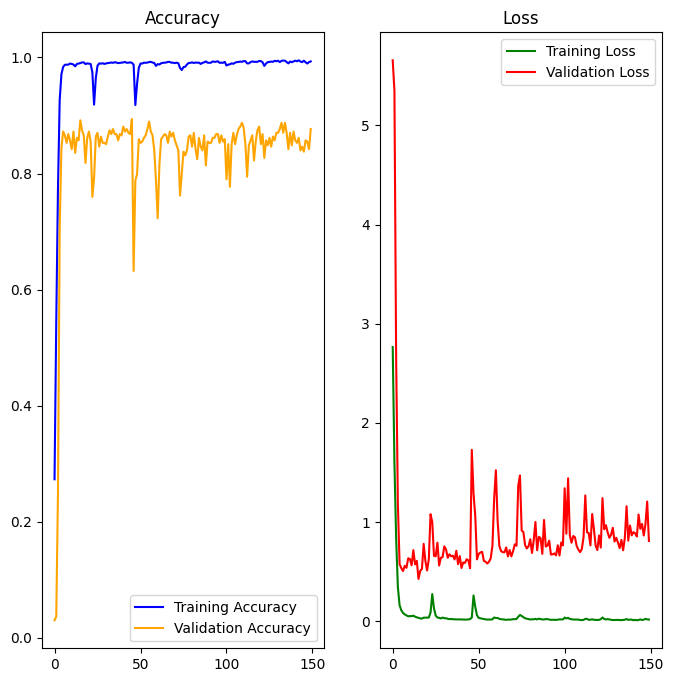

In [29]:
epochs_range = range(epochs_size)
plt.figure(figsize=(8,8))

# 정확도 그래프
plt.subplot(1,2,1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Accuracy')
plt.legend()  # 범례 추가

# 손실 그래프
plt.subplot(1,2,2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss', color='green')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Loss')
plt.legend()  # 범례 추가

plt.show()

In [30]:
model.evaluate(test_ds)

 7/15 [=============>................] - ETA: 1s - loss: 0.9527 - accuracy: 0.8393

2024-02-15 11:12:34.098702: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


 9/15 [=================>............] - ETA: 1s - loss: 0.7411 - accuracy: 0.8750

2024-02-15 11:12:34.631420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


15/15 [==============================] - 3s 217ms/step - loss: 0.6950 - accuracy: 0.8736


[0.6949743032455444, 0.8736383318901062]

In [41]:
image = 'banana2.jpg'
image = tf.keras.utils.load_img(image, target_size=(img_height,img_width))
img_arr = tf.keras.utils.array_to_img(image)
img_bat=tf.expand_dims(img_arr,0)

In [42]:
predict = model.predict(img_bat)

1/1 [==============================] - 0s 16ms/step


In [43]:
score = tf.nn.softmax(predict)

In [44]:
print('Veg/Fruit in image is {} with accuracy of {:0.2f}'.format(data_class_name[np.argmax(score)],np.max(score)*100))

Veg/Fruit in image is potato with accuracy of 3.45


In [39]:
model.save('Image_classify_1.keras')

In [45]:
model.save('Image_classify_1.h5')

/home/milk/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
# model_test = model.load()